## Test Model 2030

In [103]:
import pypsa 
import matplotlib.pyplot as plt
plt.style.use("bmh")
import pandas as pd
from pypsa.plot import add_legend_patches
import gurobipy
import cartopy.crs as ccrs
from pypsa.optimization import optimize
import matplotlib.cm as cm
import numpy as np

pd.set_option("display.max_rows", None)  # Display all rows
pd.set_option("display.max_columns", None)  # Display all columns


## Import Network

In [104]:
n = pypsa.Network("C:\\Users\\Jeremy\\Documents\\MasterThesis\\Models\\Model_IT\\20240319_IT3zeroem\\elec_s_3_ec_lv1.5_Co2L0.0-3h.nc")


INFO:pypsa.io:Imported network elec_s_3_ec_lv1.5_Co2L0.0-3h.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [105]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 6 entries
Component 'Carrier' has 23 entries
Component 'GlobalConstraint' has 2 entries
Component 'Line' has 1 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 7 entries
Component 'Load' has 3 entries
Component 'Generator' has 44 entries
Component 'StorageUnit' has 9 entries
Component 'Store' has 3 entries


In [106]:
# set marginal cost of load shedding to 3000€/MWh
for bus in n.generators.bus:
    for index in n.generators.index:
        if not bus.endswith('H2') and index.endswith('load'):
            n.generators.loc[index, 'marginal_cost'] = 3000

#edit load shedding's unit from kW to MW
for index in n.generators.index:
    if index.endswith('load') and not index.endswith('H2 load'):
        n.generators.loc[index, 'sign'] = 1

In [107]:
#solve network
#n.optimize(solver_name='gurobi')
n.lopf(solver_name='gurobi')

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2918086421.py:3: DeprecatedWarning: lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.
  n.lopf(solver_name='gurobi')
INFO:pypsa.linopf:Prepare linear problem


INFO:pypsa.linopf:Total preparation time: 4.62s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\pypsa-problem-il030gaa.lp
Reading time = 2.16 seconds
obj: 531442 rows, 256989 columns, 997217 nonzeros
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 531442 rows, 256989 columns and 997217 nonzeros
Model fingerprint: 0x02e8947a
Coefficient statistics:
  Matrix range     [1e-03, 8e+02]
  Objective range  [3e-02, 2e+05]
  Bounds range     [4e+00, 2e+09]
  RHS range        [3e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 398579 rows and 86220 columns
Presolve time: 0.69s
Presolved: 132863 rows, 170769 columns, 451103 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering t

INFO:pypsa.linopf:Optimization successful. Objective value: 2.22e+10


('ok', 'optimal')

In [108]:
def system_cost(n): #n.statistics.capex()
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6) # million €/a

In [109]:
tot_cos_base=n.objective/1e9
system_cost_base = system_cost(n)
marg_price_region_base = n.buses_t.marginal_price.mean()
stat_base = n.statistics()

## Plot Network

<function matplotlib.pyplot.show(close=None, block=None)>

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


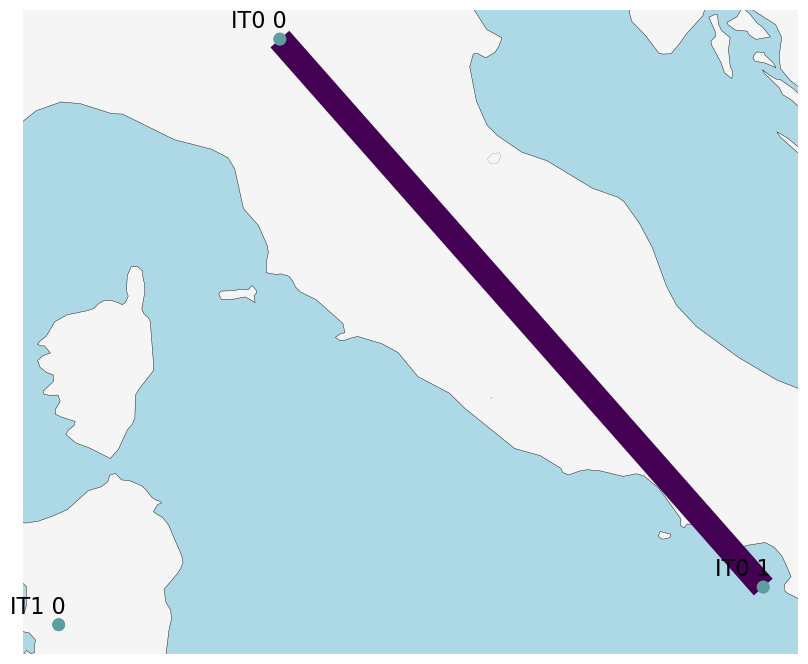

In [110]:
loading = (n.lines_t.p0.abs().mean().sort_index()/(n.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

fig, ax = plt.subplots(
    figsize=(10,10),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

n.plot(
    ax=ax,
    branch_components=["Line"],
    line_widths=n.lines.s_nom_opt/1e3, #GW
    line_colors=loading,
    line_cmap=plt.cm.viridis,
    color_geomap=True,
    bus_sizes=0.003
)

bus = n.buses
region = []
for index, row in bus.iterrows():
    x = row['x']
    y = row['y']
    if "H2" in index:
        pass
    else:
        region.append(index)
        ax.annotate(
        index,
        xy=(x, y),
        xytext=(5, 5),  # Adjust the position of the annotation
        textcoords="offset points",
        ha='right', va='bottom'
    )

plt.show


## Installed Capacity Map Plot

In [111]:
#color list for installed cap
tech_list = n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().unstack().columns.tolist()
tech_list.remove('load')
color_cap = []

for i in range(len(tech_list)):
    for j in range(len(n.carriers.index)):
        if tech_list[i] == n.carriers.index[j]:
            color_cap.append(n.carriers.color[j])
            break  # break the inner loop once a match is found  

cap = n.generators[n.generators['carrier']!='load'].groupby(['bus', 'carrier']).p_nom_opt.sum()

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\3847545614.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color_cap.append(n.carriers.color[j])


c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


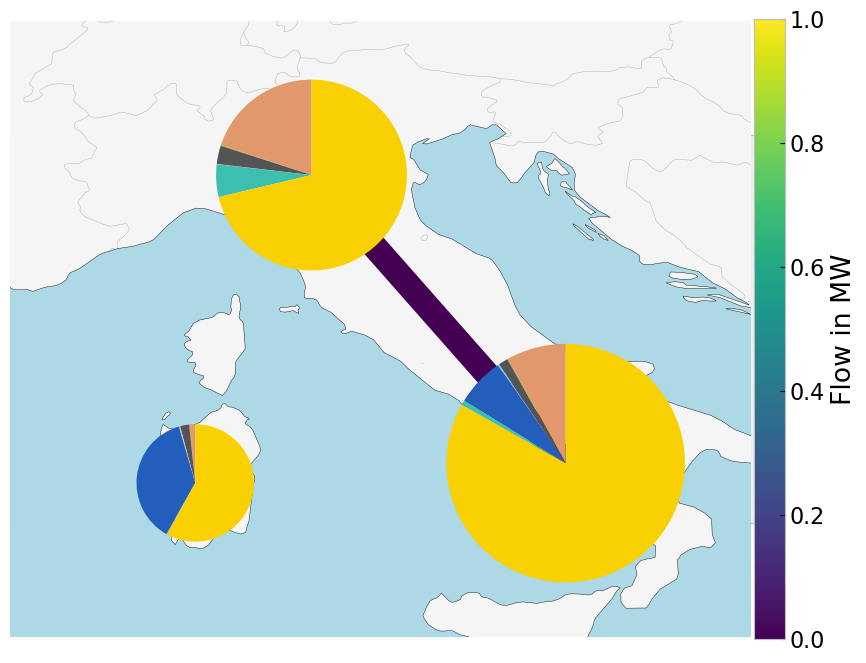

In [112]:
fig, ax = plt.subplots(
    figsize=(10,10),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

collection = n.plot(
    bus_sizes=cap / 5e4,
    bus_colors = color_cap,
    margin=0.5,
    #flow="mean",
    line_widths=n.lines.s_nom_opt/1e3, #GW
    link_widths=0,
    color_geomap=True,
    line_colors=n.lines_t.p0.mean().abs(),
)
        
plt.colorbar(collection[2], fraction=0.04, pad=0.004, label="Flow in MW")
plt.show()

## Generation Map Plot

In [113]:
#color list for energy generated 
tech_list_gen_table = n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().unstack().columns.tolist()
colors_gen_table = []

for i in range(len(tech_list_gen_table)):
    for j in range(len(n.carriers.index)):
        if tech_list_gen_table[i] == n.carriers.index[j]:
            colors_gen_table.append(n.carriers.color[j])
            break  # break the inner loop once a match is found 

#Adjust Load shedding's unit to MW from kW
#for column in n.generators_t.p.columns:
#    if column.endswith('load') and not column.endswith('H2 load'):
#        n.generators_t.p[column]/=1e3
        

gen = n.generators.assign(g=n.generators_t.p.mean()).groupby(["bus", "carrier"]).g.sum()

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\971004373.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  colors_gen_table.append(n.carriers.color[j])


c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


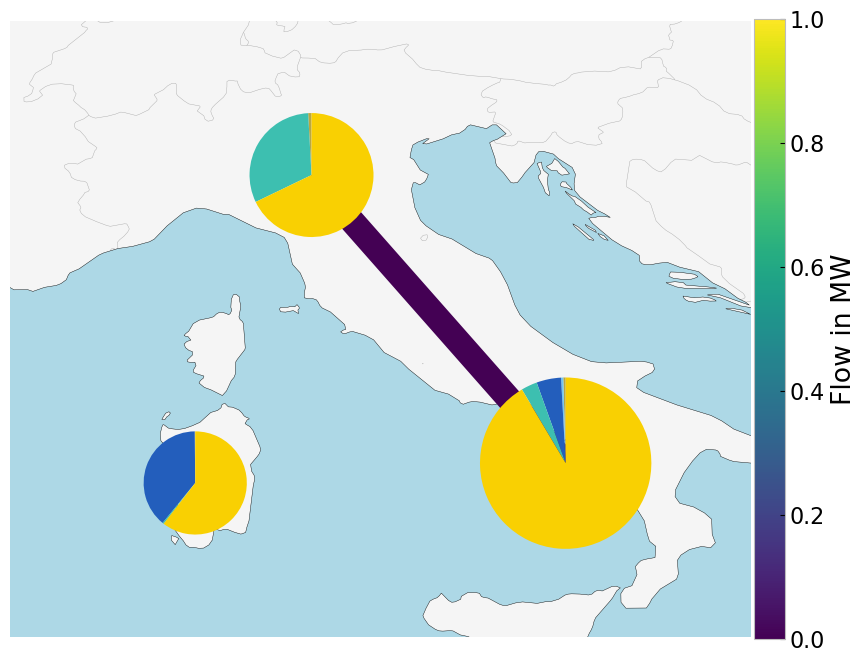

In [114]:
carriers = n.generators.carrier.unique()

plt.figure(figsize =(10,10))

collection = n.plot(
    bus_sizes=gen / 1e4,
    bus_colors = colors_gen_table,
    margin=0.5,
    #flow="mean",
    line_widths=n.lines.s_nom_opt/1e3, #GW
    link_widths=0,
    color_geomap=True,
    line_colors=n.lines_t.p0.mean().abs(),
)
plt.colorbar(collection[2], fraction=0.04, pad=0.004, label="Flow in MW")
plt.show()

## Installed Capacity

In [115]:
def inst_cap_table(n,colors):

    capacities = n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum()
    capacities.fillna(0, inplace=True)
    gen = (capacities.unstack()/1000).drop(columns=['load'],inplace=False)
    gen.fillna(0, inplace=True)

    plt.figure()
    plt.rcParams.update({'font.size': 16})

    gen.plot.bar(figsize=(17,10),
                                stacked=True,
                                color=colors,
                                grid=True,
                                xlabel="",
                                ylabel="Installed capacity [GW]",
                                title=f"Installed power capacity in Italy"
    )

    plt.show()
    return capacities

<Figure size 640x480 with 0 Axes>

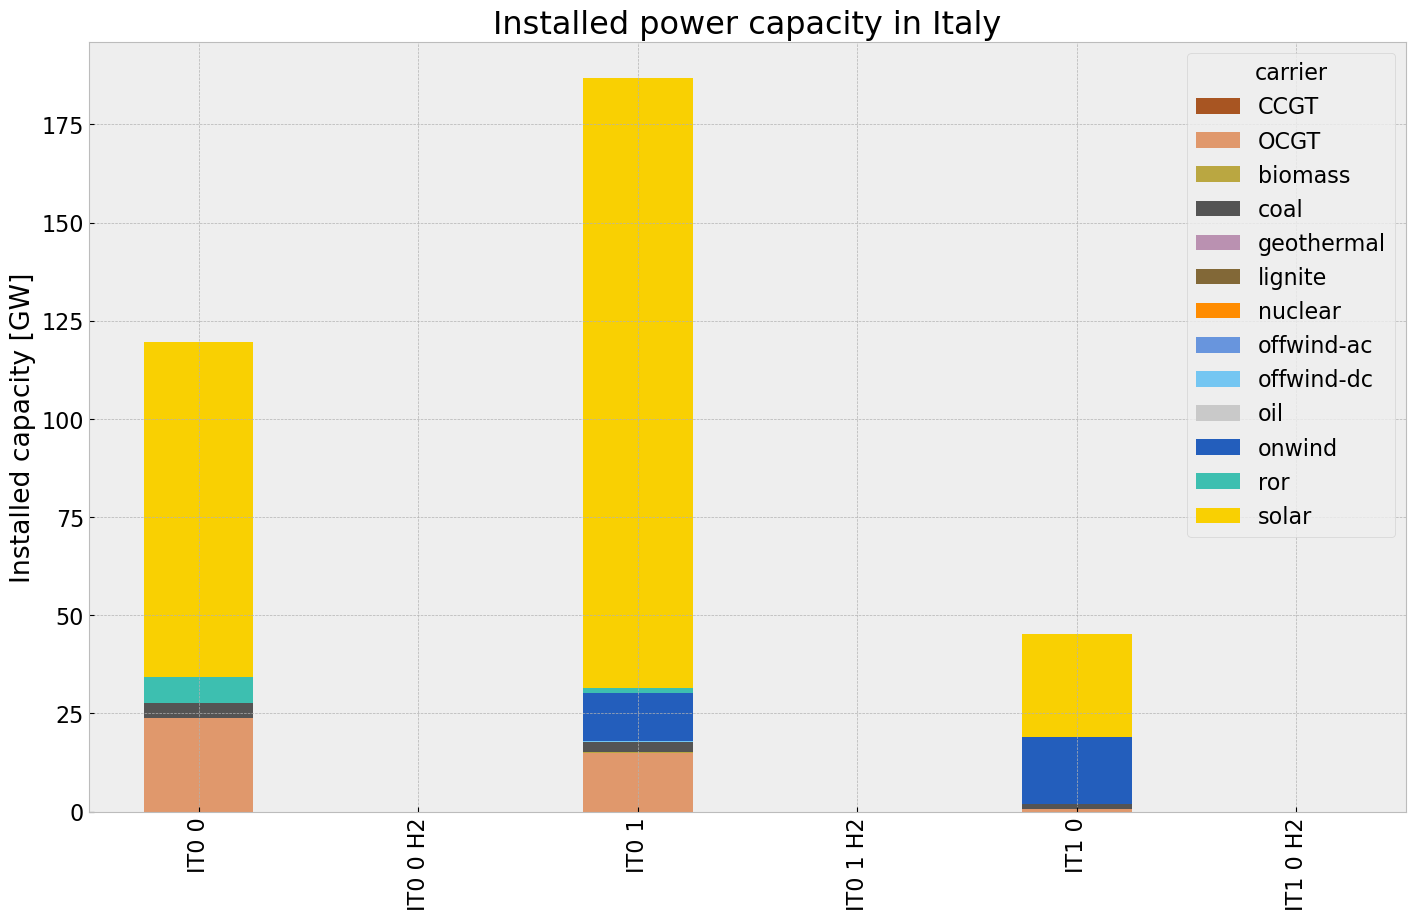

In [116]:
# consolidated istalled cap without load_shedding

#capacities_base = n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum()
#capacities_base.fillna(0, inplace=True)
#gen = (capacities_base.unstack()/1000).drop(columns=['load'],inplace=False)

capacities_base = inst_cap_table(n, color_cap)


## Generation

In [117]:
def gen_power_table(n, color):

    carrier = n.generators.carrier.unique()
    df_tot_generation = n.generators_t.p.sum()

    generations = pd.Series(index = n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().index)

    for r in region:
        for tech in carrier:
            key = f"{r} {tech}"
            if key in df_tot_generation.index:
                try:
                    generations.loc[r, tech] = df_tot_generation[key]
                    #print(generations.loc[r, tech])
                except KeyError:
                    print('error')
    generations.fillna(0, inplace=True)

    generations = (generations.unstack()/1000)#GWh
    #generations['load']/=1e3


    plt.figure()
    plt.rcParams.update({'font.size': 16})

    generations.plot.bar(figsize=(17,10),
                                stacked=True,
                                color=color,
                                grid=True,
                                xlabel="",
                                ylabel="Generated electricity [GWh]",
                                #title=f"Generated electricity in Italy in {year}"
    )

    plt.show()
    return generations

<Figure size 640x480 with 0 Axes>

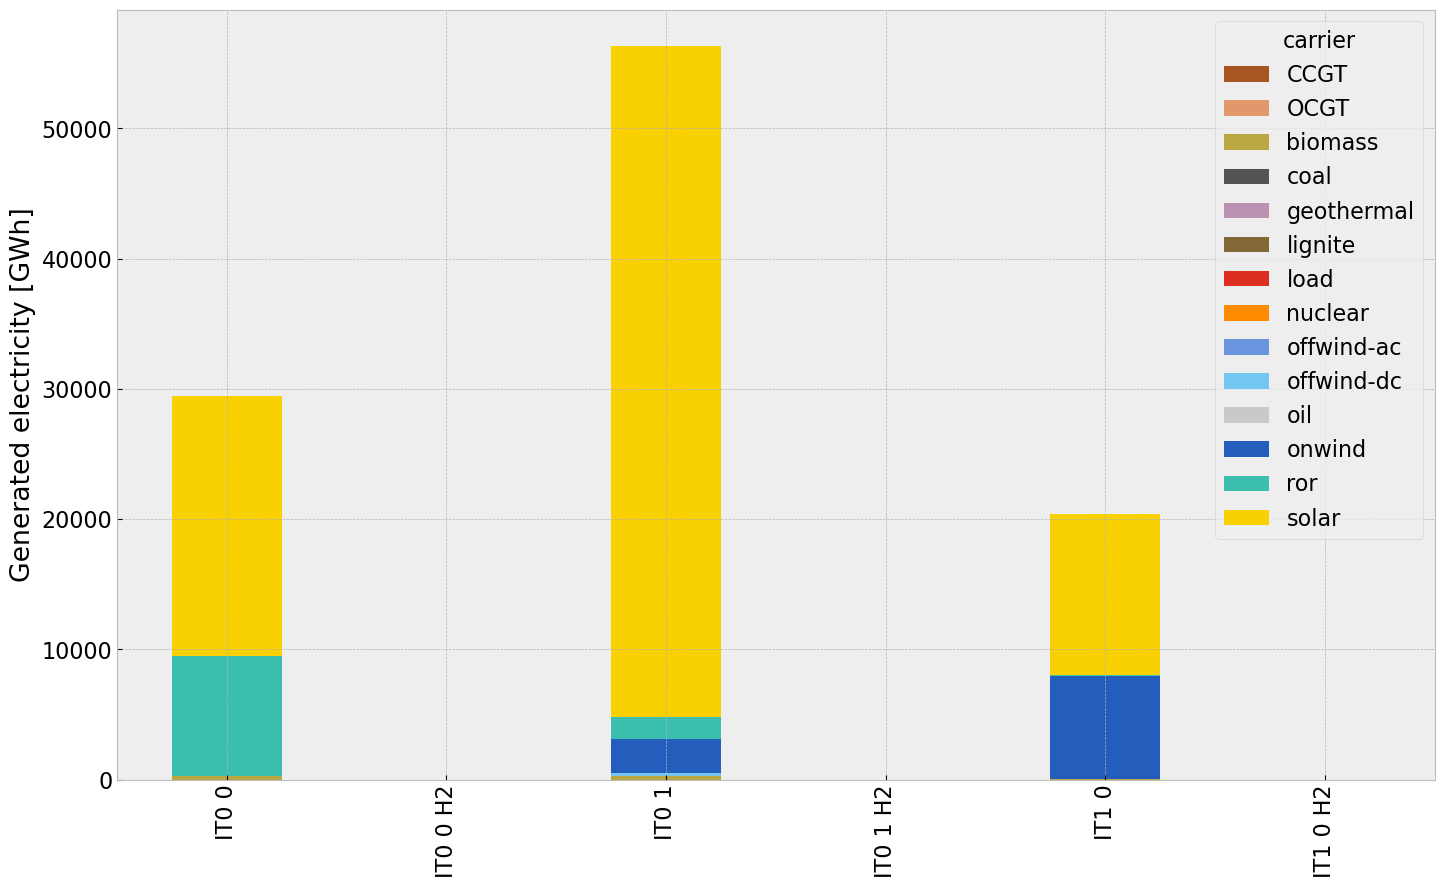

In [118]:
gen_base = gen_power_table(n,colors_gen_table)

## Snapshot

In [119]:
sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
tech_list_gen = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum()
links = n.links_t.p0.groupby(n.links.carrier, axis =1).sum().drop(['DC','H2 electrolysis'], axis=1, inplace =False).head()
tech_list_gen = pd.concat([tech_list_gen, sto], axis=1).columns.tolist()

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\3551839577.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\3551839577.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tech_list_gen = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum()
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\3551839577.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  links = n.links_t.p0.groupby(n.links.carrier, axis =1).sum().drop(['DC','H2 electrolysis'], axis=1, inplace =False).head()


In [120]:
colors_gen = []

for i in range(len(tech_list_gen)):
    for j in range(len(n.carriers.index)):
        if tech_list_gen[i] == n.carriers.index[j]:
            colors_gen.append(n.carriers.color[j])
            break  # break the inner loop once a match is found  


C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\3660868222.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  colors_gen.append(n.carriers.color[j])


In [121]:
#links Hydrolysis 
links_H = n.links_t.p0.groupby(n.links.carrier, axis=1).sum().div(1e3)
links_H = links_H.drop(columns='DC', inplace=False)
links_H['H2 electrolysis']*=-1
links_H.head()

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\1537407387.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  links_H = n.links_t.p0.groupby(n.links.carrier, axis=1).sum().div(1e3)


carrier              H2 electrolysis  H2 fuel cell
snapshot                                          
2013-01-01 00:00:00        -1.791730           0.0
2013-01-01 03:00:00        -1.791730           0.0
2013-01-01 06:00:00        -2.942537           0.0
2013-01-01 09:00:00        -2.942537           0.0
2013-01-01 12:00:00        -2.942537           0.0

In [183]:
def gen_curve(n, start, end, colors):

    plt.rcParams.update({'font.size': 16})


    p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
    #p_by_carrier['load'] /= 1e3

    #links fuel cell
    links = n.links_t.p1.groupby(n.links.carrier, axis=1).sum().div(1e3)
    links = links.drop(columns='DC', inplace=False)
    links['H2 fuel cell']*=-1
       
    # join generator, links, and storage unit
    if not n.storage_units.empty:
        sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)     
        p_by_carrier = pd.concat([p_by_carrier, sto, links], axis=1)

    start_date = start
    end_date = end
    
    # Create a date range for the specified time range
    time = pd.date_range(start=start_date, end=end_date, freq='3H')
    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    p_no_H = p_by_carrier.drop(columns = 'H2 electrolysis', inplace = False)
    p_no_H.where(p_no_H>0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=colors,
        grid=True,

    )
    
    charge = p_by_carrier.where(p_by_carrier<0).dropna(how='all', axis=1).loc[time]
    
    if not charge.empty:

        charge.plot.area(
            ax=ax,
            linewidth=0,
            color=["yellowgreen", "magenta", "purple", "grey"],
            grid=True,
        )
    
    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c='k',grid=True)

    plt.legend(loc=(1.05,0))
    
    ax.set_ylabel("Power [GW]")
    ax.set_title(f"Hourly electricity production")


    ax.set_ylim(-100,150)

In [123]:
#e_balance = n.statistics.energy_balance(aggregate_time=False, aggregate_bus=False).loc[:, :, "AC",:].droplevel(2)
#e_balance.to_excel('energybalance.xlsx', index=True) 


In [124]:
#tes = n.statistics.energy_balance(aggregate_time=False, aggregate_bus=False).loc[:, :, "AC", :].droplevel(2)
#tes.to_csv('energybalance.csv', index=True)

In [125]:
#n.loads_t.p_set.sum(axis=1).loc[pd.date_range(start='2013-01-08', end='2013-01-14', freq='3H')].div(1e3).plot(ax=ax, c='k',grid=True)


In [126]:
#p_by_carrier.where(p_by_carrier>0).loc[pd.date_range(start='2013-01-08', end='2013-01-14', freq='3H')].sum(axis=1)

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  links = n.links_t.p1.groupby(n.links.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time = pd.date_range(start=start_date, end=end_date, freq='3H')

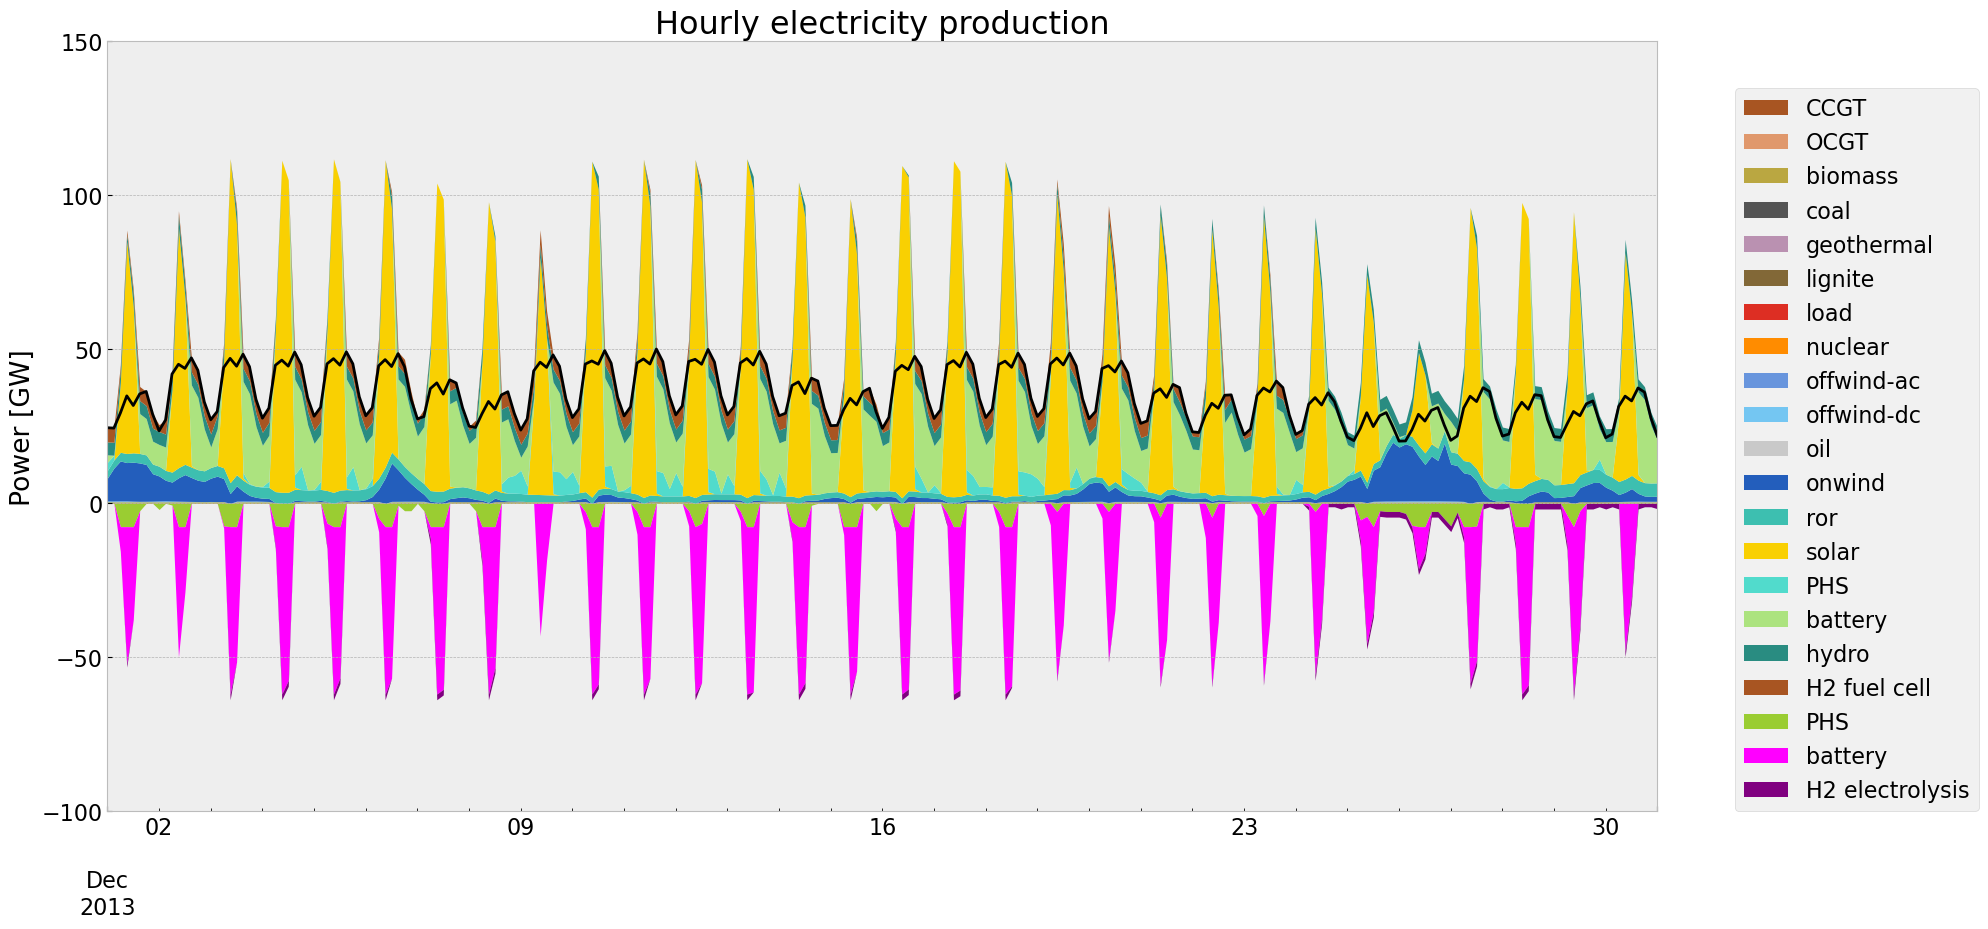

In [184]:
# winter
gen_curve(n, '2013-12-01', '2013-12-31', colors_gen)

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  links = n.links_t.p1.groupby(n.links.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time = pd.date_range(start=start_date, end=end_date, freq='3H')

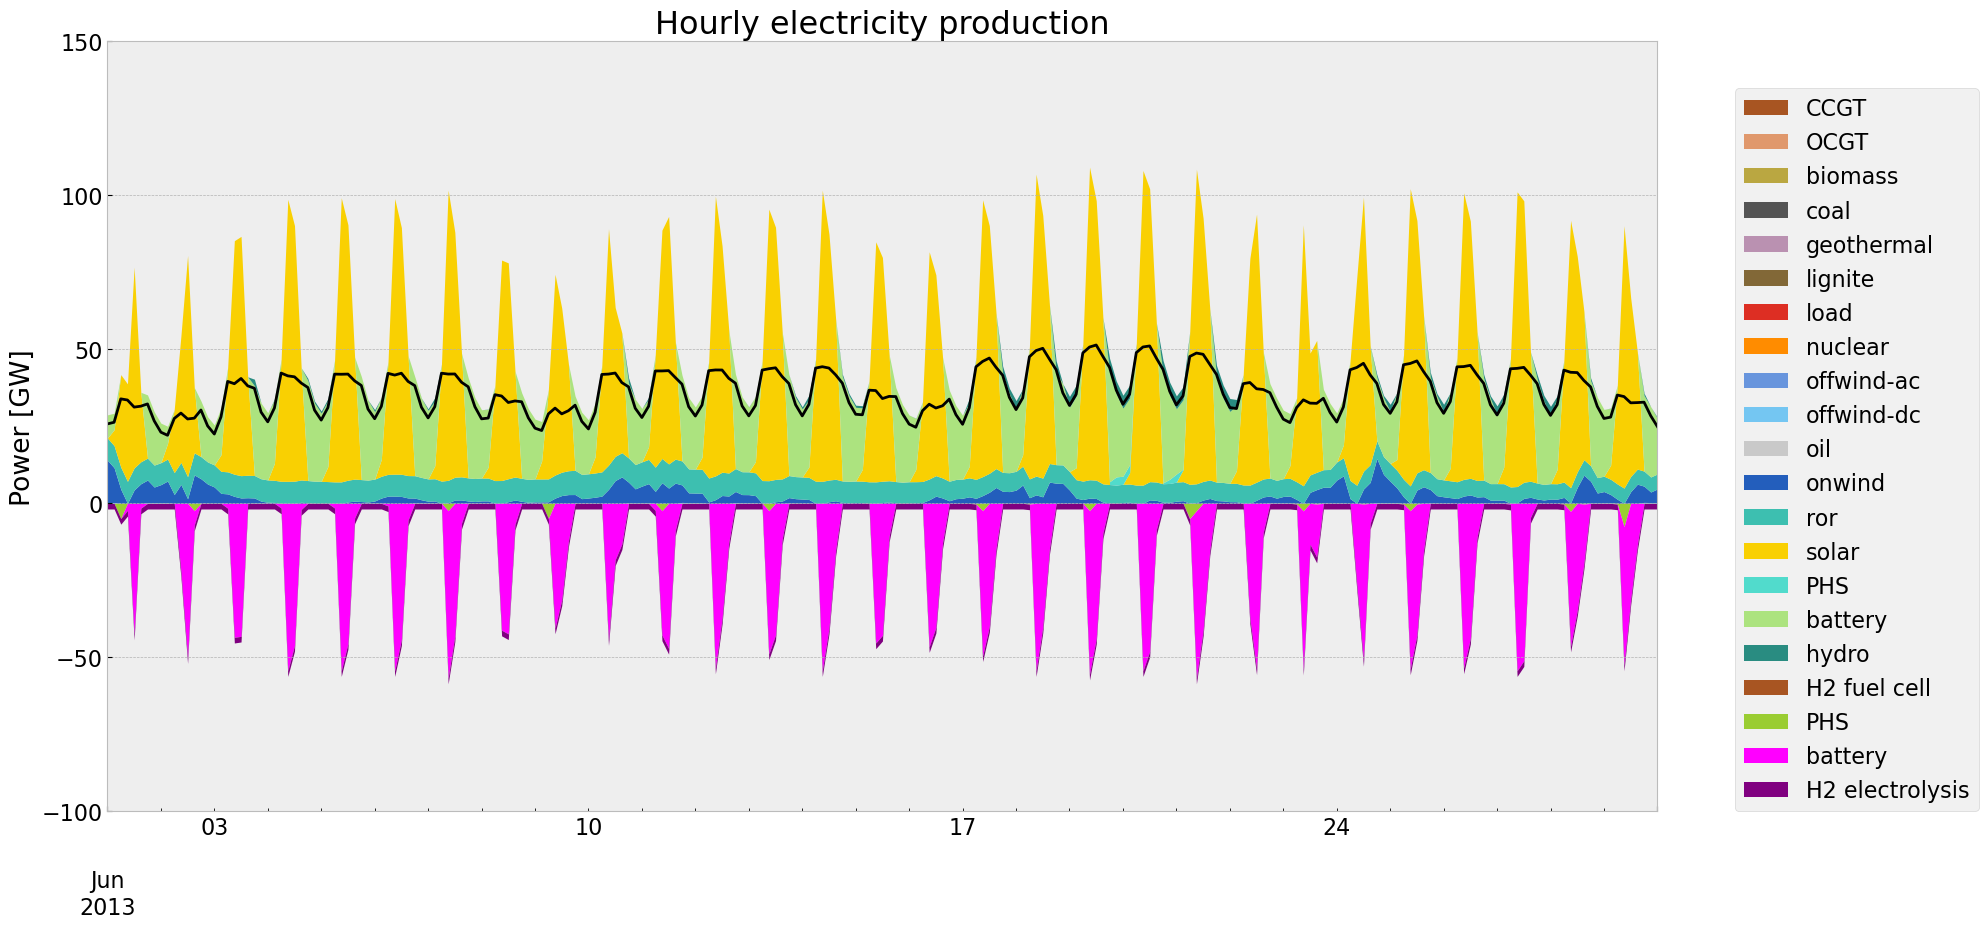

In [185]:
#summer
gen_curve(n, '2013-06-01', '2013-06-30', colors_gen)

## Storage

In [129]:
def inst_store_table(n):
    
    plt.rcParams.update({'font.size': 16})

    (n.storage_units.groupby(['bus','carrier']).p_nom_opt.sum().unstack()/1000).plot.bar(figsize=(17,10),
                                stacked=True,
                                color=["yellowgreen","magenta","red","blue"],
                                grid=True,
                                xlabel="",
                                ylabel="Installed capacity [GW]",
                                #title=f"Installed power capacities of storage systems in Italy in {year}",
                                ylim=[0,20]
    )

    return n.storage_units.groupby(['bus','carrier']).p_nom_opt.sum().unstack()/1000

carrier     PHS    battery   hydro
bus                               
IT0 0    4.9359   7.231472  3.5108
IT0 1    2.3960  37.396925  0.6060
IT1 0    0.2400   9.733295  0.0780

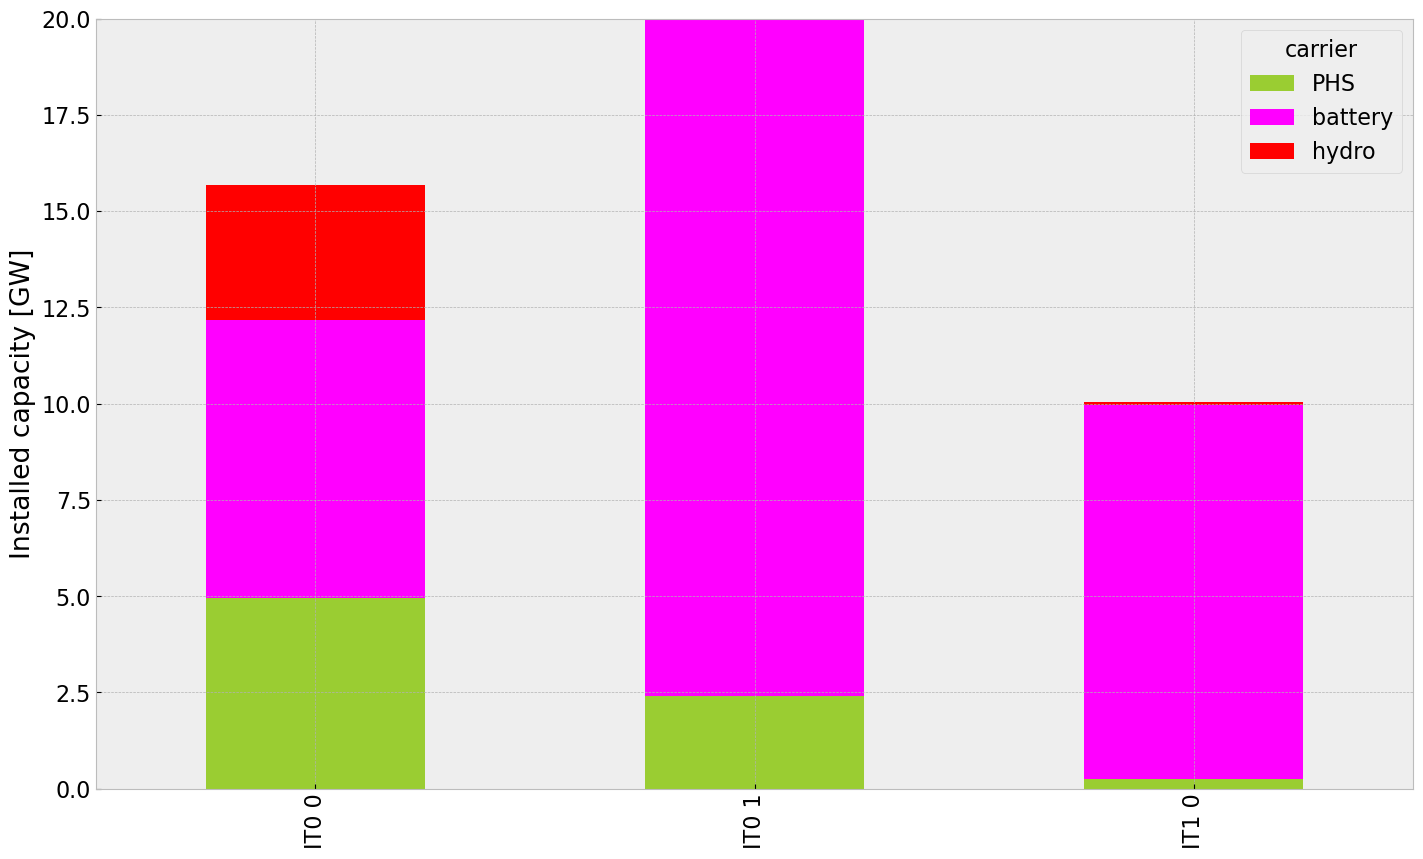

In [130]:
inst_store_table(n)

In [131]:
n.stores.groupby(['bus','carrier']).e_nom_opt.sum().unstack()/1000

carrier            H2
bus                  
IT0 0 H2  5420.381918
IT0 1 H2  3107.554448
IT1 0 H2     0.000000

In [132]:
def inst_storeh2_table(n):
    
    plt.rcParams.update({'font.size': 16})

    (n.stores.groupby(['bus','carrier']).e_nom_opt.sum().unstack()/1000).plot.bar(figsize=(17,10),
                                stacked=True,
                                color=["blue"],
                                grid=True,
                                xlabel="",
                                ylabel="H2 Store Energy Capacity [GWh]",
                                #title=f"Installed power capacities of storage systems in Italy in {year}",
                                ylim=[0,7500]
    )

    return n.storage_units.groupby(['bus','carrier']).p_nom_opt.sum().unstack()/1000

carrier     PHS    battery   hydro
bus                               
IT0 0    4.9359   7.231472  3.5108
IT0 1    2.3960  37.396925  0.6060
IT1 0    0.2400   9.733295  0.0780

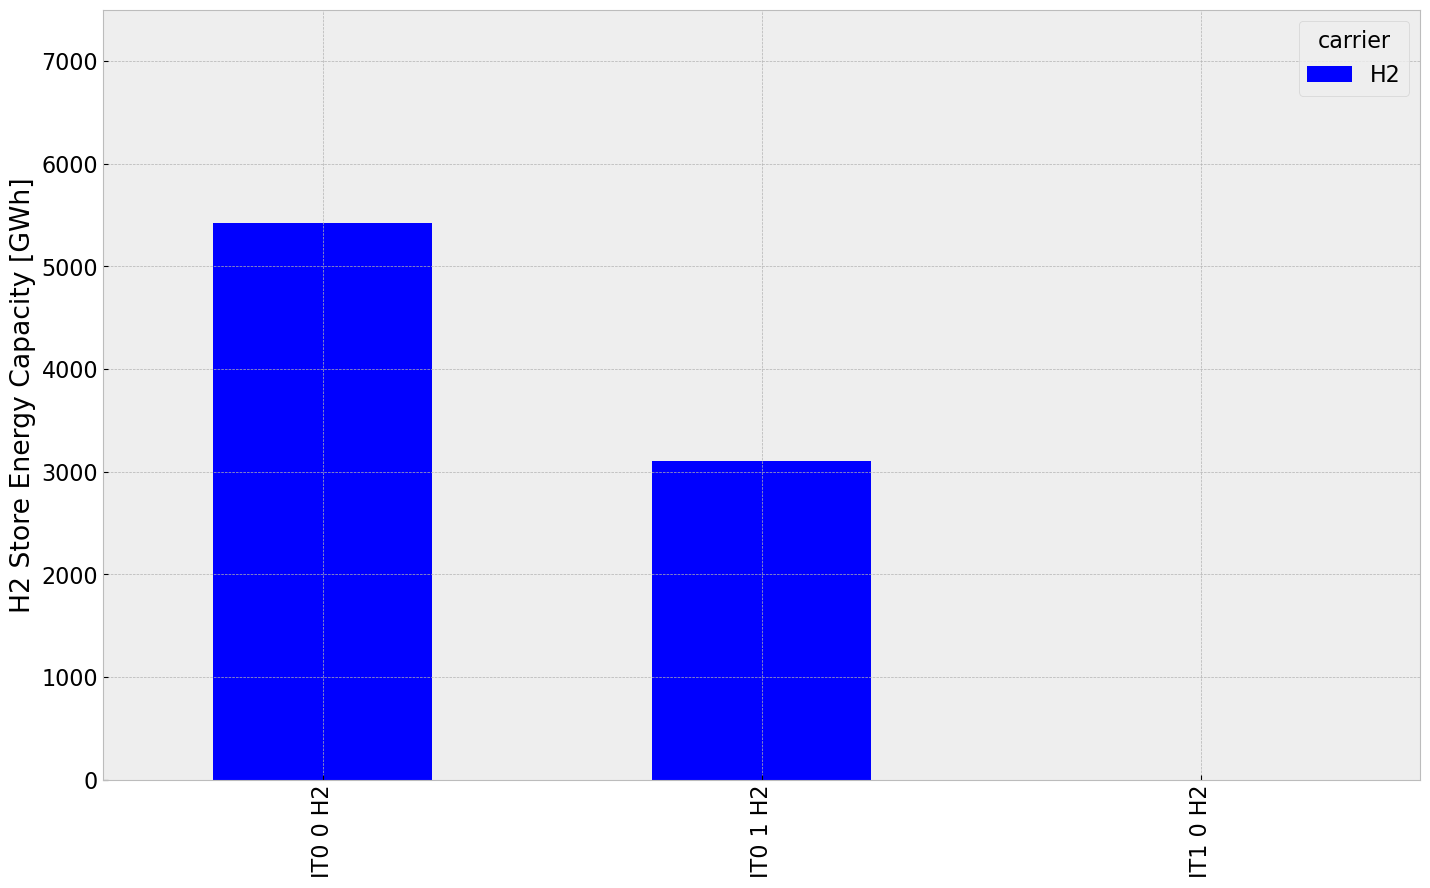

In [133]:
inst_storeh2_table(n)

In [134]:
n.stores

bus carrier  e_nom_extendable  e_cyclic  capital_cost  \
Store                                                                  
IT0 0 H2  IT0 0 H2      H2              True      True     148.31893   
IT0 1 H2  IT0 1 H2      H2              True      True     148.31893   
IT1 0 H2  IT1 0 H2      H2              True      True     148.31893   

          marginal_cost  build_year     e_nom_opt type  e_nom  e_nom_mod  \
Store                                                                      
IT0 0 H2       0.010733           0  5.420382e+06         0.0        0.0   
IT0 1 H2       0.009501           0  3.107554e+06         0.0        0.0   
IT1 0 H2       0.009966           0  0.000000e+00         0.0        0.0   

          e_nom_min  e_nom_max  e_min_pu  e_max_pu  e_initial  \
Store                                                           
IT0 0 H2        0.0        inf       0.0       1.0        0.0   
IT0 1 H2        0.0        inf       0.0       1.0        0.0   
IT1 0 H2        0.0        inf       0.0       1.0        0.0   

          e_initial_per_period  e_cyclic_per_period  p_set  q_set  sign  \
Store                                                                     
IT0 0 H2                 False                 True    0.0    0.0   1.0   
IT0 1 H2                 False                 True    0.0    0.0   1.0   
IT1 0 H2                 False                 True    0.0    0.0   1.0   

          marginal_cost_quadratic  standing_loss  lifetime  
Store                                                       
IT0 0 H2                      0.0            0.0       inf  
IT0 1 H2                      0.0            0.0       inf  
IT1 0 H2                      0.0            0.0       inf

In [135]:
def state_of_charge_plot(n):
    
    soc = n.storage_units_t.state_of_charge.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)

    plt.rcParams.update({'font.size': 16})

    fig, ax = plt.subplots(figsize=(17,10))

    soc.plot(ax=ax,
        grid=True,
        ylabel="State of charge [GWh]",
        xlabel="Time",
        #title=f"State of charge of aggregated storage systems in Italy in {year}",
        linewidth=1.5,
)

plt.show(n)

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2765649672.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  soc = n.storage_units_t.state_of_charge.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)


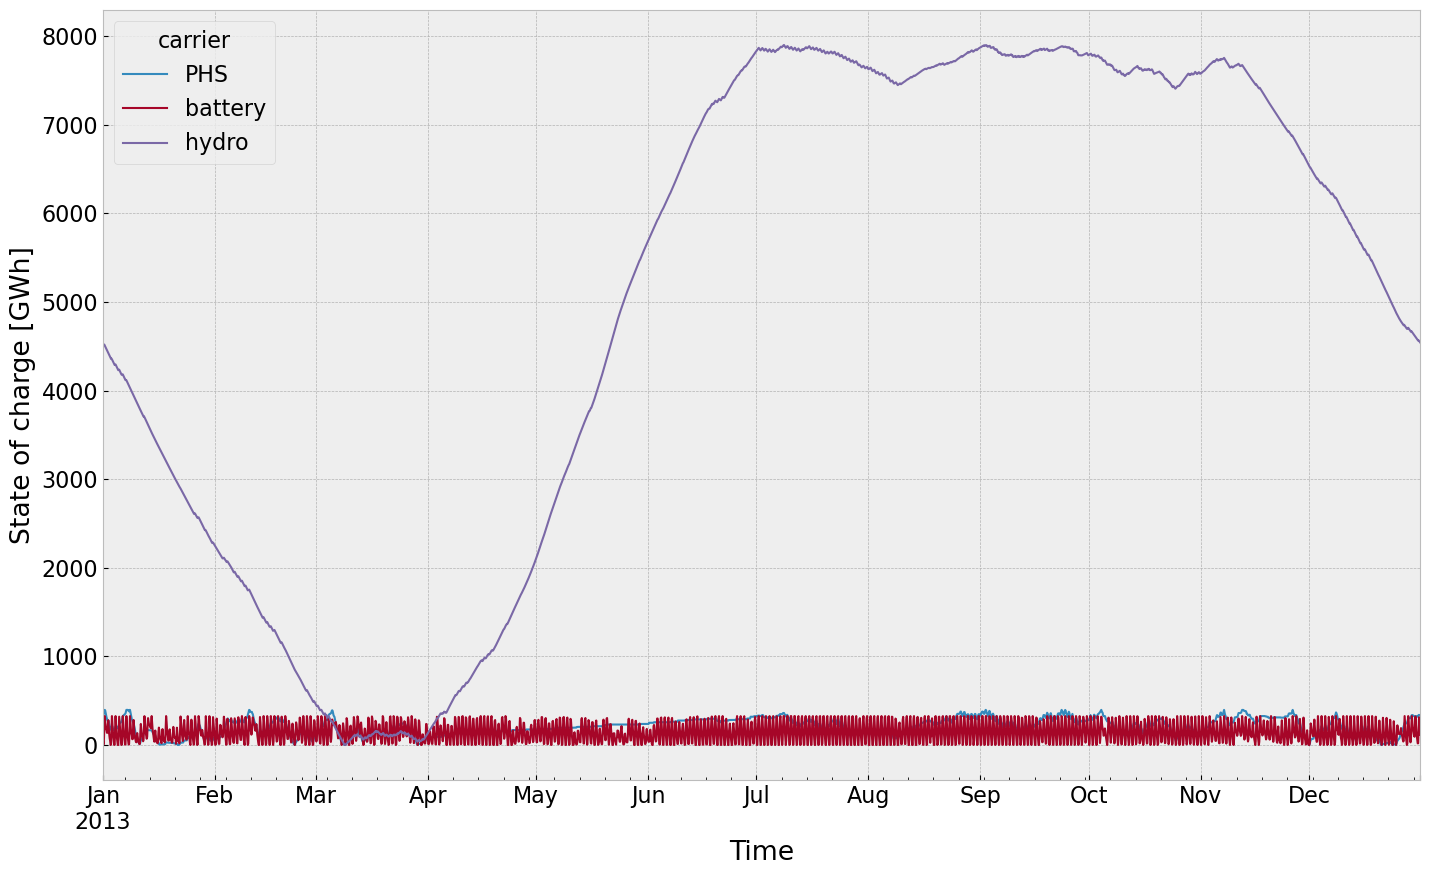

In [136]:
state_of_charge_plot(n)

## Electricity Price

In [137]:
def price_dur_curve_plot(n):

    #buses without store
    columns_to_keep =[]

    for i in n.buses_t.marginal_price.columns.tolist():
        if not i.endswith('H2'):
            columns_to_keep.append(i)
    
    price_dur_curve = pd.DataFrame()
    for region in columns_to_keep:
        price_dur_curve[region] = n.buses_t.marginal_price[region].sort_values(ascending=False).reset_index(drop=True)

    plt.rcParams.update({'font.size': 16})

    fig, ax = plt.subplots(figsize=(17,10))

    price_dur_curve.plot(ax=ax,
                    grid=True,
                    ylabel="Marginal price [€/MWh]",
                    xlabel="Time steps",
                    #title=f"Duration curves of the marginal price in the Italian regions in {year}",
                    linewidth=3,
)

plt.show()

In [138]:
columns_to_keep =[]

for i in n.buses_t.marginal_price.columns.tolist():
    if not i.endswith('H2'):
        columns_to_keep.append(i)
    


#buses without store
columns_to_keep =[]

price_dur_curve = pd.DataFrame()
for region in columns_to_keep:
    price_dur_curve[region] = n.buses_t.marginal_price[region].sort_values(ascending=False).reset_index(drop=True)


In [139]:
n.buses_t.marginal_price['IT1 0'].sort_values(ascending=False).head(20)

snapshot
2013-01-08 15:00:00    1577.331285
2013-01-09 15:00:00    1577.331285
2013-01-10 00:00:00    1577.331285
2013-01-10 03:00:00    1577.331285
2013-01-10 06:00:00    1577.331285
2013-01-08 18:00:00    1577.331285
2013-01-09 00:00:00    1577.331285
2013-01-09 03:00:00    1577.331285
2013-01-09 06:00:00    1577.331285
2013-01-09 18:00:00    1577.331285
2013-01-09 21:00:00    1577.331285
2013-01-08 21:00:00    1577.331285
2013-01-09 12:00:00    1514.229376
2013-01-09 09:00:00    1514.228988
2013-01-14 15:00:00     963.143732
2013-01-14 21:00:00     963.143732
2013-01-15 00:00:00     963.143732
2013-01-15 03:00:00     963.143732
2013-01-15 06:00:00     963.143732
2013-01-14 18:00:00     963.143732
Name: IT1 0, dtype: float64

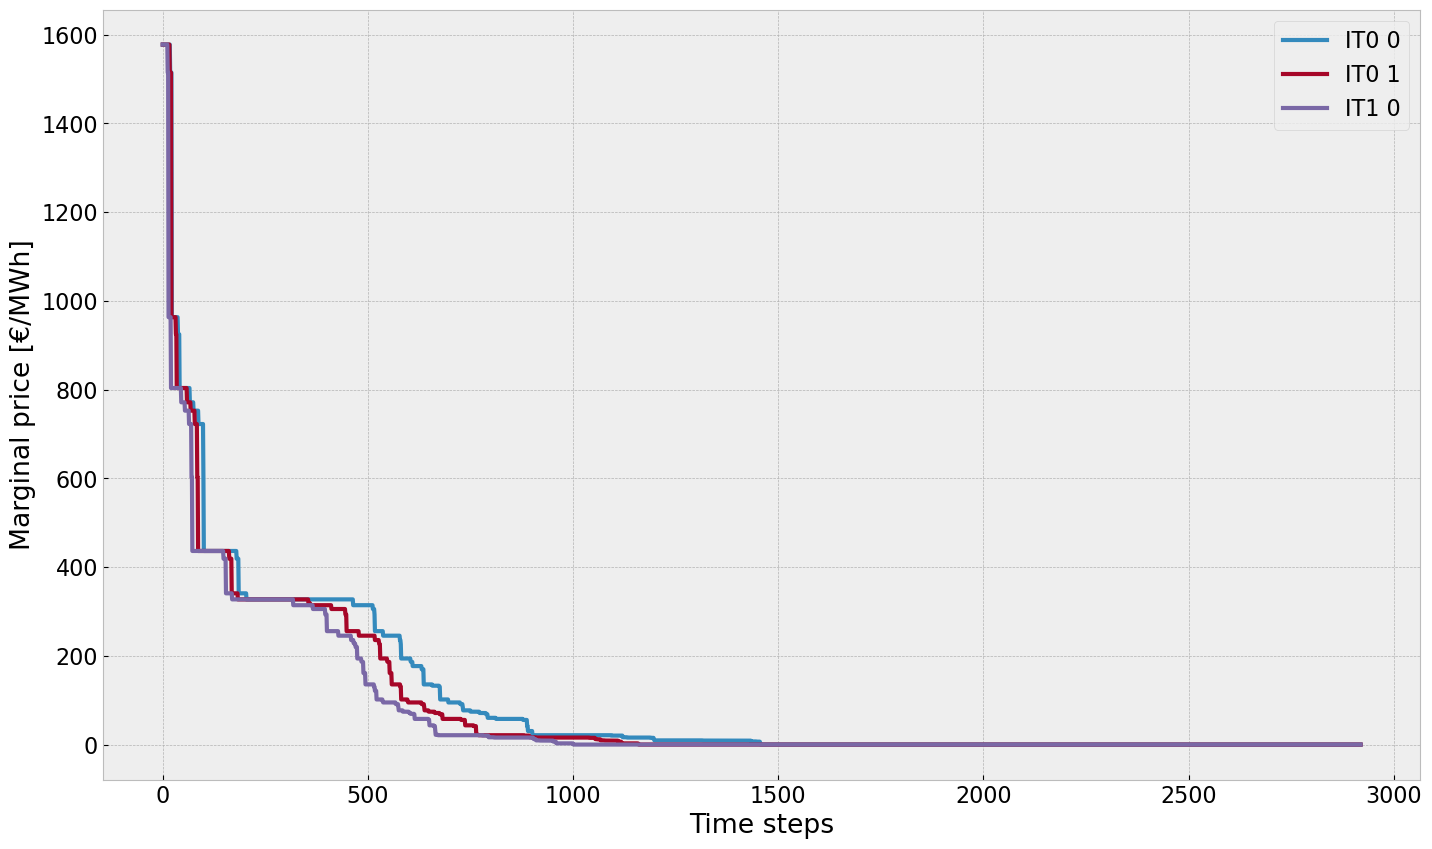

In [140]:
price_dur_curve_plot(n)

In [141]:
def price_regions_table(n):

    plt.rcParams.update({'font.size': 16})

    fig, ax = plt.subplots(figsize=(17,10))

    
    region = n.buses_t.marginal_price.mean()
    #for index, value in region.items():
    #    if index.endswith('H2'):
     #       region = region.drop(index)
    
    region.plot.bar(ax=ax,
                    grid=True,
                    ylabel="Marginal price [€/MWh]",
                    xlabel="Region",
                    title=f"Average marginal price",
                    linewidth=3,
    
    )

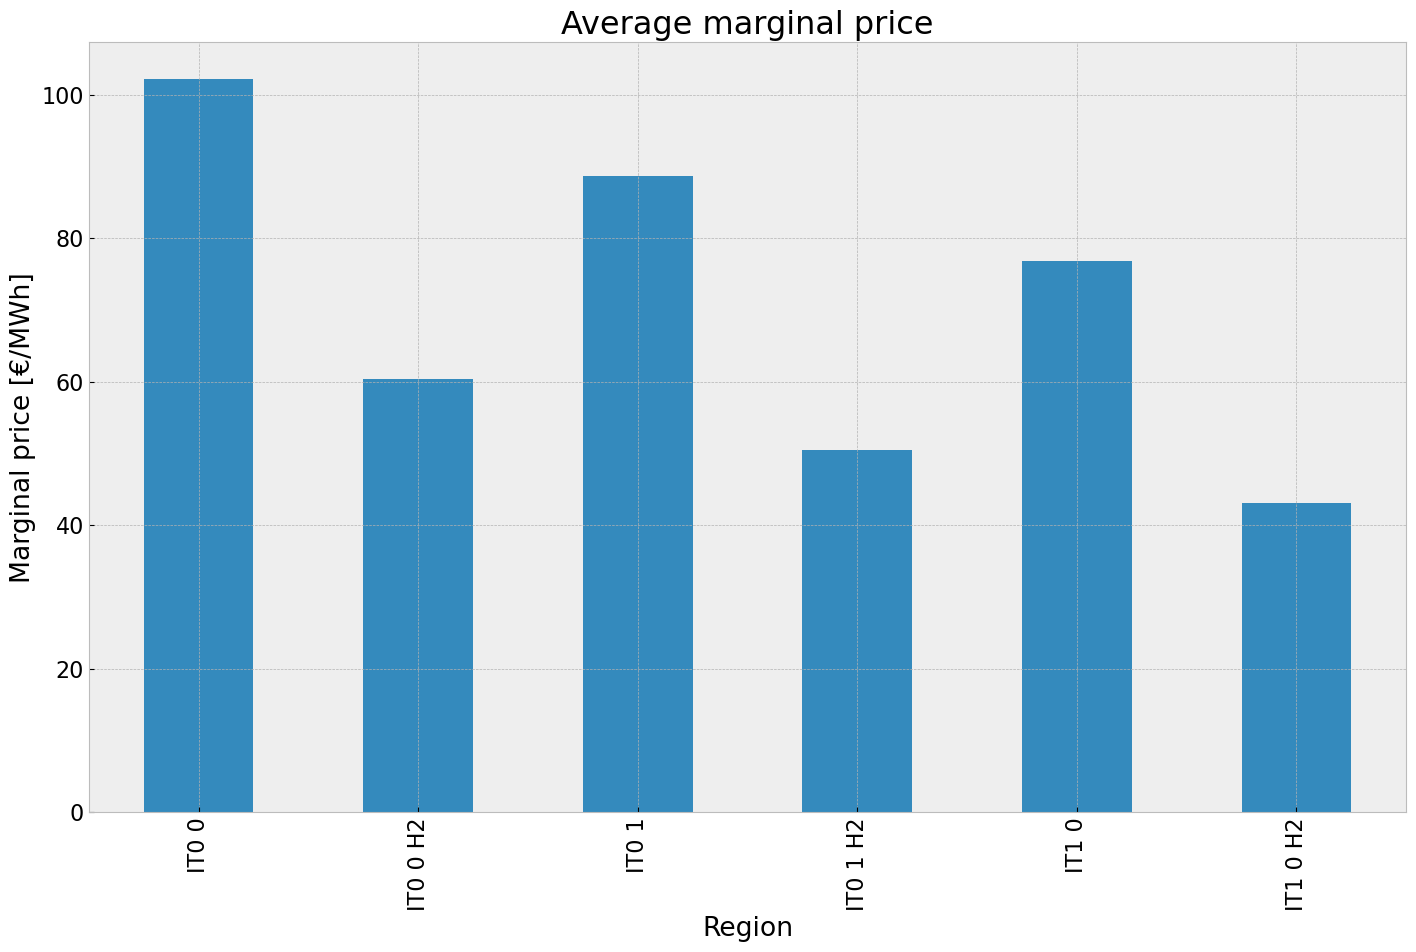

In [142]:
price_regions_table(n)

# Volcano Erruption Scenario
eruption start: 01.06.2013
reduction on radiation: 10%, source:
duration : until year end

In [143]:
#copy network
n1=n.copy()

#p_max_pu of solar generators across all regions are subtracted by 10% from 01.06.2013 to 31.12.13
eruption_start=pd.to_datetime('2013-06-01 00:00:00')
for column in n1.generators_t.p_max_pu.columns:
        if column.endswith('solar'):
                for index,row in n1.generators_t.p_max_pu[column].items():
                        if index >= eruption_start:
                                new_p_max_pu = n1.generators_t.p_max_pu.at[index, column] * 0.1 #0.9
                                n1.generators_t.p_max_pu.at[index, column] = new_p_max_pu
                                if new_p_max_pu<0:
                                    n1.generators_t.p_max_pu.at[index, column] = 0


#set the optimal capacity of generators from the base scenario as the new minimum capacity 
for index, value in n1.generators.p_nom_extendable.items():
    if value:  
        n1.generators.at[index, 'p_nom_min'] = n.generators.at[index, 'p_nom_opt']


#set the optimal capacity of storage units from the base scenario as the new minimum capacity 
for index, value in n1.storage_units.p_nom_extendable.items():
    if value:  
        n1.storage_units.at[index, 'p_nom_min'] = n.storage_units.at[index, 'p_nom_opt']

#set the optimal capacity of lines from the base scenario as the new minimum capacity 
for index, value in n1.lines.s_nom_extendable.items():
    if value:  
        n1.lines.at[index, 's_nom_min'] = n.lines.at[index, 's_nom_opt']

                        

In [144]:
n1.generators_t.p_max_pu.sum()

Generator
IT0 0 offwind-ac     487.384979
IT0 0 offwind-dc     604.391882
IT0 0 onwind         142.342859
IT0 0 ror           1398.010907
IT0 0 solar          174.125273
IT0 1 offwind-ac     540.778674
IT0 1 offwind-dc     858.589210
IT0 1 onwind         299.740456
IT0 1 ror           1398.010907
IT0 1 solar          208.232957
IT1 0 offwind-ac     811.941052
IT1 0 onwind         565.816181
IT1 0 ror           1398.010907
IT1 0 solar          202.156162
dtype: float64

## 1. Scenario: allow additional investment of extendable generators and storage

In [145]:
n1.optimize.create_model()


Index(['IT0 1 offwind-dc'], dtype='object', name='Generator')


Linopy LP model

Variables:
----------
 * Generator-p_nom (Generator-ext)
 * Line-s_nom (Line-ext)
 * Link-p_nom (Link-ext)
 * Store-e_nom (Store-ext)
 * StorageUnit-p_nom (StorageUnit-ext)
 * Generator-p (snapshot, Generator)
 * Line-s (snapshot, Line)
 * Link-p (snapshot, Link)
 * Store-e (snapshot, Store)
 * StorageUnit-p_dispatch (snapshot, StorageUnit)
 * StorageUnit-p_store (snapshot, StorageUnit)
 * StorageUnit-state_of_charge (snapshot, StorageUnit)
 * StorageUnit-spill (snapshot, StorageUnit)
 * Store-p (snapshot, Store)
 * objective_constant

Constraints:
------------
 * Generator-ext-p_nom-lower (Generator-ext)
 * Generator-ext-p_nom-upper (Generator-ext)
 * Line-ext-s_nom-lower (Line-ext)
 * Line-ext-s_nom-upper (Line-ext)
 * Link-ext-p_nom-lower (Link-ext)
 * Link-ext-p_nom-upper (Link-ext)
 * Store-ext-e_nom-lower (Store-ext)
 * Store-ext-e_nom-upper (Store-ext)
 * StorageUnit-ext-p_nom-lower (StorageUnit-ext)
 * StorageUnit-ext-p_nom-upper (StorageUnit-ext)
 * Generator-

In [146]:
#solve network

n1.optimize(solver_name='gurobi')

Index(['IT0 1 offwind-dc'], dtype='object', name='Generator')
Index(['IT0 1 offwind-dc'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 15/15 [00:00<00:00, 15.96it/s]
INFO:linopy.io: Writing time: 6.45s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-8rerkal0.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-8rerkal0.lp


Reading time = 1.97 seconds


INFO:gurobipy:Reading time = 1.97 seconds


obj: 531483 rows, 256950 columns, 997219 nonzeros


INFO:gurobipy:obj: 531483 rows, 256950 columns, 997219 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 531483 rows, 256950 columns and 997219 nonzeros


INFO:gurobipy:Optimize a model with 531483 rows, 256950 columns and 997219 nonzeros


Model fingerprint: 0x6ac0f82a


INFO:gurobipy:Model fingerprint: 0x6ac0f82a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+00, 2e+09]


INFO:gurobipy:  Bounds range     [4e+00, 2e+09]


  RHS range        [3e+00, 1e+09]


INFO:gurobipy:  RHS range        [3e+00, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 401426 rows and 86182 columns


INFO:gurobipy:Presolve removed 401426 rows and 86182 columns


Presolve time: 0.65s


INFO:gurobipy:Presolve time: 0.65s


Presolved: 130057 rows, 170768 columns, 445491 nonzeros


INFO:gurobipy:Presolved: 130057 rows, 170768 columns, 445491 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.17s


INFO:gurobipy:Ordering time: 0.17s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 24


INFO:gurobipy: Dense cols : 24


 AA' NZ     : 3.185e+05


INFO:gurobipy: AA' NZ     : 3.185e+05


 Factor NZ  : 2.074e+06 (roughly 140 MB of memory)


INFO:gurobipy: Factor NZ  : 2.074e+06 (roughly 140 MB of memory)


 Factor Ops : 5.805e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.805e+07 (less than 1 second per iteration)


 Threads    : 3


INFO:gurobipy: Threads    : 3


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.50012060e+19 -6.61323265e+19  1.01e+10 1.09e+06  2.92e+15     1s


INFO:gurobipy:   0   2.50012060e+19 -6.61323265e+19  1.01e+10 1.09e+06  2.92e+15     1s


   1   1.73016905e+19 -2.70785091e+19  7.44e+09 3.11e+05  1.55e+15     1s


INFO:gurobipy:   1   1.73016905e+19 -2.70785091e+19  7.44e+09 3.11e+05  1.55e+15     1s


   2   1.22150043e+19 -1.19623937e+19  5.29e+09 6.35e+04  1.06e+15     1s


INFO:gurobipy:   2   1.22150043e+19 -1.19623937e+19  5.29e+09 6.35e+04  1.06e+15     1s


   3   3.33166212e+18 -4.13259396e+18  1.43e+09 1.28e+04  2.83e+14     2s


INFO:gurobipy:   3   3.33166212e+18 -4.13259396e+18  1.43e+09 1.28e+04  2.83e+14     2s


   4   2.94840084e+17 -5.41733825e+17  1.02e+08 4.15e+02  2.07e+13     2s


INFO:gurobipy:   4   2.94840084e+17 -5.41733825e+17  1.02e+08 4.15e+02  2.07e+13     2s


   5   4.41328118e+16 -6.31314890e+16  2.59e+05 1.67e+01  3.55e+11     2s


INFO:gurobipy:   5   4.41328118e+16 -6.31314890e+16  2.59e+05 1.67e+01  3.55e+11     2s


   6   2.03224002e+16 -1.19380673e+16  1.15e+05 2.53e+00  1.07e+11     2s


INFO:gurobipy:   6   2.03224002e+16 -1.19380673e+16  1.15e+05 2.53e+00  1.07e+11     2s


   7   1.28080033e+16 -5.21843469e+15  7.09e+04 1.07e+00  5.96e+10     3s


INFO:gurobipy:   7   1.28080033e+16 -5.21843469e+15  7.09e+04 1.07e+00  5.96e+10     3s


   8   1.01063994e+15 -1.62240981e+15  5.47e+03 2.69e-01  7.90e+09     3s


INFO:gurobipy:   8   1.01063994e+15 -1.62240981e+15  5.47e+03 2.69e-01  7.90e+09     3s


   9   8.47377345e+13 -3.64512277e+14  4.09e+02 5.44e-02  1.27e+09     3s


INFO:gurobipy:   9   8.47377345e+13 -3.64512277e+14  4.09e+02 5.44e-02  1.27e+09     3s


  10   3.33632313e+12 -7.94503973e+13  6.92e+00 1.13e-02  2.29e+08     3s


INFO:gurobipy:  10   3.33632313e+12 -7.94503973e+13  6.92e+00 1.13e-02  2.29e+08     3s


  11   1.54672212e+12 -1.76150602e+13  2.53e+00 2.46e-03  5.29e+07     3s


INFO:gurobipy:  11   1.54672212e+12 -1.76150602e+13  2.53e+00 2.46e-03  5.29e+07     3s


  12   1.09321067e+12 -1.06997068e+13  1.70e+00 1.49e-03  3.25e+07     3s


INFO:gurobipy:  12   1.09321067e+12 -1.06997068e+13  1.70e+00 1.49e-03  3.25e+07     3s


  13   6.79853391e+11 -5.25774542e+12  9.16e-01 7.25e-04  1.64e+07     4s


INFO:gurobipy:  13   6.79853391e+11 -5.25774542e+12  9.16e-01 7.25e-04  1.64e+07     4s


  14   4.46410212e+11 -2.95423054e+12  5.16e-01 4.03e-04  9.36e+06     4s


INFO:gurobipy:  14   4.46410212e+11 -2.95423054e+12  5.16e-01 4.03e-04  9.36e+06     4s


  15   2.72576612e+11 -8.18626189e+11  2.36e-01 1.13e-04  3.00e+06     4s


INFO:gurobipy:  15   2.72576612e+11 -8.18626189e+11  2.36e-01 1.13e-04  3.00e+06     4s


  16   2.13089846e+11 -7.06606818e+11  1.61e-01 9.87e-05  2.53e+06     4s


INFO:gurobipy:  16   2.13089846e+11 -7.06606818e+11  1.61e-01 9.87e-05  2.53e+06     4s


  17   1.66122667e+11 -4.00399772e+11  1.05e-01 6.05e-05  1.56e+06     4s


INFO:gurobipy:  17   1.66122667e+11 -4.00399772e+11  1.05e-01 6.05e-05  1.56e+06     4s


  18   1.40140996e+11 -2.92820061e+11  7.62e-02 4.65e-05  1.19e+06     4s


INFO:gurobipy:  18   1.40140996e+11 -2.92820061e+11  7.62e-02 4.65e-05  1.19e+06     4s


  19   1.21003839e+11 -1.94455102e+11  5.53e-02 3.37e-05  8.68e+05     5s


INFO:gurobipy:  19   1.21003839e+11 -1.94455102e+11  5.53e-02 3.37e-05  8.68e+05     5s


  20   1.08989585e+11 -6.54631492e+10  4.29e-02 1.72e-05  4.80e+05     5s


INFO:gurobipy:  20   1.08989585e+11 -6.54631492e+10  4.29e-02 1.72e-05  4.80e+05     5s


  21   9.16458885e+10  3.10277419e+09  2.53e-02 8.02e-06  2.44e+05     5s


INFO:gurobipy:  21   9.16458885e+10  3.10277419e+09  2.53e-02 8.02e-06  2.44e+05     5s


  22   8.77552404e+10  1.49908593e+10  2.15e-02 6.45e-06  2.00e+05     5s


INFO:gurobipy:  22   8.77552404e+10  1.49908593e+10  2.15e-02 6.45e-06  2.00e+05     5s


  23   8.02277605e+10  3.45380919e+10  1.44e-02 3.88e-06  1.26e+05     5s


INFO:gurobipy:  23   8.02277605e+10  3.45380919e+10  1.44e-02 3.88e-06  1.26e+05     5s


  24   7.50329021e+10  4.07592682e+10  9.89e-03 3.00e-06  9.43e+04     6s


INFO:gurobipy:  24   7.50329021e+10  4.07592682e+10  9.89e-03 3.00e-06  9.43e+04     6s


  25   7.20686184e+10  4.41851938e+10  7.35e-03 2.52e-06  7.67e+04     6s


INFO:gurobipy:  25   7.20686184e+10  4.41851938e+10  7.35e-03 2.52e-06  7.67e+04     6s


  26   7.08163473e+10  5.15398137e+10  6.36e-03 1.55e-06  5.30e+04     6s


INFO:gurobipy:  26   7.08163473e+10  5.15398137e+10  6.36e-03 1.55e-06  5.30e+04     6s


  27   6.82616275e+10  5.45262153e+10  4.28e-03 1.16e-06  3.78e+04     6s


INFO:gurobipy:  27   6.82616275e+10  5.45262153e+10  4.28e-03 1.16e-06  3.78e+04     6s


  28   6.70049555e+10  5.66746503e+10  3.21e-03 8.92e-07  2.84e+04     6s


INFO:gurobipy:  28   6.70049555e+10  5.66746503e+10  3.21e-03 8.92e-07  2.84e+04     6s


  29   6.65570265e+10  5.80078070e+10  2.81e-03 7.16e-07  2.35e+04     7s


INFO:gurobipy:  29   6.65570265e+10  5.80078070e+10  2.81e-03 7.16e-07  2.35e+04     7s


  30   6.58251929e+10  5.94919180e+10  2.13e-03 5.36e-07  1.74e+04     7s


INFO:gurobipy:  30   6.58251929e+10  5.94919180e+10  2.13e-03 5.36e-07  1.74e+04     7s


  31   6.50718466e+10  6.05431424e+10  1.38e-03 3.95e-07  1.25e+04     7s


INFO:gurobipy:  31   6.50718466e+10  6.05431424e+10  1.38e-03 3.95e-07  1.25e+04     7s


  32   6.46768811e+10  6.15786642e+10  9.98e-04 2.59e-07  8.52e+03     7s


INFO:gurobipy:  32   6.46768811e+10  6.15786642e+10  9.98e-04 2.59e-07  8.52e+03     7s


  33   6.43298710e+10  6.20420925e+10  6.74e-04 1.98e-07  6.29e+03     8s


INFO:gurobipy:  33   6.43298710e+10  6.20420925e+10  6.74e-04 1.98e-07  6.29e+03     8s


  34   6.41675984e+10  6.26672259e+10  8.89e-04 1.17e-07  4.13e+03     8s


INFO:gurobipy:  34   6.41675984e+10  6.26672259e+10  8.89e-04 1.17e-07  4.13e+03     8s


  35   6.40402494e+10  6.28421006e+10  7.41e-04 9.50e-08  3.30e+03     8s


INFO:gurobipy:  35   6.40402494e+10  6.28421006e+10  7.41e-04 9.50e-08  3.30e+03     8s


  36   6.39178242e+10  6.30598930e+10  9.72e-04 6.69e-08  2.36e+03     8s


INFO:gurobipy:  36   6.39178242e+10  6.30598930e+10  9.72e-04 6.69e-08  2.36e+03     8s


  37   6.38925181e+10  6.32322872e+10  8.57e-04 2.02e-07  1.82e+03     8s


INFO:gurobipy:  37   6.38925181e+10  6.32322872e+10  8.57e-04 2.02e-07  1.82e+03     8s


  38   6.37937032e+10  6.33297407e+10  4.98e-04 4.06e-07  1.28e+03     9s


INFO:gurobipy:  38   6.37937032e+10  6.33297407e+10  4.98e-04 4.06e-07  1.28e+03     9s


  39   6.37254860e+10  6.33955974e+10  2.55e-04 4.50e-07  9.08e+02     9s


INFO:gurobipy:  39   6.37254860e+10  6.33955974e+10  2.55e-04 4.50e-07  9.08e+02     9s


  40   6.36896277e+10  6.34649102e+10  2.62e-04 4.88e-07  6.19e+02     9s


INFO:gurobipy:  40   6.36896277e+10  6.34649102e+10  2.62e-04 4.88e-07  6.19e+02     9s


  41   6.36765682e+10  6.34971707e+10  2.22e-04 3.89e-07  4.94e+02     9s


INFO:gurobipy:  41   6.36765682e+10  6.34971707e+10  2.22e-04 3.89e-07  4.94e+02     9s


  42   6.36513969e+10  6.35262317e+10  1.62e-04 5.01e-07  3.45e+02    10s


INFO:gurobipy:  42   6.36513969e+10  6.35262317e+10  1.62e-04 5.01e-07  3.45e+02    10s


  43   6.36316602e+10  6.35482297e+10  9.25e-05 5.13e-07  2.30e+02    10s


INFO:gurobipy:  43   6.36316602e+10  6.35482297e+10  9.25e-05 5.13e-07  2.30e+02    10s


  44   6.36222331e+10  6.35630096e+10  6.15e-05 3.86e-07  1.63e+02    10s


INFO:gurobipy:  44   6.36222331e+10  6.35630096e+10  6.15e-05 3.86e-07  1.63e+02    10s


  45   6.36166417e+10  6.35845621e+10  4.59e-05 1.63e-07  8.83e+01    10s


INFO:gurobipy:  45   6.36166417e+10  6.35845621e+10  4.59e-05 1.63e-07  8.83e+01    10s


  46   6.36108281e+10  6.35887733e+10  3.12e-05 1.79e-07  6.07e+01    10s


INFO:gurobipy:  46   6.36108281e+10  6.35887733e+10  3.12e-05 1.79e-07  6.07e+01    10s


  47   6.36084892e+10  6.35947119e+10  2.39e-05 8.32e-08  3.79e+01    11s


INFO:gurobipy:  47   6.36084892e+10  6.35947119e+10  2.39e-05 8.32e-08  3.79e+01    11s


  48   6.36055642e+10  6.35959271e+10  1.50e-05 6.50e-08  2.65e+01    11s


INFO:gurobipy:  48   6.36055642e+10  6.35959271e+10  1.50e-05 6.50e-08  2.65e+01    11s


  49   6.36048848e+10  6.35976858e+10  1.29e-05 3.74e-08  1.98e+01    11s


INFO:gurobipy:  49   6.36048848e+10  6.35976858e+10  1.29e-05 3.74e-08  1.98e+01    11s


  50   6.36023018e+10  6.35985411e+10  5.62e-06 4.42e-08  1.04e+01    11s


INFO:gurobipy:  50   6.36023018e+10  6.35985411e+10  5.62e-06 4.42e-08  1.04e+01    11s


  51   6.36020139e+10  6.35994879e+10  4.67e-06 2.05e-08  6.95e+00    11s


INFO:gurobipy:  51   6.36020139e+10  6.35994879e+10  4.67e-06 2.05e-08  6.95e+00    11s


  52   6.36013043e+10  6.35999113e+10  2.42e-06 1.10e-08  3.83e+00    12s


INFO:gurobipy:  52   6.36013043e+10  6.35999113e+10  2.42e-06 1.10e-08  3.83e+00    12s


  53   6.36010618e+10  6.35999873e+10  1.71e-06 1.08e-08  2.96e+00    12s


INFO:gurobipy:  53   6.36010618e+10  6.35999873e+10  1.71e-06 1.08e-08  2.96e+00    12s


  54   6.36007900e+10  6.36002080e+10  8.54e-07 6.78e-09  1.60e+00    12s


INFO:gurobipy:  54   6.36007900e+10  6.36002080e+10  8.54e-07 6.78e-09  1.60e+00    12s


  55   6.36006972e+10  6.36003548e+10  5.89e-07 3.94e-09  9.42e-01    12s


INFO:gurobipy:  55   6.36006972e+10  6.36003548e+10  5.89e-07 3.94e-09  9.42e-01    12s


  56   6.36005960e+10  6.36004086e+10  3.44e-07 3.16e-09  5.16e-01    12s


INFO:gurobipy:  56   6.36005960e+10  6.36004086e+10  3.44e-07 3.16e-09  5.16e-01    12s


  57   6.36005697e+10  6.36004326e+10  2.51e-07 2.84e-09  3.77e-01    12s


INFO:gurobipy:  57   6.36005697e+10  6.36004326e+10  2.51e-07 2.84e-09  3.77e-01    12s


  58   6.36005327e+10  6.36004651e+10  1.15e-07 3.46e-09  1.86e-01    13s


INFO:gurobipy:  58   6.36005327e+10  6.36004651e+10  1.15e-07 3.46e-09  1.86e-01    13s


  59   6.36005171e+10  6.36004853e+10  6.34e-08 5.01e-09  8.73e-02    13s


INFO:gurobipy:  59   6.36005171e+10  6.36004853e+10  6.34e-08 5.01e-09  8.73e-02    13s


  60   6.36005057e+10  6.36004912e+10  2.38e-08 3.38e-09  3.98e-02    13s


INFO:gurobipy:  60   6.36005057e+10  6.36004912e+10  2.38e-08 3.38e-09  3.98e-02    13s


  61   6.36005030e+10  6.36004945e+10  2.24e-08 1.84e-09  2.34e-02    13s


INFO:gurobipy:  61   6.36005030e+10  6.36004945e+10  2.24e-08 1.84e-09  2.34e-02    13s


  62   6.36005009e+10  6.36004963e+10  1.49e-08 1.78e-09  1.25e-02    14s


INFO:gurobipy:  62   6.36005009e+10  6.36004963e+10  1.49e-08 1.78e-09  1.25e-02    14s


  63   6.36004994e+10  6.36004979e+10  2.24e-08 1.35e-09  4.00e-03    14s


INFO:gurobipy:  63   6.36004994e+10  6.36004979e+10  2.24e-08 1.35e-09  4.00e-03    14s


  64   6.36004989e+10  6.36004984e+10  2.14e-05 1.18e-09  1.47e-03    14s


INFO:gurobipy:  64   6.36004989e+10  6.36004984e+10  2.14e-05 1.18e-09  1.47e-03    14s


  65   6.36004987e+10  6.36004987e+10  6.02e-05 1.03e-09  2.05e-04    14s


INFO:gurobipy:  65   6.36004987e+10  6.36004987e+10  6.02e-05 1.03e-09  2.05e-04    14s


  66   6.36004987e+10  6.36004987e+10  1.25e-05 1.33e-09  1.62e-05    15s


INFO:gurobipy:  66   6.36004987e+10  6.36004987e+10  1.25e-05 1.33e-09  1.62e-05    15s


  67   6.36004987e+10  6.36004987e+10  4.58e-06 8.53e-09  2.02e-06    15s


INFO:gurobipy:  67   6.36004987e+10  6.36004987e+10  4.58e-06 8.53e-09  2.02e-06    15s


  68   6.36004987e+10  6.36004987e+10  9.98e-07 1.27e-08  2.52e-07    15s


INFO:gurobipy:  68   6.36004987e+10  6.36004987e+10  9.98e-07 1.27e-08  2.52e-07    15s


  69   6.36004987e+10  6.36004987e+10  2.58e-07 1.02e-08  1.67e-08    15s


INFO:gurobipy:  69   6.36004987e+10  6.36004987e+10  2.58e-07 1.02e-08  1.67e-08    15s


  70   6.36004987e+10  6.36004987e+10  9.34e-08 3.74e-09  5.61e-09    15s


INFO:gurobipy:  70   6.36004987e+10  6.36004987e+10  9.34e-08 3.74e-09  5.61e-09    15s


INFO:gurobipy:


Barrier solved model in 70 iterations and 15.40 seconds (5.78 work units)


INFO:gurobipy:Barrier solved model in 70 iterations and 15.40 seconds (5.78 work units)


Optimal objective 6.36004987e+10


INFO:gurobipy:Optimal objective 6.36004987e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4704 DPushes remaining with DInf 0.0000000e+00                16s


INFO:gurobipy:    4704 DPushes remaining with DInf 0.0000000e+00                16s


       0 DPushes remaining with DInf 0.0000000e+00                17s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                17s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   15739 PPushes remaining with PInf 1.7968131e-06                17s


INFO:gurobipy:   15739 PPushes remaining with PInf 1.7968131e-06                17s


       0 PPushes remaining with PInf 0.0000000e+00                19s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                19s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.9129252e-09     19s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.9129252e-09     19s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   20248    6.3600499e+10   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:   20248    6.3600499e+10   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 20248 iterations and 19.23 seconds (7.94 work units)


INFO:gurobipy:Solved in 20248 iterations and 19.23 seconds (7.94 work units)


Optimal objective  6.360049870e+10


INFO:gurobipy:Optimal objective  6.360049870e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 256950 primals, 531483 duals
Objective: 6.36e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper,

('ok', 'optimal')

In [147]:
tot_cos_inv=n1.objective/1e9 # billion €
system_cost_inv = system_cost(n1) #million€/a
marg_price_region_inv = n1.buses_t.marginal_price.mean()
stat_inv = n1.statistics()

## Installed Capacity

<Figure size 640x480 with 0 Axes>

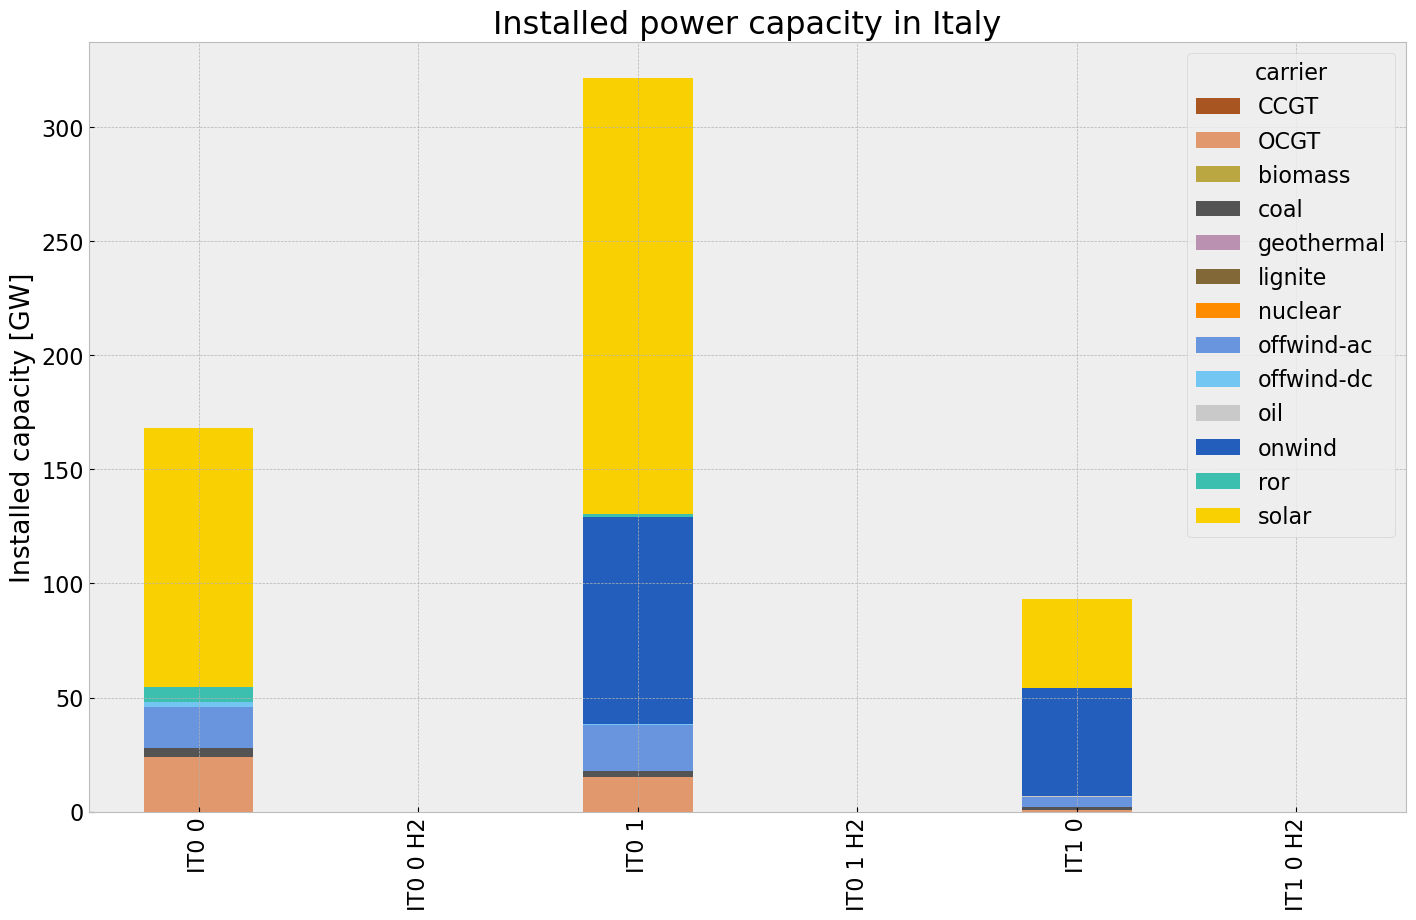

In [148]:
# consolidated istalled cap without load_shedding

capacities_inv = n1.generators.groupby(['bus', 'carrier']).p_nom_opt.sum()
capacities_inv.fillna(0, inplace=True)
gen_1 = (capacities_inv.unstack()/1000).drop(columns=['load'],inplace=False)


cap_inv = inst_cap_table(n1, color_cap)


## Generation

<Figure size 640x480 with 0 Axes>

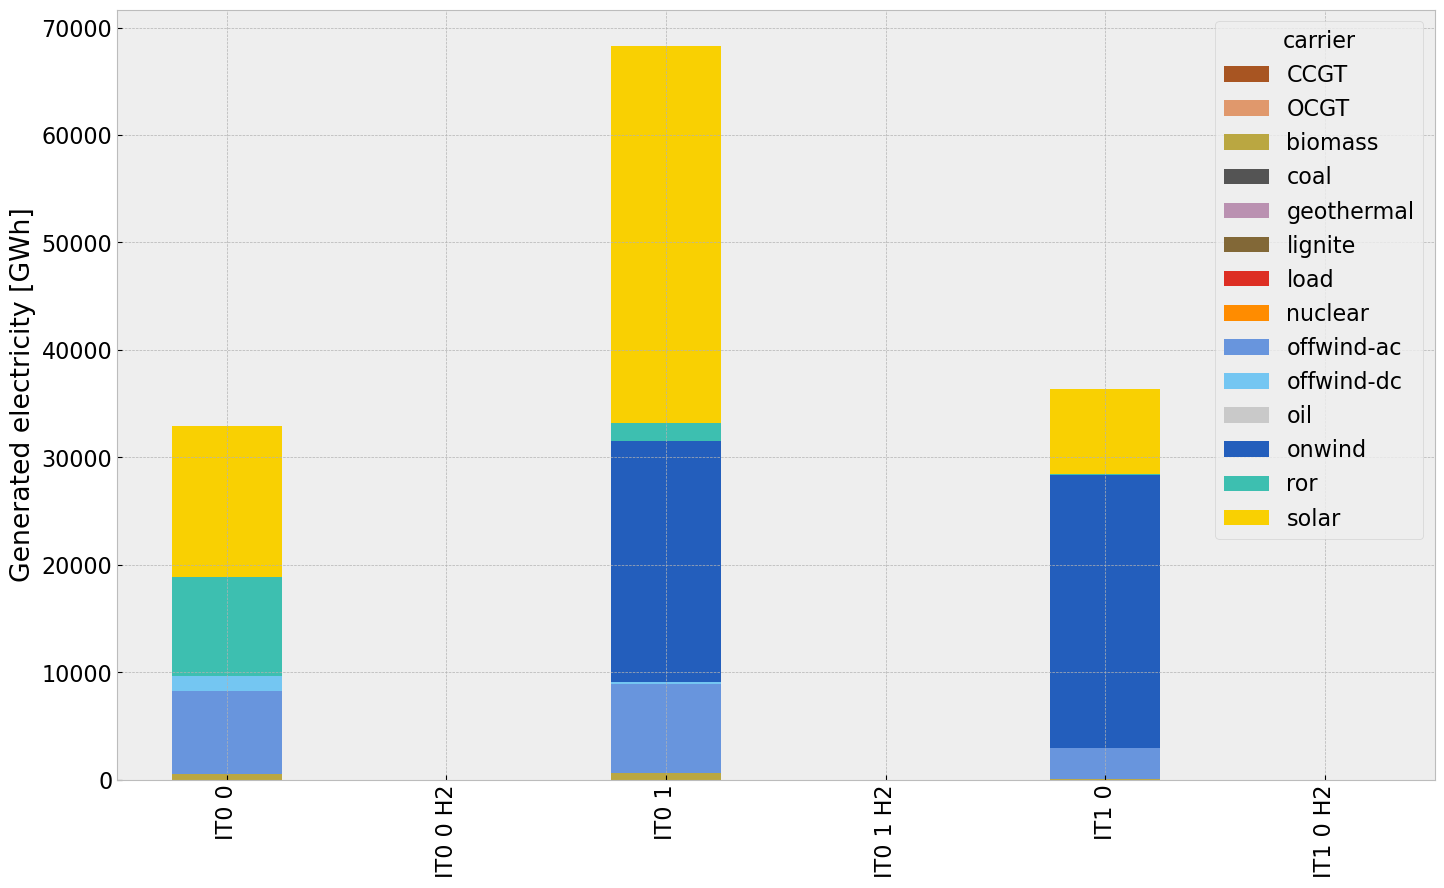

In [149]:
# consolidated generation table
carrier = n1.generators.carrier.unique()
df_tot_generation = n1.generators_t.p.sum()

generations = pd.Series(index = n1.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().index)

for r in region:
    for tech in carrier:
        key = f"{r} {tech}"
        if key in df_tot_generation.index:
            try:
                generations.loc[r, tech] = df_tot_generation[key]
                #print(generations.loc[r, tech])
            except KeyError:
                print('error')
                
generations.fillna(0, inplace=True)
gen_inv = generations.unstack()/1000#Gwh


gen_inv = gen_power_table(n1,colors_gen_table)



## Snapshot

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  links = n.links_t.p1.groupby(n.links.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time = pd.date_range(start=start_date, end=end_date, freq='3H')

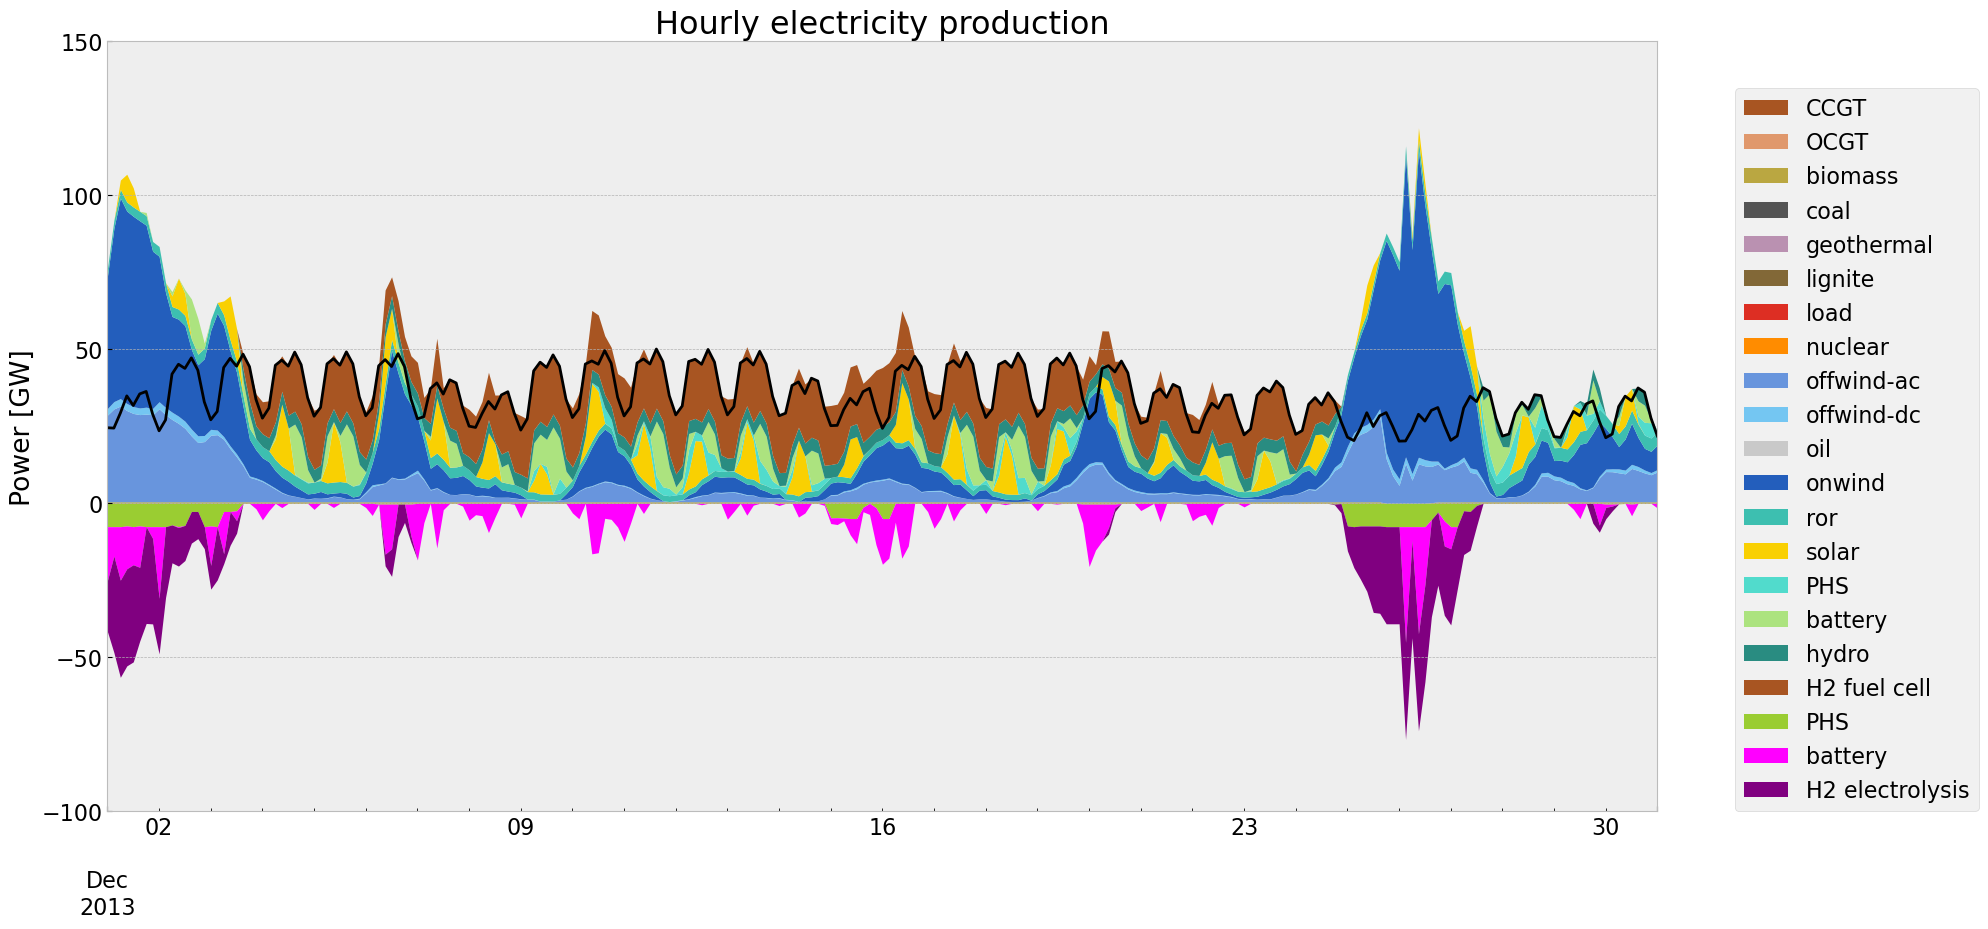

In [186]:
gen_curve(n1, '2013-12-01', '2013-12-31', colors_gen)

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\3910748984.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\3910748984.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  links = n.links_t.p1.groupby(n.links.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\3910748984.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\3910748984.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time = pd.date_range(start=start_date, end=end_date, freq='3H')

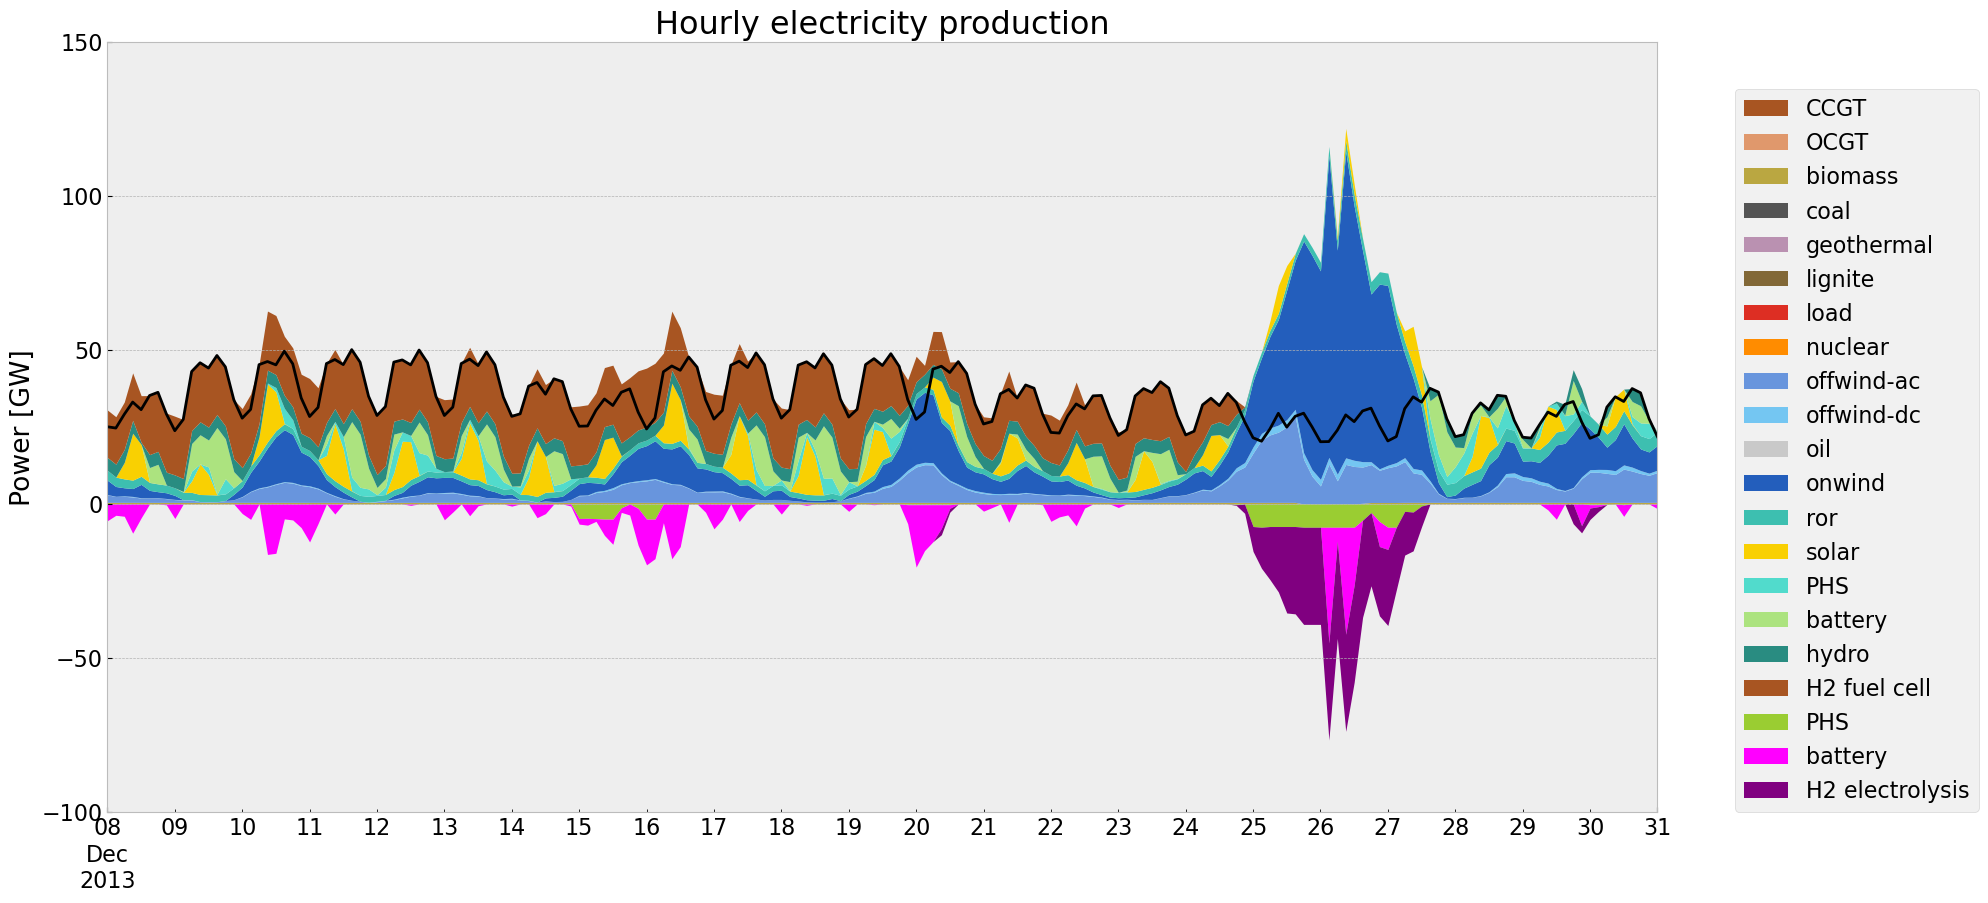

In [151]:
gen_curve(n1, '2013-06-1', '2013-06-30', colors_gen)

## Storage

carrier     PHS    battery   hydro
bus                               
IT0 0    4.9359   7.231472  3.5108
IT0 1    2.3960  37.396925  0.6060
IT1 0    0.2400   9.733295  0.0780

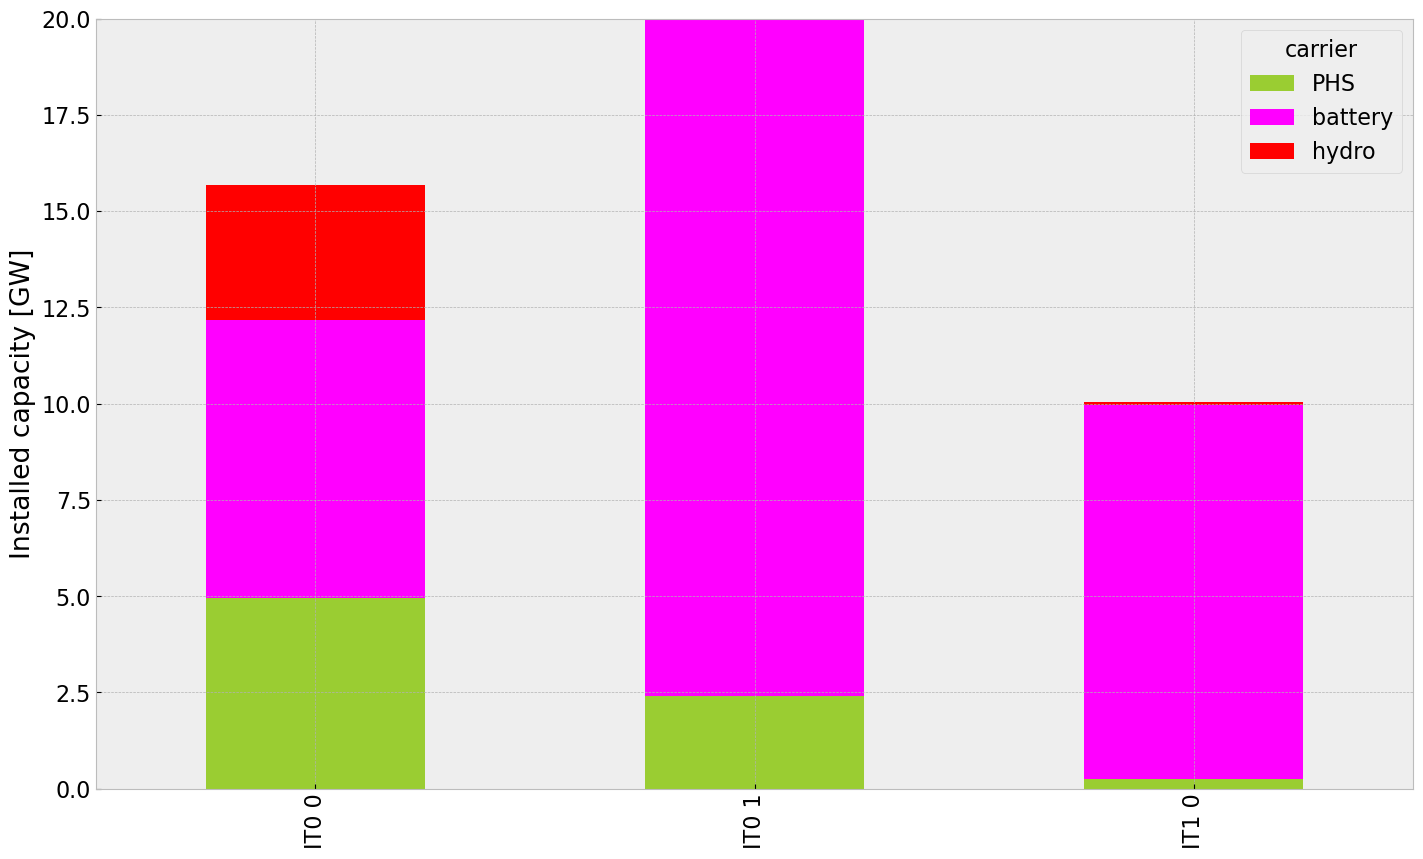

In [152]:
inst_store_table(n1)

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2765649672.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  soc = n.storage_units_t.state_of_charge.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)


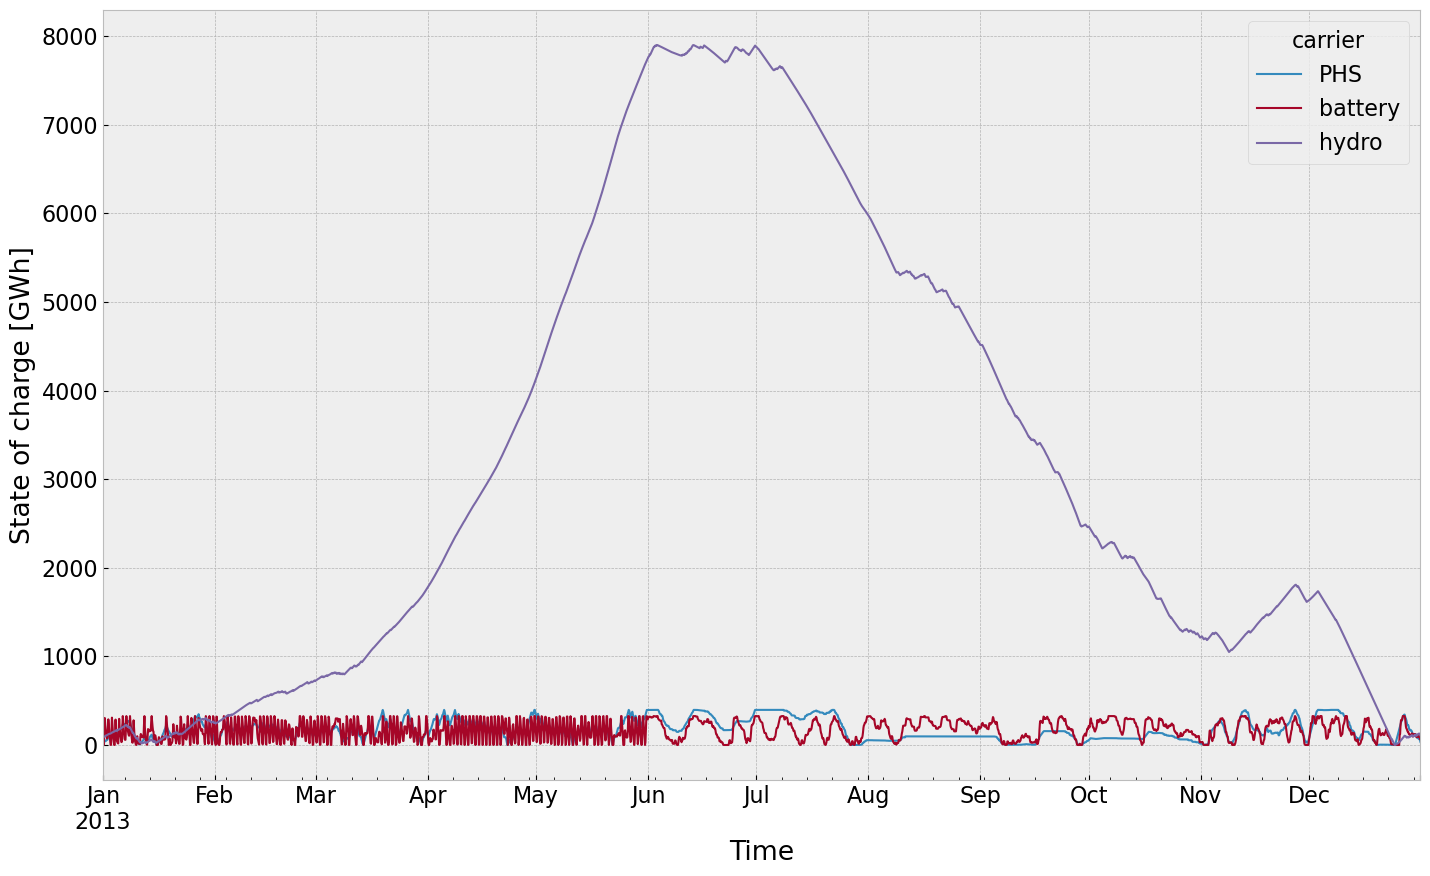

In [153]:
state_of_charge_plot(n1)


## Electricity Price


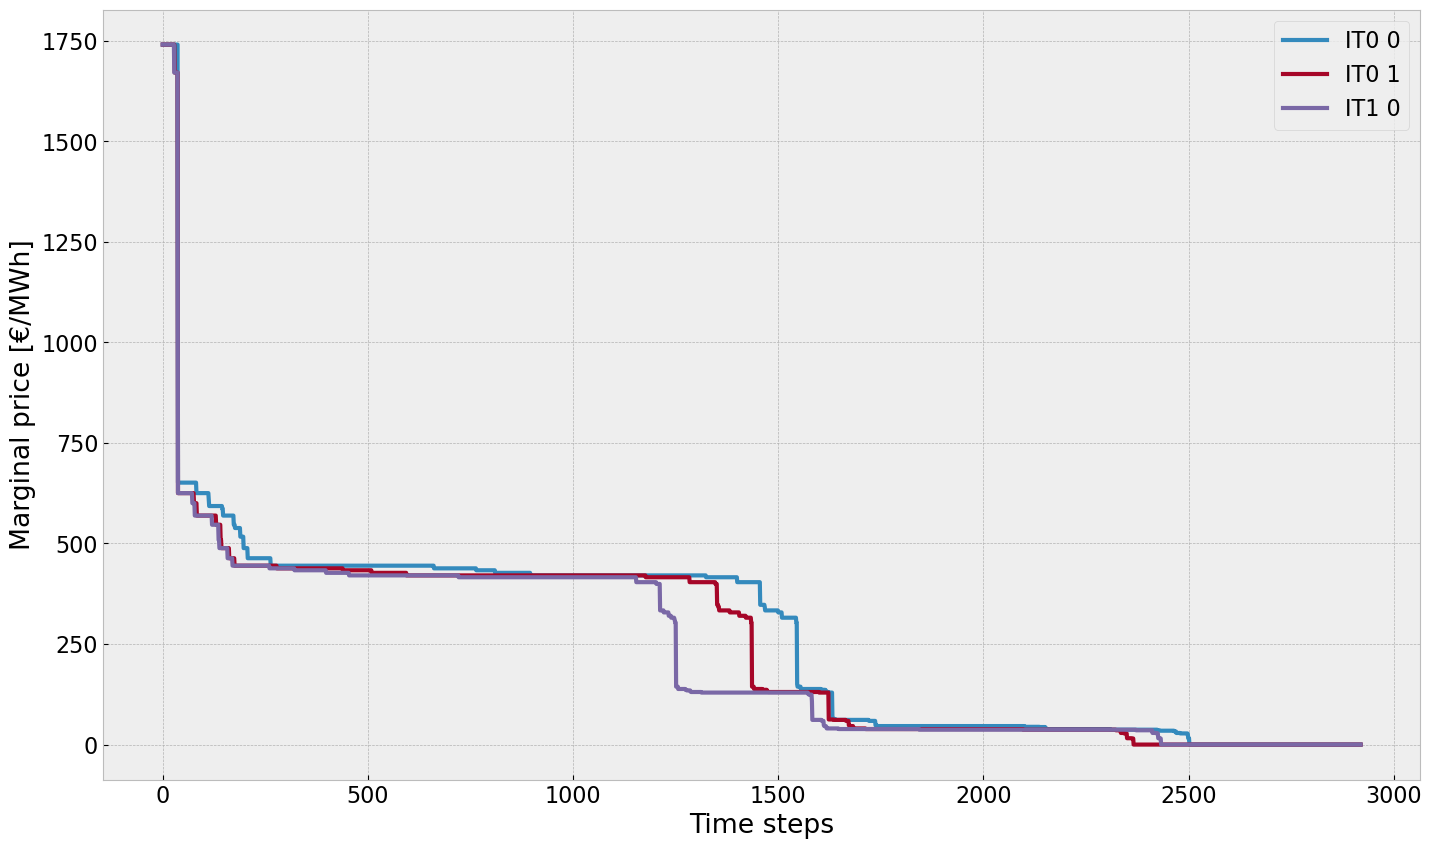

In [154]:
price_dur_curve_plot(n1)



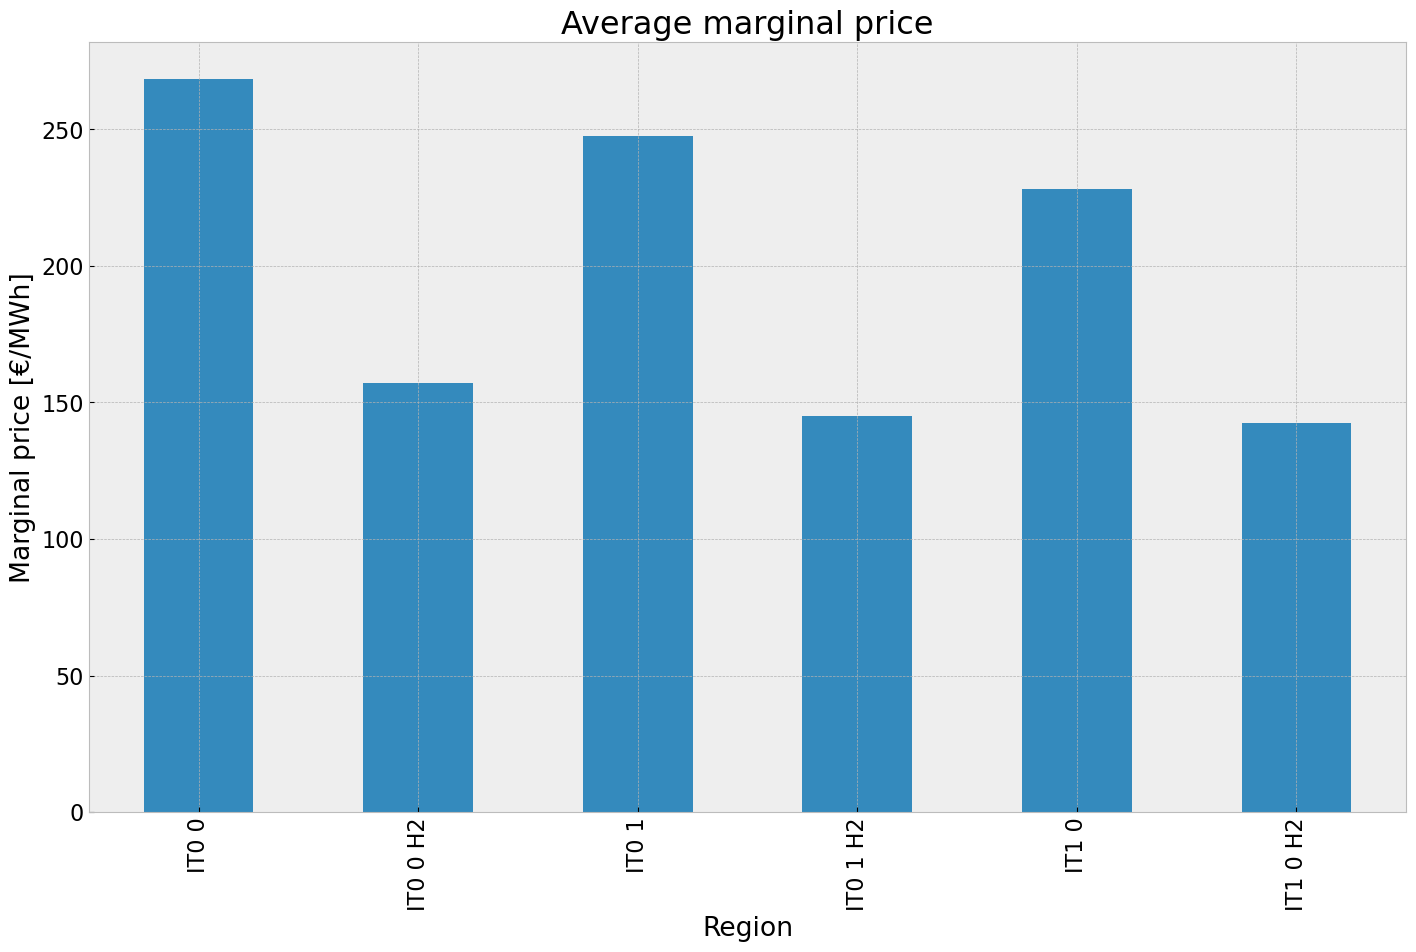

In [155]:
price_regions_table(n1)

## 2. Scenario: perfect foresight with no additional investment

In [156]:
#copy network
n2=n1.copy()

#set the optimal capacity of generators from the base scenario as the new minimum capacity 
for index, value in n2.generators.p_nom_extendable.items():
    if value:  
        n2.generators.at[index, 'p_nom_min'] = n.generators.at[index, 'p_nom_opt']
        n2.generators.at[index, 'p_nom_max'] = n.generators.at[index, 'p_nom_opt']

#set the optimal capacity of storage units from the base scenario as the new minimum capacity 
for index, value in n2.storage_units.p_nom_extendable.items():
    if value:  
        n2.storage_units.at[index, 'p_nom_min'] = n.storage_units.at[index, 'p_nom_opt']
        n2.storage_units.at[index, 'p_nom_max'] = n.storage_units.at[index, 'p_nom_opt']

#set the optimal capacity of lines from the base scenario as the new minimum capacity 
for index, value in n2.lines.s_nom_extendable.items():
    if value:  
        n2.lines.at[index, 's_nom_min'] = n.lines.at[index, 's_nom_opt']
        n2.lines.at[index, 's_nom_max'] = n.lines.at[index, 's_nom_opt']

In [157]:
n2.generators[n2.generators['carrier']=='solar']

carrier    bus      p_nom_min  p_nom  p_nom_extendable  \
Generator                                                            
IT0 0 solar   solar  IT0 0   85237.699330    0.0              True   
IT0 1 solar   solar  IT0 1  155226.577048    0.0              True   
IT1 0 solar   solar  IT1 0   26268.300452    0.0              True   

             efficiency  marginal_cost  capital_cost      p_nom_max  \
Generator                                                             
IT0 0 solar         1.0       0.019877  39296.472708   85237.699330   
IT0 1 solar         1.0       0.019646  39296.472708  155226.577048   
IT1 0 solar         1.0       0.020787  39296.472708   26268.300452   

                   weight control  p_max_pu  sign  build_year  min_up_time  \
Generator                                                                    
IT0 0 solar  56105.496479               1.0   1.0           0            0   
IT0 1 solar  53198.633823               1.0   1.0           0            0   
IT1 0 solar   6273.290436               1.0   1.0           0            0   

             min_down_time  up_time_before  down_time_before      p_nom_opt  \
Generator                                                                     
IT0 0 solar              0               1                 0  113312.739112   
IT0 1 solar              0               1                 0  190955.136332   
IT1 0 solar              0               1                 0   38931.424726   

            type  p_nom_mod  p_min_pu  p_set  q_set  marginal_cost_quadratic  \
Generator                                                                      
IT0 0 solar             0.0       0.0    0.0    0.0                      0.0   
IT0 1 solar             0.0       0.0    0.0    0.0                      0.0   
IT1 0 solar             0.0       0.0    0.0    0.0                      0.0   

             lifetime  committable  start_up_cost  shut_down_cost  \
Generator                                                           
IT0 0 solar       inf        False            0.0             0.0   
IT0 1 solar       inf        False            0.0             0.0   
IT1 0 solar       inf        False            0.0             0.0   

             stand_by_cost  ramp_limit_up  ramp_limit_down  \
Generator                                                    
IT0 0 solar            0.0            NaN              NaN   
IT0 1 solar            0.0            NaN              NaN   
IT1 0 solar            0.0            NaN              NaN   

             ramp_limit_start_up  ramp_limit_shut_down  
Generator                                               
IT0 0 solar                  1.0                   1.0  
IT0 1 solar                  1.0                   1.0  
IT1 0 solar                  1.0                   1.0

In [158]:
n2.optimize.create_model()

Linopy LP model

Variables:
----------
 * Generator-p_nom (Generator-ext)
 * Line-s_nom (Line-ext)
 * Link-p_nom (Link-ext)
 * Store-e_nom (Store-ext)
 * StorageUnit-p_nom (StorageUnit-ext)
 * Generator-p (snapshot, Generator)
 * Line-s (snapshot, Line)
 * Link-p (snapshot, Link)
 * Store-e (snapshot, Store)
 * StorageUnit-p_dispatch (snapshot, StorageUnit)
 * StorageUnit-p_store (snapshot, StorageUnit)
 * StorageUnit-state_of_charge (snapshot, StorageUnit)
 * StorageUnit-spill (snapshot, StorageUnit)
 * Store-p (snapshot, Store)
 * objective_constant

Constraints:
------------
 * Generator-ext-p_nom-lower (Generator-ext)
 * Generator-ext-p_nom-upper (Generator-ext)
 * Line-ext-s_nom-lower (Line-ext)
 * Line-ext-s_nom-upper (Line-ext)
 * Link-ext-p_nom-lower (Link-ext)
 * Link-ext-p_nom-upper (Link-ext)
 * Store-ext-e_nom-lower (Store-ext)
 * Store-ext-e_nom-upper (Store-ext)
 * StorageUnit-ext-p_nom-lower (StorageUnit-ext)
 * StorageUnit-ext-p_nom-upper (StorageUnit-ext)
 * Generator-

In [159]:
n2.optimize(solver_name ='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 15/15 [00:00<00:00, 15.44it/s]
INFO:linopy.io: Writing time: 6.5s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-z73o3d_c.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-z73o3d_c.lp


Reading time = 1.98 seconds


INFO:gurobipy:Reading time = 1.98 seconds


obj: 531489 rows, 256950 columns, 997225 nonzeros


INFO:gurobipy:obj: 531489 rows, 256950 columns, 997225 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 531489 rows, 256950 columns and 997225 nonzeros


INFO:gurobipy:Optimize a model with 531489 rows, 256950 columns and 997225 nonzeros


Model fingerprint: 0x52a8ed7f


INFO:gurobipy:Model fingerprint: 0x52a8ed7f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+00, 2e+09]


INFO:gurobipy:  Bounds range     [4e+00, 2e+09]


  RHS range        [3e+00, 1e+09]


INFO:gurobipy:  RHS range        [3e+00, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 455602 rows and 98949 columns


INFO:gurobipy:Presolve removed 455602 rows and 98949 columns


Presolve time: 0.62s


INFO:gurobipy:Presolve time: 0.62s


Presolved: 75887 rows, 158001 columns, 324398 nonzeros


INFO:gurobipy:Presolved: 75887 rows, 158001 columns, 324398 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.07s


INFO:gurobipy:Ordering time: 0.07s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 10


INFO:gurobipy: Dense cols : 10


 AA' NZ     : 1.752e+05


INFO:gurobipy: AA' NZ     : 1.752e+05


 Factor NZ  : 1.383e+06 (roughly 100 MB of memory)


INFO:gurobipy: Factor NZ  : 1.383e+06 (roughly 100 MB of memory)


 Factor Ops : 3.733e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.733e+07 (less than 1 second per iteration)


 Threads    : 3


INFO:gurobipy: Threads    : 3


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.76481551e+18 -5.23743214e+18  6.09e+08 4.74e+06  3.34e+14     1s


INFO:gurobipy:   0   2.76481551e+18 -5.23743214e+18  6.09e+08 4.74e+06  3.34e+14     1s


   1   1.42858412e+18 -9.01438232e+17  3.10e+08 3.80e+05  1.39e+14     1s


INFO:gurobipy:   1   1.42858412e+18 -9.01438232e+17  3.10e+08 3.80e+05  1.39e+14     1s


   2   1.16385201e+18 -4.62381133e+17  2.54e+08 1.82e+05  1.15e+14     1s


INFO:gurobipy:   2   1.16385201e+18 -4.62381133e+17  2.54e+08 1.82e+05  1.15e+14     1s


   3   1.03060808e+17 -2.14963134e+17  1.36e+07 5.11e+04  7.86e+12     1s


INFO:gurobipy:   3   1.03060808e+17 -2.14963134e+17  1.36e+07 5.11e+04  7.86e+12     1s


   4   2.85428908e+16 -1.76602108e+16  8.51e+04 7.93e+02  1.97e+11     1s


INFO:gurobipy:   4   2.85428908e+16 -1.76602108e+16  8.51e+04 7.93e+02  1.97e+11     1s


   5   2.06088297e+15 -1.67643563e+15  2.23e+03 3.99e+01  1.29e+10     2s


INFO:gurobipy:   5   2.06088297e+15 -1.67643563e+15  2.23e+03 3.99e+01  1.29e+10     2s


   6   2.27723993e+14 -1.99662299e+14  2.33e+02 3.72e+00  1.41e+09     2s


INFO:gurobipy:   6   2.27723993e+14 -1.99662299e+14  2.33e+02 3.72e+00  1.41e+09     2s


   7   1.12950519e+13 -1.24412267e+13  1.08e+01 1.88e-01  7.66e+07     2s


INFO:gurobipy:   7   1.12950519e+13 -1.24412267e+13  1.08e+01 1.88e-01  7.66e+07     2s


   8   5.91196427e+12 -1.78111420e+12  5.51e+00 2.39e-02  2.45e+07     2s


INFO:gurobipy:   8   5.91196427e+12 -1.78111420e+12  5.51e+00 2.39e-02  2.45e+07     2s


   9   3.48751744e+12 -7.68767058e+11  3.19e+00 8.59e-03  1.35e+07     2s


INFO:gurobipy:   9   3.48751744e+12 -7.68767058e+11  3.19e+00 8.59e-03  1.35e+07     2s


  10   2.18862707e+12 -4.21472221e+11  1.95e+00 5.05e-03  8.28e+06     2s


INFO:gurobipy:  10   2.18862707e+12 -4.21472221e+11  1.95e+00 5.05e-03  8.28e+06     2s


  11   1.15458503e+12 -1.39612978e+11  9.30e-01 2.37e-03  4.10e+06     2s


INFO:gurobipy:  11   1.15458503e+12 -1.39612978e+11  9.30e-01 2.37e-03  4.10e+06     2s


  12   7.98297980e+11  7.39755229e+10  5.55e-01 9.91e-04  2.29e+06     3s


INFO:gurobipy:  12   7.98297980e+11  7.39755229e+10  5.55e-01 9.91e-04  2.29e+06     3s


  13   6.27597608e+11  1.75300003e+11  3.63e-01 5.13e-04  1.43e+06     3s


INFO:gurobipy:  13   6.27597608e+11  1.75300003e+11  3.63e-01 5.13e-04  1.43e+06     3s


  14   5.32968115e+11  2.28274312e+11  2.54e-01 3.10e-04  9.65e+05     3s


INFO:gurobipy:  14   5.32968115e+11  2.28274312e+11  2.54e-01 3.10e-04  9.65e+05     3s


  15   4.80790669e+11  2.58028112e+11  1.89e-01 2.08e-04  7.05e+05     3s


INFO:gurobipy:  15   4.80790669e+11  2.58028112e+11  1.89e-01 2.08e-04  7.05e+05     3s


  16   4.63327824e+11  2.70733333e+11  1.66e-01 1.69e-04  6.10e+05     3s


INFO:gurobipy:  16   4.63327824e+11  2.70733333e+11  1.66e-01 1.69e-04  6.10e+05     3s


  17   4.38127410e+11  2.85398202e+11  1.33e-01 1.29e-04  4.83e+05     3s


INFO:gurobipy:  17   4.38127410e+11  2.85398202e+11  1.33e-01 1.29e-04  4.83e+05     3s


  18   4.11734101e+11  2.97450998e+11  9.91e-02 9.72e-05  3.62e+05     3s


INFO:gurobipy:  18   4.11734101e+11  2.97450998e+11  9.91e-02 9.72e-05  3.62e+05     3s


  19   3.91999660e+11  3.09014429e+11  7.37e-02 6.77e-05  2.63e+05     3s


INFO:gurobipy:  19   3.91999660e+11  3.09014429e+11  7.37e-02 6.77e-05  2.63e+05     3s


  20   3.83955142e+11  3.12570398e+11  6.32e-02 5.89e-05  2.26e+05     4s


INFO:gurobipy:  20   3.83955142e+11  3.12570398e+11  6.32e-02 5.89e-05  2.26e+05     4s


  21   3.67292150e+11  3.19110746e+11  4.00e-02 4.48e-05  1.53e+05     4s


INFO:gurobipy:  21   3.67292150e+11  3.19110746e+11  4.00e-02 4.48e-05  1.53e+05     4s


  22   3.63338736e+11  3.23365061e+11  3.42e-02 3.57e-05  1.27e+05     4s


INFO:gurobipy:  22   3.63338736e+11  3.23365061e+11  3.42e-02 3.57e-05  1.27e+05     4s


  23   3.57382934e+11  3.26556050e+11  2.62e-02 2.87e-05  9.76e+04     4s


INFO:gurobipy:  23   3.57382934e+11  3.26556050e+11  2.62e-02 2.87e-05  9.76e+04     4s


  24   3.53899996e+11  3.29675995e+11  2.13e-02 2.20e-05  7.67e+04     4s


INFO:gurobipy:  24   3.53899996e+11  3.29675995e+11  2.13e-02 2.20e-05  7.67e+04     4s


  25   3.50325916e+11  3.31272338e+11  1.58e-02 1.86e-05  6.03e+04     4s


INFO:gurobipy:  25   3.50325916e+11  3.31272338e+11  1.58e-02 1.86e-05  6.03e+04     4s


  26   3.47666842e+11  3.33084916e+11  1.21e-02 1.47e-05  4.62e+04     5s


INFO:gurobipy:  26   3.47666842e+11  3.33084916e+11  1.21e-02 1.47e-05  4.62e+04     5s


  27   3.45453513e+11  3.34348879e+11  8.92e-03 1.19e-05  3.52e+04     5s


INFO:gurobipy:  27   3.45453513e+11  3.34348879e+11  8.92e-03 1.19e-05  3.52e+04     5s


  28   3.44657273e+11  3.34930861e+11  7.62e-03 1.07e-05  3.08e+04     5s


INFO:gurobipy:  28   3.44657273e+11  3.34930861e+11  7.62e-03 1.07e-05  3.08e+04     5s


  29   3.44495887e+11  3.35268691e+11  7.40e-03 9.96e-06  2.92e+04     5s


INFO:gurobipy:  29   3.44495887e+11  3.35268691e+11  7.40e-03 9.96e-06  2.92e+04     5s


  30   3.43822425e+11  3.35776484e+11  6.33e-03 8.98e-06  2.55e+04     5s


INFO:gurobipy:  30   3.43822425e+11  3.35776484e+11  6.33e-03 8.98e-06  2.55e+04     5s


  31   3.43701251e+11  3.36102706e+11  6.13e-03 8.31e-06  2.41e+04     5s


INFO:gurobipy:  31   3.43701251e+11  3.36102706e+11  6.13e-03 8.31e-06  2.41e+04     5s


  32   3.42900940e+11  3.36734303e+11  4.82e-03 6.94e-06  1.95e+04     5s


INFO:gurobipy:  32   3.42900940e+11  3.36734303e+11  4.82e-03 6.94e-06  1.95e+04     5s


  33   3.42637590e+11  3.37104116e+11  4.37e-03 6.21e-06  1.75e+04     6s


INFO:gurobipy:  33   3.42637590e+11  3.37104116e+11  4.37e-03 6.21e-06  1.75e+04     6s


  34   3.42269711e+11  3.37513712e+11  3.74e-03 5.36e-06  1.51e+04     6s


INFO:gurobipy:  34   3.42269711e+11  3.37513712e+11  3.74e-03 5.36e-06  1.51e+04     6s


  35   3.42127686e+11  3.37791097e+11  3.52e-03 4.79e-06  1.37e+04     6s


INFO:gurobipy:  35   3.42127686e+11  3.37791097e+11  3.52e-03 4.79e-06  1.37e+04     6s


  36   3.41941935e+11  3.38067743e+11  3.24e-03 4.22e-06  1.23e+04     6s


INFO:gurobipy:  36   3.41941935e+11  3.38067743e+11  3.24e-03 4.22e-06  1.23e+04     6s


  37   3.41708341e+11  3.38146057e+11  2.82e-03 4.06e-06  1.13e+04     6s


INFO:gurobipy:  37   3.41708341e+11  3.38146057e+11  2.82e-03 4.06e-06  1.13e+04     6s


  38   3.41584077e+11  3.38282421e+11  2.60e-03 3.77e-06  1.05e+04     6s


INFO:gurobipy:  38   3.41584077e+11  3.38282421e+11  2.60e-03 3.77e-06  1.05e+04     6s


  39   3.41391905e+11  3.38782100e+11  2.27e-03 2.74e-06  8.26e+03     6s


INFO:gurobipy:  39   3.41391905e+11  3.38782100e+11  2.27e-03 2.74e-06  8.26e+03     6s


  40   3.41307327e+11  3.39095631e+11  2.13e-03 2.10e-06  7.00e+03     7s


INFO:gurobipy:  40   3.41307327e+11  3.39095631e+11  2.13e-03 2.10e-06  7.00e+03     7s


  41   3.40889226e+11  3.39387450e+11  1.42e-03 1.43e-06  4.75e+03     7s


INFO:gurobipy:  41   3.40889226e+11  3.39387450e+11  1.42e-03 1.43e-06  4.75e+03     7s


  42   3.40645674e+11  3.39523474e+11  1.01e-03 1.14e-06  3.55e+03     7s


INFO:gurobipy:  42   3.40645674e+11  3.39523474e+11  1.01e-03 1.14e-06  3.55e+03     7s


  43   3.40535897e+11  3.39584462e+11  8.22e-04 1.02e-06  3.01e+03     7s


INFO:gurobipy:  43   3.40535897e+11  3.39584462e+11  8.22e-04 1.02e-06  3.01e+03     7s


  44   3.40434563e+11  3.39734370e+11  6.29e-04 7.15e-07  2.22e+03     7s


INFO:gurobipy:  44   3.40434563e+11  3.39734370e+11  6.29e-04 7.15e-07  2.22e+03     7s


  45   3.40399643e+11  3.39759327e+11  5.64e-04 6.63e-07  2.03e+03     7s


INFO:gurobipy:  45   3.40399643e+11  3.39759327e+11  5.64e-04 6.63e-07  2.03e+03     7s


  46   3.40351208e+11  3.39832422e+11  4.82e-04 5.18e-07  1.64e+03     7s


INFO:gurobipy:  46   3.40351208e+11  3.39832422e+11  4.82e-04 5.18e-07  1.64e+03     7s


  47   3.40269677e+11  3.39879852e+11  3.37e-04 4.24e-07  1.23e+03     8s


INFO:gurobipy:  47   3.40269677e+11  3.39879852e+11  3.37e-04 4.24e-07  1.23e+03     8s


  48   3.40218839e+11  3.39961195e+11  2.48e-04 2.58e-07  8.16e+02     8s


INFO:gurobipy:  48   3.40218839e+11  3.39961195e+11  2.48e-04 2.58e-07  8.16e+02     8s


  49   3.40179536e+11  3.39984341e+11  1.76e-04 2.11e-07  6.18e+02     8s


INFO:gurobipy:  49   3.40179536e+11  3.39984341e+11  1.76e-04 2.11e-07  6.18e+02     8s


  50   3.40170571e+11  3.40000377e+11  1.60e-04 1.81e-07  5.39e+02     8s


INFO:gurobipy:  50   3.40170571e+11  3.40000377e+11  1.60e-04 1.81e-07  5.39e+02     8s


  51   3.40153535e+11  3.40011796e+11  1.26e-04 1.59e-07  4.49e+02     8s


INFO:gurobipy:  51   3.40153535e+11  3.40011796e+11  1.26e-04 1.59e-07  4.49e+02     8s


  52   3.40142010e+11  3.40023372e+11  1.01e-04 1.37e-07  3.76e+02     8s


INFO:gurobipy:  52   3.40142010e+11  3.40023372e+11  1.01e-04 1.37e-07  3.76e+02     8s


  53   3.40133904e+11  3.40033542e+11  8.54e-05 1.17e-07  3.18e+02     9s


INFO:gurobipy:  53   3.40133904e+11  3.40033542e+11  8.54e-05 1.17e-07  3.18e+02     9s


  54   3.40124113e+11  3.40036039e+11  6.45e-05 1.12e-07  2.79e+02     9s


INFO:gurobipy:  54   3.40124113e+11  3.40036039e+11  6.45e-05 1.12e-07  2.79e+02     9s


  55   3.40112082e+11  3.40041597e+11  4.11e-05 1.01e-07  2.23e+02     9s


INFO:gurobipy:  55   3.40112082e+11  3.40041597e+11  4.11e-05 1.01e-07  2.23e+02     9s


  56   3.40108874e+11  3.40049666e+11  3.38e-05 8.58e-08  1.87e+02     9s


INFO:gurobipy:  56   3.40108874e+11  3.40049666e+11  3.38e-05 8.58e-08  1.87e+02     9s


  57   3.40099967e+11  3.40060090e+11  1.15e-05 6.51e-08  1.26e+02    10s


INFO:gurobipy:  57   3.40099967e+11  3.40060090e+11  1.15e-05 6.51e-08  1.26e+02    10s


  58   3.40096138e+11  3.40077785e+11  3.95e-06 2.98e-08  5.81e+01    10s


INFO:gurobipy:  58   3.40096138e+11  3.40077785e+11  3.95e-06 2.98e-08  5.81e+01    10s


  59   3.40094419e+11  3.40081719e+11  9.56e-07 2.28e-08  4.02e+01    10s


INFO:gurobipy:  59   3.40094419e+11  3.40081719e+11  9.56e-07 2.28e-08  4.02e+01    10s


  60   3.40093953e+11  3.40090945e+11  2.29e-07 8.38e-09  9.52e+00    10s


INFO:gurobipy:  60   3.40093953e+11  3.40090945e+11  2.29e-07 8.38e-09  9.52e+00    10s


  61   3.40093864e+11  3.40091848e+11  1.38e-07 3.07e-09  6.38e+00    10s


INFO:gurobipy:  61   3.40093864e+11  3.40091848e+11  1.38e-07 3.07e-09  6.38e+00    10s


  62   3.40093826e+11  3.40092361e+11  9.19e-08 2.19e-09  4.64e+00    10s


INFO:gurobipy:  62   3.40093826e+11  3.40092361e+11  9.19e-08 2.19e-09  4.64e+00    10s


  63   3.40093802e+11  3.40092724e+11  6.45e-08 8.38e-09  3.41e+00    11s


INFO:gurobipy:  63   3.40093802e+11  3.40092724e+11  6.45e-08 8.38e-09  3.41e+00    11s


  64   3.40093792e+11  3.40093014e+11  5.39e-08 1.58e-08  2.46e+00    11s


INFO:gurobipy:  64   3.40093792e+11  3.40093014e+11  5.39e-08 1.58e-08  2.46e+00    11s


  65   3.40093783e+11  3.40093309e+11  4.64e-08 1.82e-09  1.50e+00    11s


INFO:gurobipy:  65   3.40093783e+11  3.40093309e+11  4.64e-08 1.82e-09  1.50e+00    11s


  66   3.40093764e+11  3.40093477e+11  2.97e-08 1.78e-09  9.07e-01    11s


INFO:gurobipy:  66   3.40093764e+11  3.40093477e+11  2.97e-08 1.78e-09  9.07e-01    11s


  67   3.40093756e+11  3.40093552e+11  2.27e-08 1.86e-09  6.45e-01    11s


INFO:gurobipy:  67   3.40093756e+11  3.40093552e+11  2.27e-08 1.86e-09  6.45e-01    11s


  68   3.40093749e+11  3.40093638e+11  1.72e-08 1.99e-09  3.54e-01    11s


INFO:gurobipy:  68   3.40093749e+11  3.40093638e+11  1.72e-08 1.99e-09  3.54e-01    11s


  69   3.40093741e+11  3.40093668e+11  1.11e-08 1.94e-09  2.33e-01    11s


INFO:gurobipy:  69   3.40093741e+11  3.40093668e+11  1.11e-08 1.94e-09  2.33e-01    11s


  70   3.40093738e+11  3.40093675e+11  7.80e-09 1.86e-09  2.00e-01    12s


INFO:gurobipy:  70   3.40093738e+11  3.40093675e+11  7.80e-09 1.86e-09  2.00e-01    12s


  71   3.40093735e+11  3.40093677e+11  5.33e-09 2.79e-09  1.83e-01    12s


INFO:gurobipy:  71   3.40093735e+11  3.40093677e+11  5.33e-09 2.79e-09  1.83e-01    12s


  72   3.40093733e+11  3.40093703e+11  3.30e-09 1.47e-09  9.50e-02    12s


INFO:gurobipy:  72   3.40093733e+11  3.40093703e+11  3.30e-09 1.47e-09  9.50e-02    12s


  73   3.40093732e+11  3.40093706e+11  2.58e-09 1.30e-08  8.36e-02    12s


INFO:gurobipy:  73   3.40093732e+11  3.40093706e+11  2.58e-09 1.30e-08  8.36e-02    12s


  74   3.40093731e+11  3.40093714e+11  2.04e-09 1.96e-09  5.47e-02    12s


INFO:gurobipy:  74   3.40093731e+11  3.40093714e+11  2.04e-09 1.96e-09  5.47e-02    12s


  75   3.40093731e+11  3.40093717e+11  1.86e-09 7.45e-09  4.44e-02    13s


INFO:gurobipy:  75   3.40093731e+11  3.40093717e+11  1.86e-09 7.45e-09  4.44e-02    13s


  76   3.40093730e+11  3.40093721e+11  1.86e-09 4.66e-09  3.00e-02    13s


INFO:gurobipy:  76   3.40093730e+11  3.40093721e+11  1.86e-09 4.66e-09  3.00e-02    13s


  77   3.40093729e+11  3.40093722e+11  1.86e-09 5.59e-09  2.31e-02    13s


INFO:gurobipy:  77   3.40093729e+11  3.40093722e+11  1.86e-09 5.59e-09  2.31e-02    13s


  78   3.40093729e+11  3.40093725e+11  1.86e-09 1.94e-09  1.44e-02    13s


INFO:gurobipy:  78   3.40093729e+11  3.40093725e+11  1.86e-09 1.94e-09  1.44e-02    13s


  79   3.40093729e+11  3.40093727e+11  1.86e-09 1.74e-09  5.29e-03    14s


INFO:gurobipy:  79   3.40093729e+11  3.40093727e+11  1.86e-09 1.74e-09  5.29e-03    14s


  80   3.40093729e+11  3.40093728e+11  1.86e-09 1.12e-08  1.25e-03    14s


INFO:gurobipy:  80   3.40093729e+11  3.40093728e+11  1.86e-09 1.12e-08  1.25e-03    14s


  81   3.40093729e+11  3.40093729e+11  1.86e-09 1.38e-09  6.39e-04    14s


INFO:gurobipy:  81   3.40093729e+11  3.40093729e+11  1.86e-09 1.38e-09  6.39e-04    14s


INFO:gurobipy:


Barrier solved model in 81 iterations and 14.07 seconds (5.75 work units)


INFO:gurobipy:Barrier solved model in 81 iterations and 14.07 seconds (5.75 work units)


Optimal objective 3.40093729e+11


INFO:gurobipy:Optimal objective 3.40093729e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    1406 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:    1406 DPushes remaining with DInf 0.0000000e+00                14s


      50 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:      50 DPushes remaining with DInf 0.0000000e+00                15s


       0 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   29796 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:   29796 PPushes remaining with PInf 0.0000000e+00                15s


   19411 PPushes remaining with PInf 8.8951429e-06                20s


INFO:gurobipy:   19411 PPushes remaining with PInf 8.8951429e-06                20s


       0 PPushes remaining with PInf 0.0000000e+00                22s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                22s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.7211003e-02     22s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.7211003e-02     22s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   31184    3.4009373e+11   0.000000e+00   1.721033e-02     22s


INFO:gurobipy:   31184    3.4009373e+11   0.000000e+00   1.721033e-02     22s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   31187    3.4009373e+11   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:   31187    3.4009373e+11   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:


Solved in 31187 iterations and 22.27 seconds (12.95 work units)


INFO:gurobipy:Solved in 31187 iterations and 22.27 seconds (12.95 work units)


Optimal objective  3.400937287e+11


INFO:gurobipy:Optimal objective  3.400937287e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 256950 primals, 531489 duals
Objective: 3.40e+11
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper,

('ok', 'optimal')

In [160]:
tot_cos_noinv=n2.objective/1e9 #billion €
system_cost_noinv = system_cost(n2) #million €/a
marg_price_region_noinv = n2.buses_t.marginal_price.mean()
stat_noinv = n2.statistics()

## Installed Capacity

Since expansion is not allowed in this scenario, the installed capacity will equal to that of the base scenario.

In [161]:
n2.generators[n2.generators['carrier']=='solar']

carrier    bus      p_nom_min  p_nom  p_nom_extendable  \
Generator                                                            
IT0 0 solar   solar  IT0 0   85237.699330    0.0              True   
IT0 1 solar   solar  IT0 1  155226.577048    0.0              True   
IT1 0 solar   solar  IT1 0   26268.300452    0.0              True   

             efficiency  marginal_cost  capital_cost      p_nom_max  \
Generator                                                             
IT0 0 solar         1.0       0.019877  39296.472708   85237.699330   
IT0 1 solar         1.0       0.019646  39296.472708  155226.577048   
IT1 0 solar         1.0       0.020787  39296.472708   26268.300452   

                   weight control  p_max_pu  sign  build_year  min_up_time  \
Generator                                                                    
IT0 0 solar  56105.496479               1.0   1.0           0            0   
IT0 1 solar  53198.633823               1.0   1.0           0            0   
IT1 0 solar   6273.290436               1.0   1.0           0            0   

             min_down_time  up_time_before  down_time_before      p_nom_opt  \
Generator                                                                     
IT0 0 solar              0               1                 0   85237.699329   
IT0 1 solar              0               1                 0  155226.577048   
IT1 0 solar              0               1                 0   26268.300452   

            type  p_nom_mod  p_min_pu  p_set  q_set  marginal_cost_quadratic  \
Generator                                                                      
IT0 0 solar             0.0       0.0    0.0    0.0                      0.0   
IT0 1 solar             0.0       0.0    0.0    0.0                      0.0   
IT1 0 solar             0.0       0.0    0.0    0.0                      0.0   

             lifetime  committable  start_up_cost  shut_down_cost  \
Generator                                                           
IT0 0 solar       inf        False            0.0             0.0   
IT0 1 solar       inf        False            0.0             0.0   
IT1 0 solar       inf        False            0.0             0.0   

             stand_by_cost  ramp_limit_up  ramp_limit_down  \
Generator                                                    
IT0 0 solar            0.0            NaN              NaN   
IT0 1 solar            0.0            NaN              NaN   
IT1 0 solar            0.0            NaN              NaN   

             ramp_limit_start_up  ramp_limit_shut_down  
Generator                                               
IT0 0 solar                  1.0                   1.0  
IT0 1 solar                  1.0                   1.0  
IT1 0 solar                  1.0                   1.0

<Figure size 640x480 with 0 Axes>

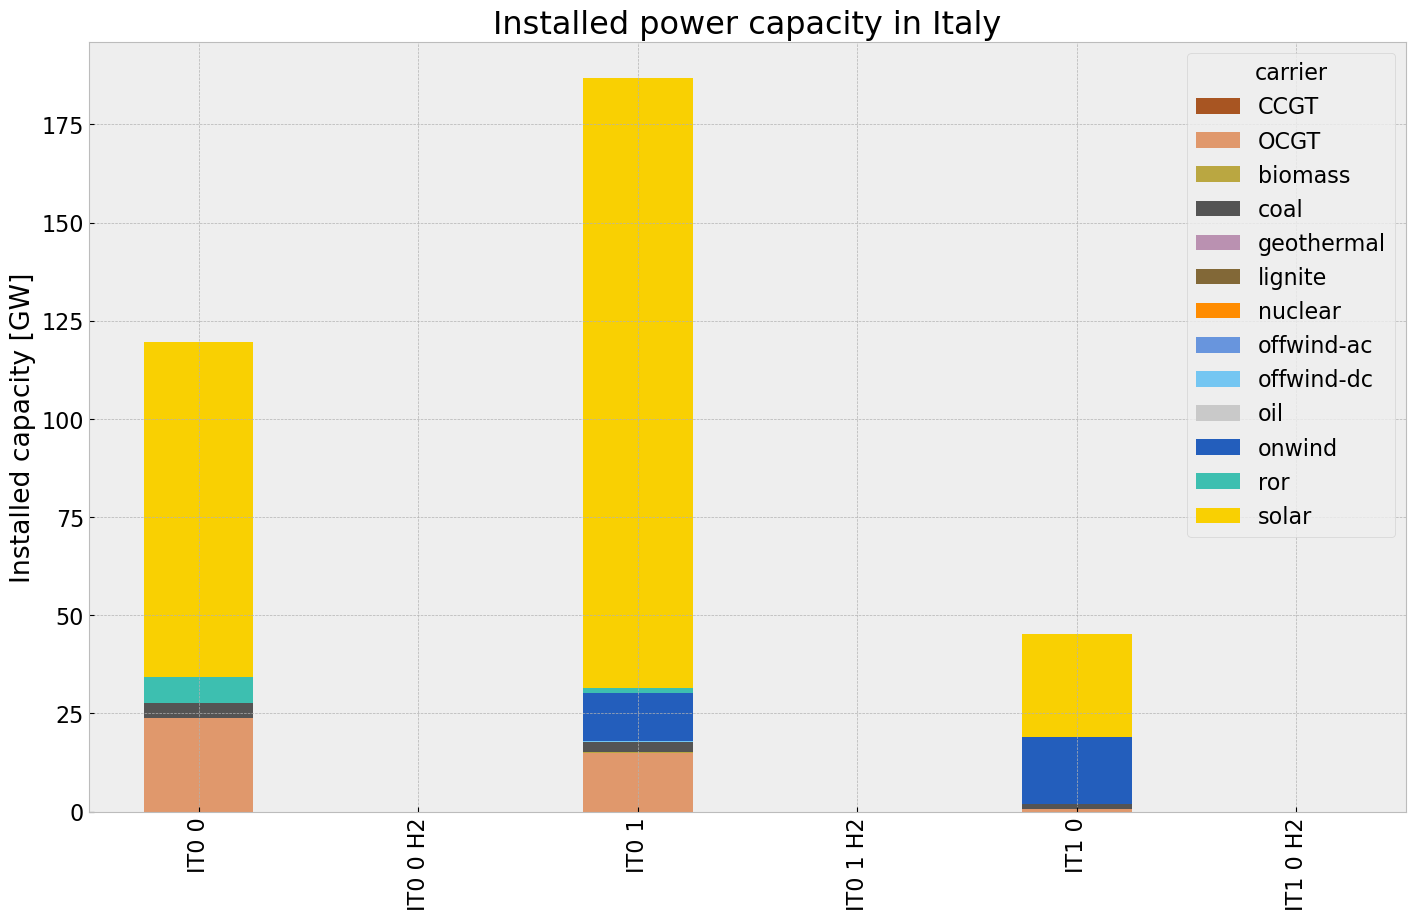

In [162]:
# consolidated istalled cap without load_shedding

capacities_noinv = n2.generators.groupby(['bus', 'carrier']).p_nom_opt.sum()
capacities_noinv.fillna(0, inplace=True)
gen = (capacities_noinv.unstack()/1000).drop(columns=['load'],inplace=False)


cap_noinv = inst_cap_table(n2, color_cap)



## Generation

<Figure size 640x480 with 0 Axes>

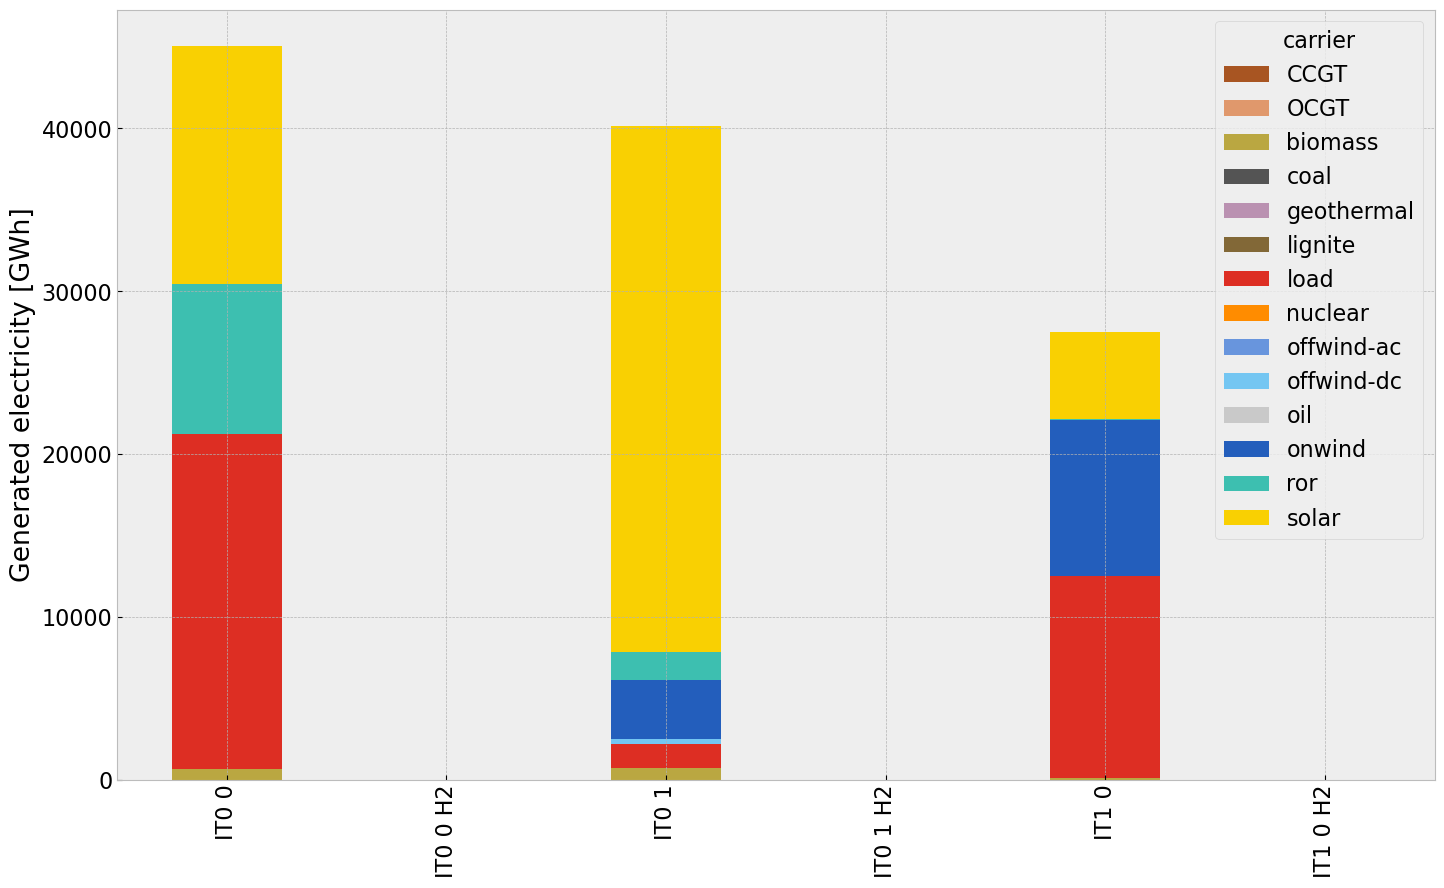

In [163]:
# consolidated generation table
carrier = n2.generators.carrier.unique()
df_tot_generation = n2.generators_t.p.sum()

generations = pd.Series(index = n2.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().index)

for r in region:
    for tech in carrier:
        key = f"{r} {tech}"
        if key in df_tot_generation.index:
            try:
                generations.loc[r, tech] = df_tot_generation[key]
                #print(generations.loc[r, tech])
            except KeyError:
                print('error')

generations.fillna(0, inplace=True)
gen_noinv = generations.unstack()/1000#GWh

gen_noinv= gen_power_table(n2,colors_gen_table)




## Snapshot

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2022575680.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p = n2.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2022575680.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sto = n2.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  links = n.links_t.p1.groupby(n.links.carrier, ax

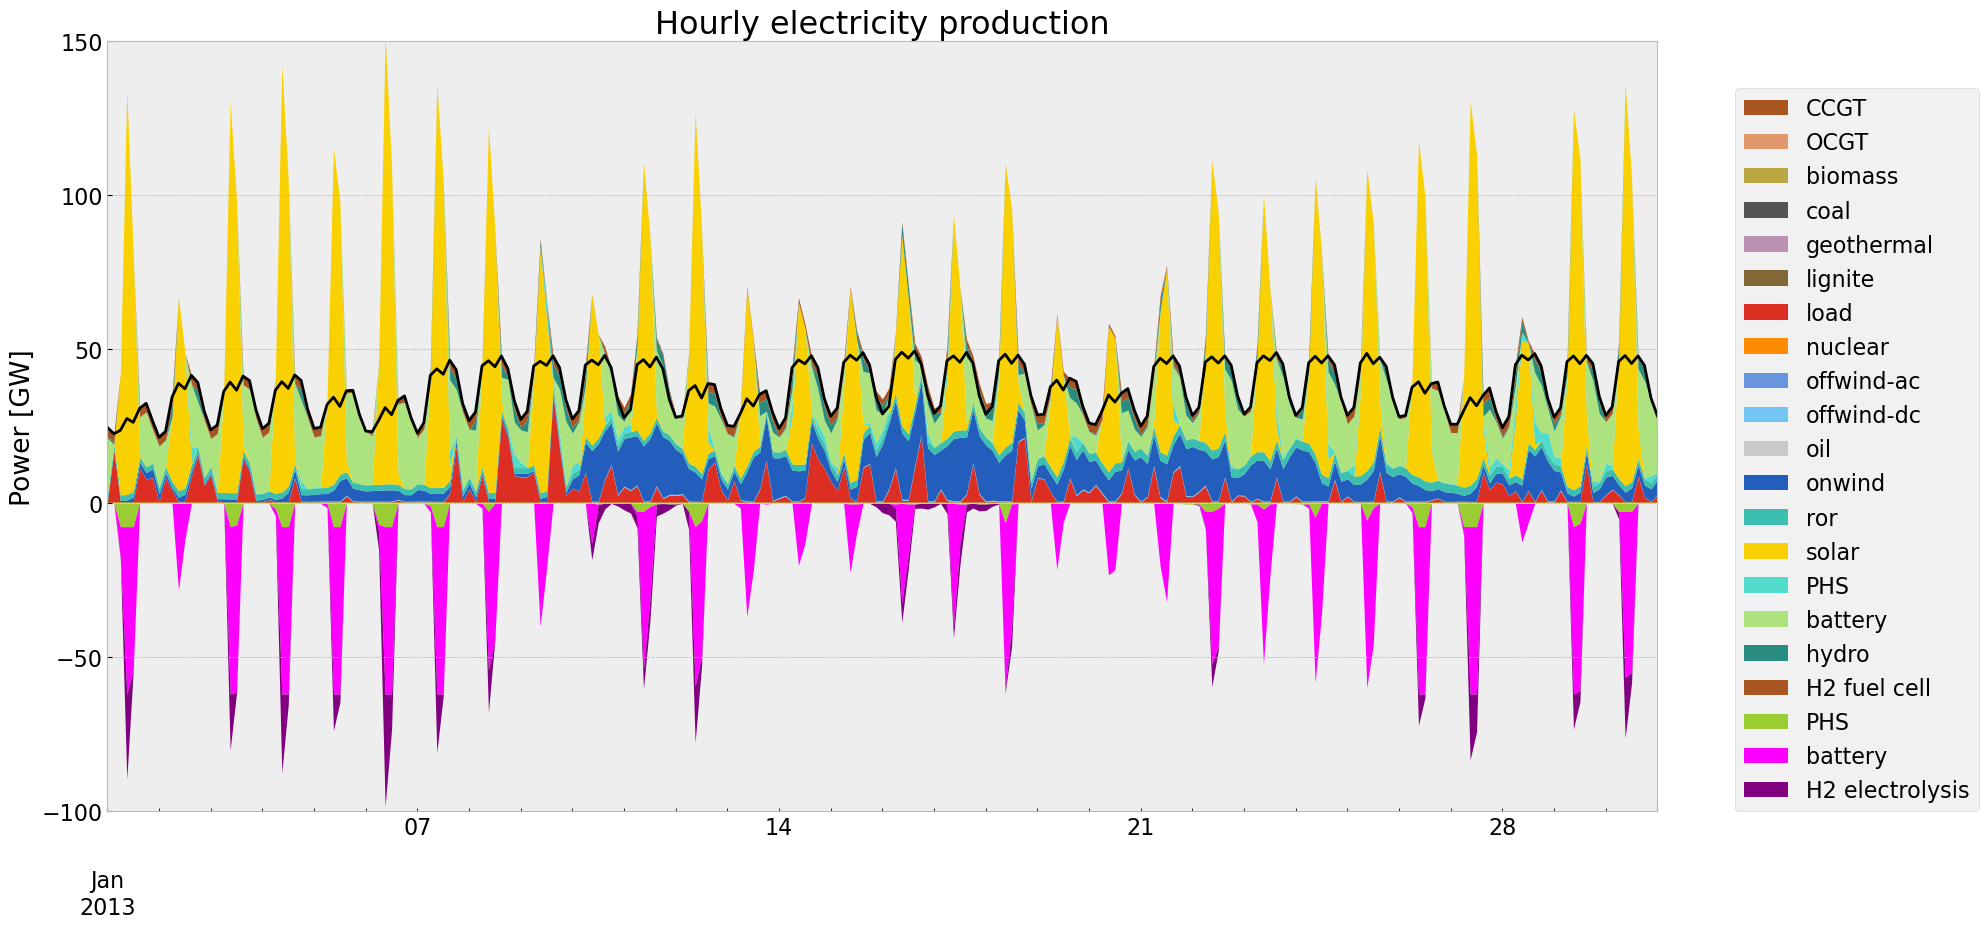

In [187]:
p = n2.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
sto = n2.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)    

gen_curve(n2, '2013-01-01', '2013-01-31', colors_gen)


C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  links = n.links_t.p1.groupby(n.links.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time = pd.date_range(start=start_date, end=end_date, freq='3H')

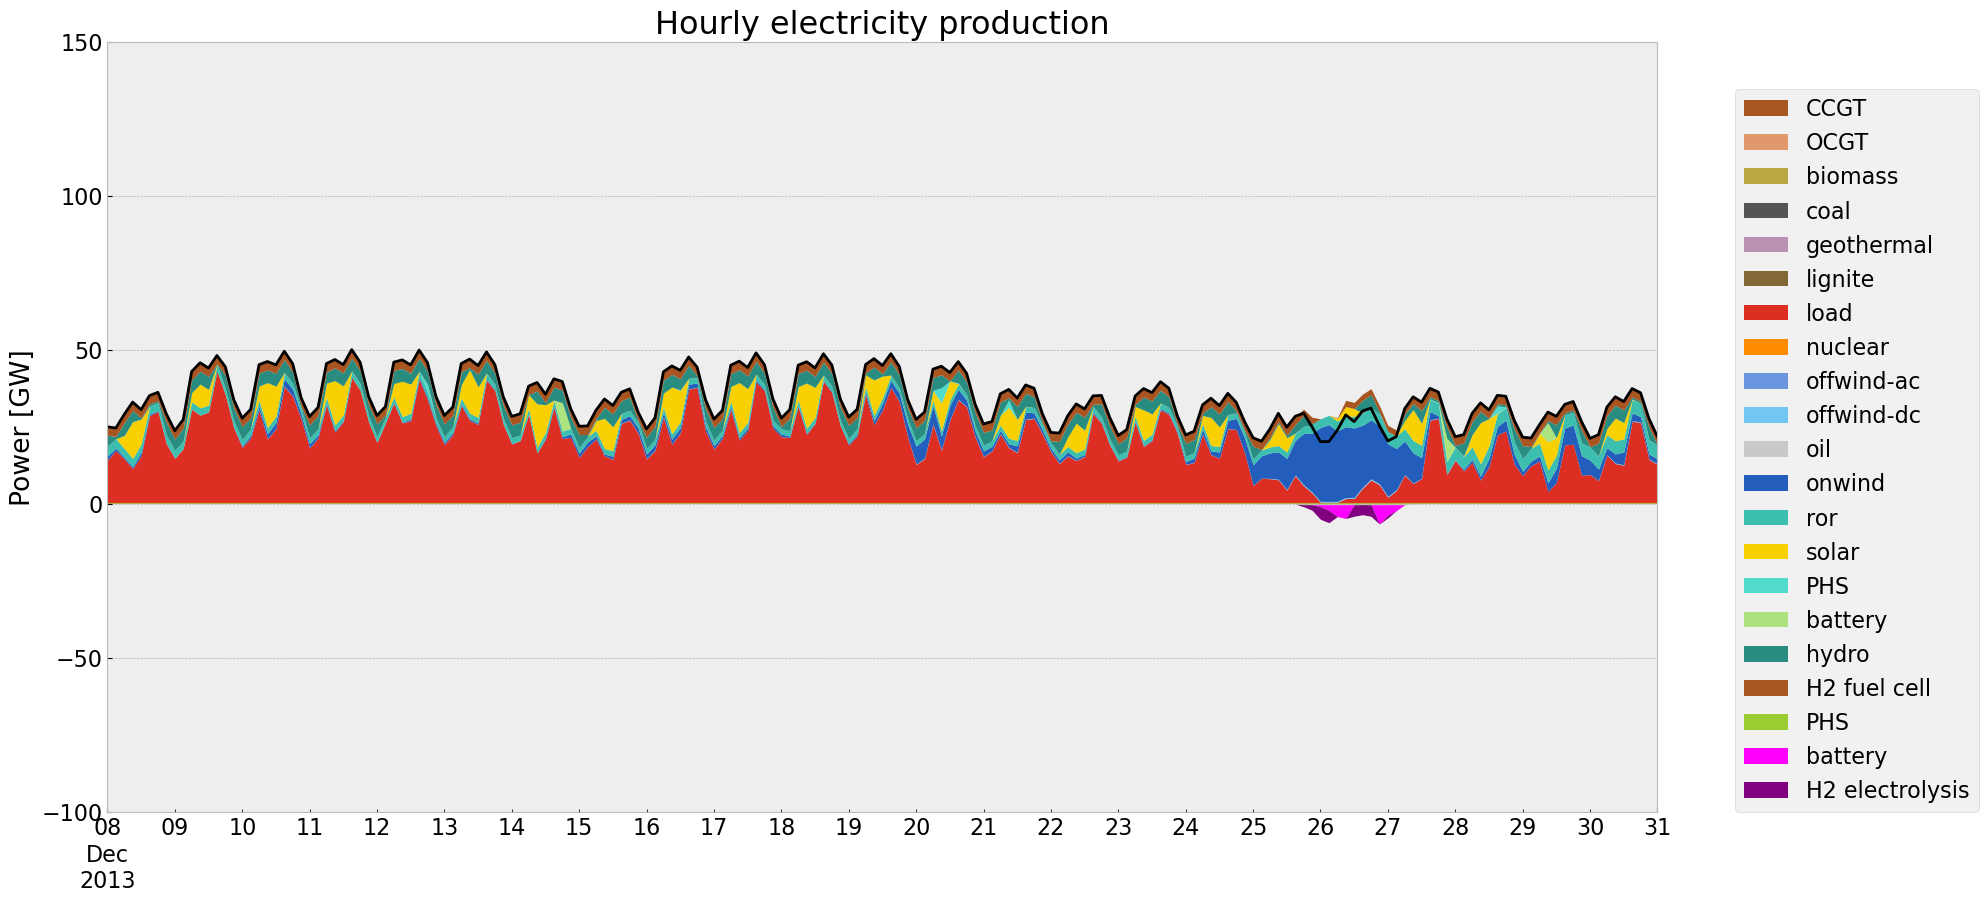

In [188]:
gen_curve(n2, '2013-12-08', '2013-12-31', colors_gen)



C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2765649672.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  soc = n.storage_units_t.state_of_charge.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\3374477851.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  n2.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3).loc[pd.date_range(start="2013-01-01", end="2013-12-31",freq='3H')].plot(figsize=(20,10))
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\3374477851.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  n2.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3).loc[pd.date_range(start="2013-01-01", end="2013-12-31",freq='3H')].plot(figsize=(20,10))


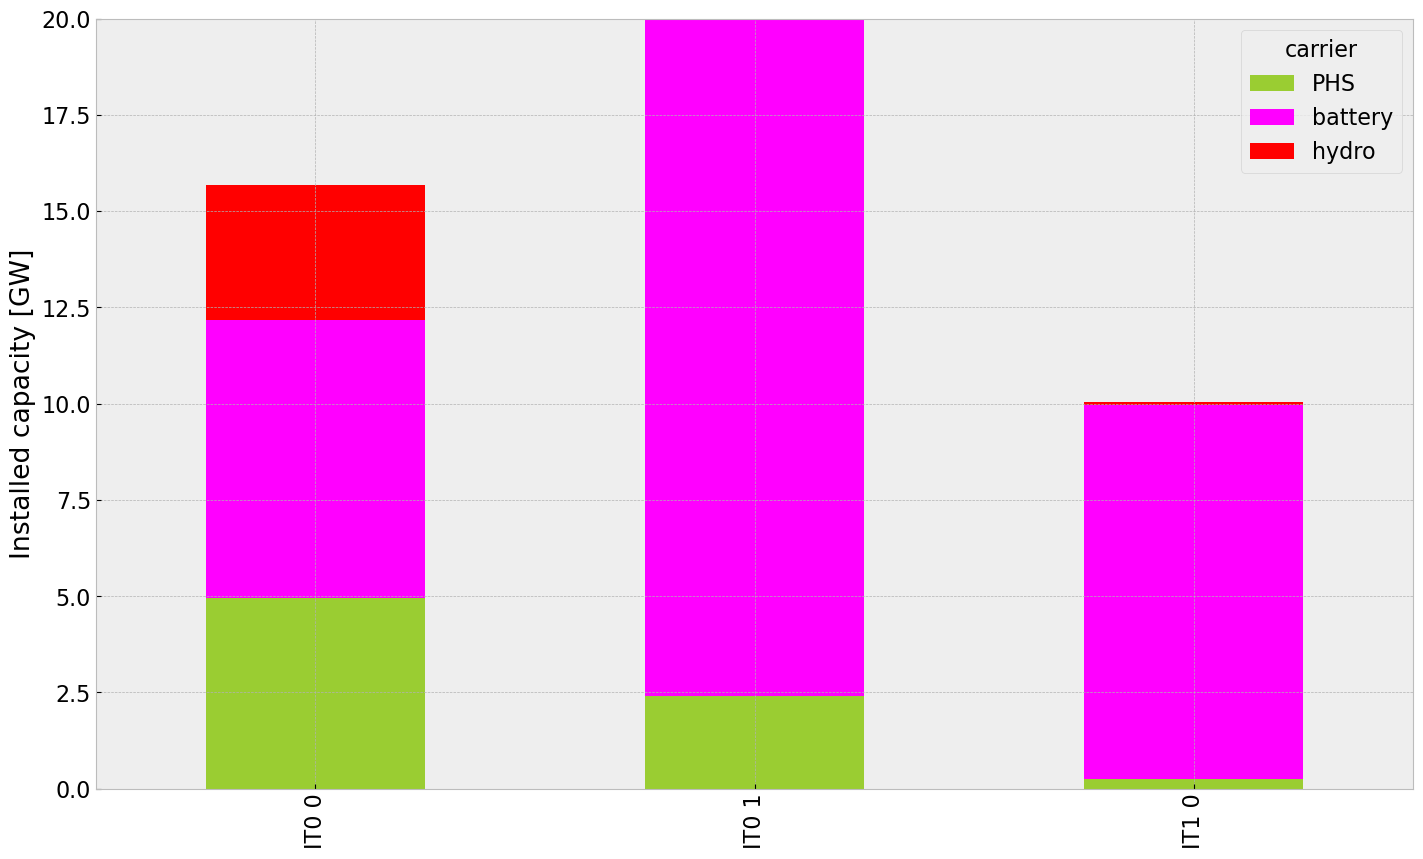

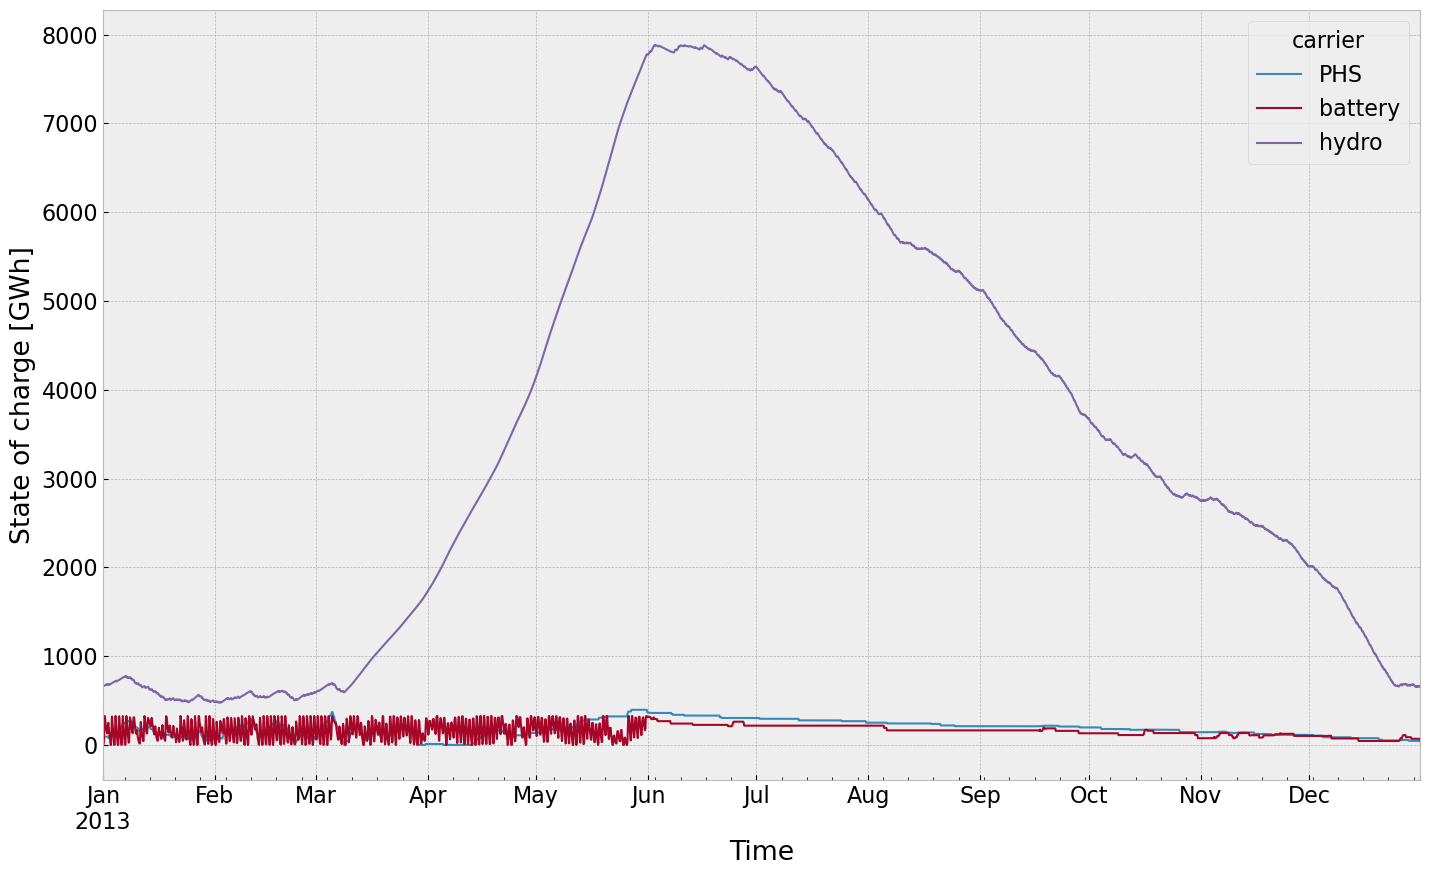

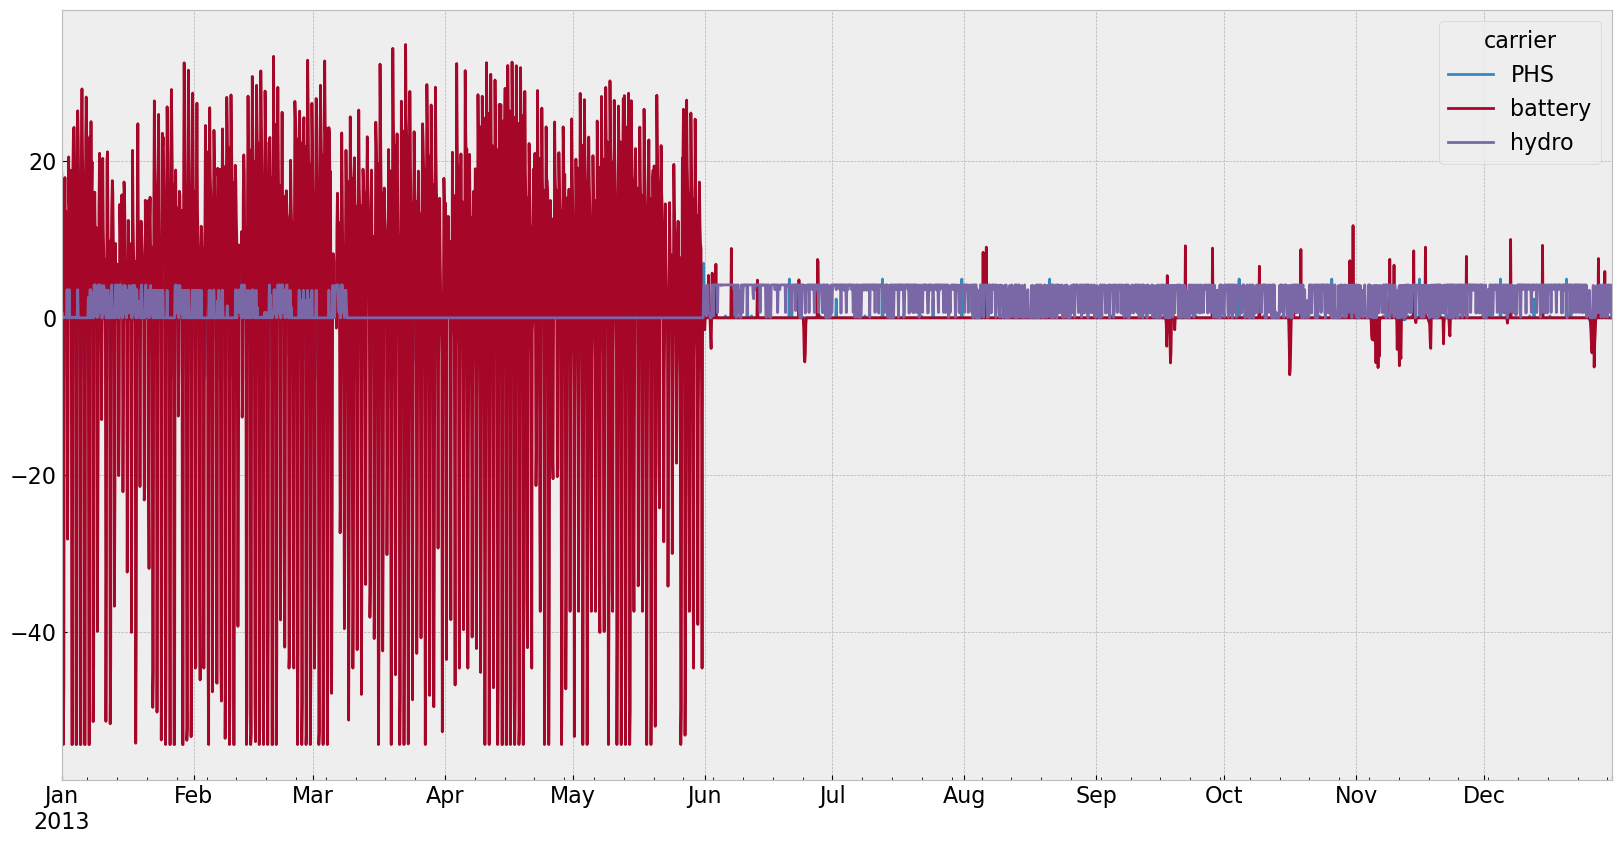

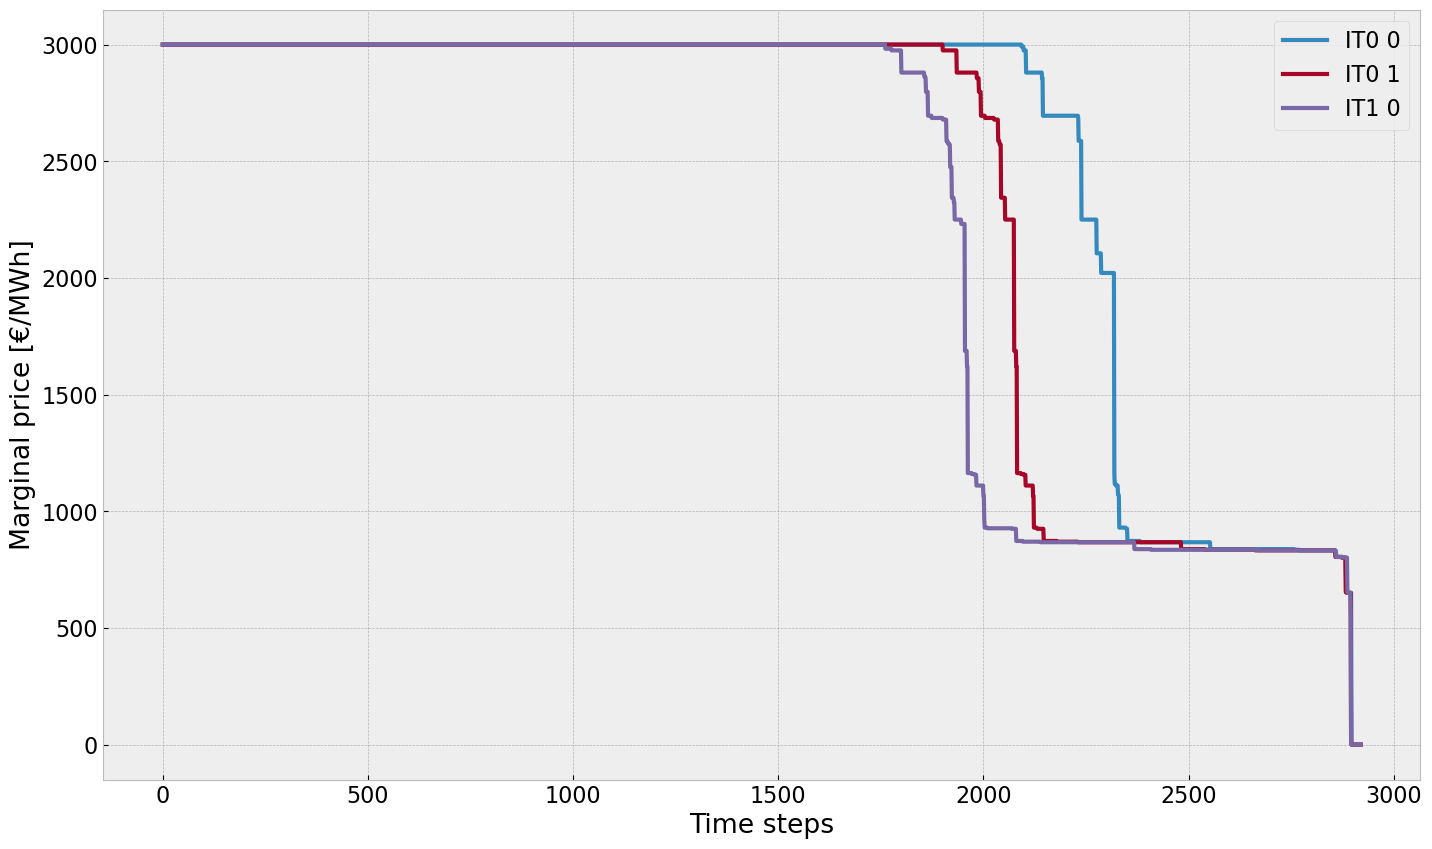

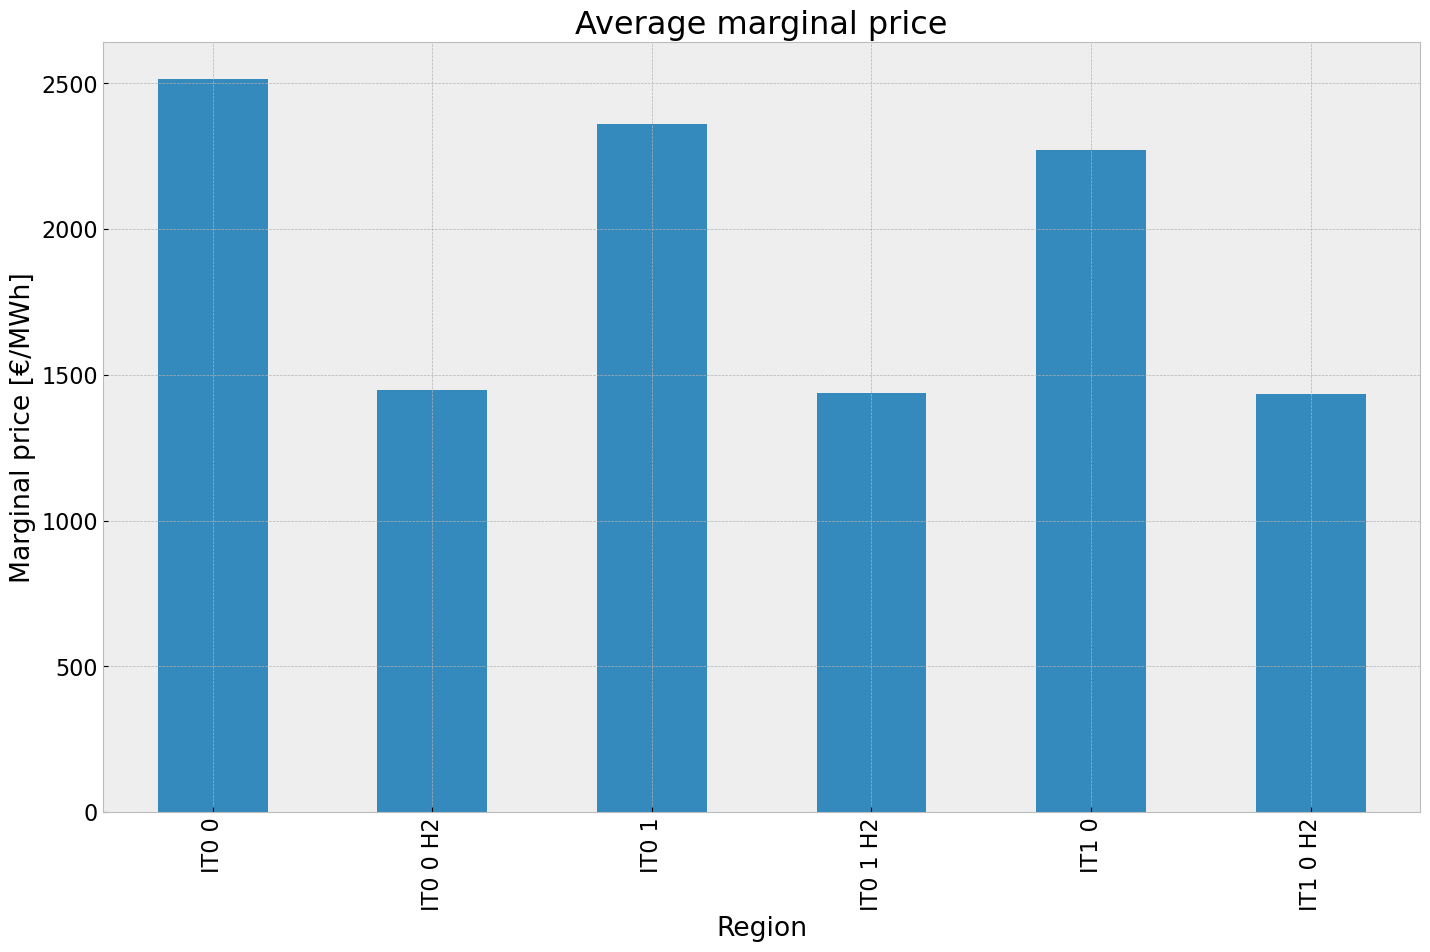

In [166]:
inst_store_table(n2)
state_of_charge_plot(n2)
n2.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3).loc[pd.date_range(start="2013-01-01", end="2013-12-31",freq='3H')].plot(figsize=(20,10))
price_dur_curve_plot(n2)
price_regions_table(n2)


## 3. Scenario: rolling horizon foresight with no additional investment

In [167]:
n3= n2.copy()
n3.optimize.create_model()

Linopy LP model

Variables:
----------
 * Generator-p_nom (Generator-ext)
 * Line-s_nom (Line-ext)
 * Link-p_nom (Link-ext)
 * Store-e_nom (Store-ext)
 * StorageUnit-p_nom (StorageUnit-ext)
 * Generator-p (snapshot, Generator)
 * Line-s (snapshot, Line)
 * Link-p (snapshot, Link)
 * Store-e (snapshot, Store)
 * StorageUnit-p_dispatch (snapshot, StorageUnit)
 * StorageUnit-p_store (snapshot, StorageUnit)
 * StorageUnit-state_of_charge (snapshot, StorageUnit)
 * StorageUnit-spill (snapshot, StorageUnit)
 * Store-p (snapshot, Store)
 * objective_constant

Constraints:
------------
 * Generator-ext-p_nom-lower (Generator-ext)
 * Generator-ext-p_nom-upper (Generator-ext)
 * Line-ext-s_nom-lower (Line-ext)
 * Line-ext-s_nom-upper (Line-ext)
 * Link-ext-p_nom-lower (Link-ext)
 * Link-ext-p_nom-upper (Link-ext)
 * Store-ext-e_nom-lower (Store-ext)
 * Store-ext-e_nom-upper (Store-ext)
 * StorageUnit-ext-p_nom-lower (StorageUnit-ext)
 * StorageUnit-ext-p_nom-upper (StorageUnit-ext)
 * Generator-

In [168]:
optimize.optimize_with_rolling_horizon(n3, horizon=24, overlap=0,
                                       solver_name='gurobi')

INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2013-01-01 00:00:00:2013-01-03 21:00:00] (1/122).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-252xpugr.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-252xpugr.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 4417 rows, 2141 columns, 8236 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8236 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8236 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8236 nonzeros


Model fingerprint: 0xb17d6331


INFO:gurobipy:Model fingerprint: 0xb17d6331


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 837 columns


INFO:gurobipy:Presolve removed 3793 rows and 837 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1304 columns, 2662 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1304 columns, 2662 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     634    2.0188484e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     634    2.0188484e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 634 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 634 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.018848427e+10


INFO:gurobipy:Optimal objective  2.018848427e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.02e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-2e40_xxd.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-2e40_xxd.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8242 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8242 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8242 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8242 nonzeros


Model fingerprint: 0xda7a9c47


INFO:gurobipy:Model fingerprint: 0xda7a9c47


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 832 columns


INFO:gurobipy:Presolve removed 3793 rows and 832 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1309 columns, 2667 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1309 columns, 2667 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     691    1.9240725e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     691    1.9240725e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 691 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 691 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.924072451e+10


INFO:gurobipy:Optimal objective  1.924072451e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.92e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-mn8nq3o4.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-mn8nq3o4.lp


Reading time = 0.09 seconds


INFO:gurobipy:Reading time = 0.09 seconds


obj: 4417 rows, 2141 columns, 8209 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8209 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8209 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8209 nonzeros


Model fingerprint: 0x001930f7


INFO:gurobipy:Model fingerprint: 0x001930f7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 838 columns


INFO:gurobipy:Presolve removed 3793 rows and 838 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1303 columns, 2661 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1303 columns, 2661 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     671    2.1089904e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     671    2.1089904e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 671 iterations and 0.12 seconds (0.01 work units)


INFO:gurobipy:Solved in 671 iterations and 0.12 seconds (0.01 work units)


Optimal objective  2.108990374e+10


INFO:gurobipy:Optimal objective  2.108990374e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.11e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-74zhd2eu.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-74zhd2eu.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8248 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8248 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8248 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8248 nonzeros


Model fingerprint: 0xbb807195


INFO:gurobipy:Model fingerprint: 0xbb807195


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 827 columns


INFO:gurobipy:Presolve removed 3793 rows and 827 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1314 columns, 2672 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1314 columns, 2672 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     671    2.0935179e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     671    2.0935179e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 671 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 671 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.093517866e+10


INFO:gurobipy:Optimal objective  2.093517866e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.09e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bgvcz7pl.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bgvcz7pl.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8264 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8264 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8264 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8264 nonzeros


Model fingerprint: 0x4ab18326


INFO:gurobipy:Model fingerprint: 0x4ab18326


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 828 columns


INFO:gurobipy:Presolve removed 3793 rows and 828 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1313 columns, 2671 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1313 columns, 2671 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     708    2.1721177e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     708    2.1721177e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 708 iterations and 0.08 seconds (0.01 work units)


INFO:gurobipy:Solved in 708 iterations and 0.08 seconds (0.01 work units)


Optimal objective  2.172117685e+10


INFO:gurobipy:Optimal objective  2.172117685e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.17e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-vb9xr9c2.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-vb9xr9c2.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8265 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8265 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8265 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8265 nonzeros


Model fingerprint: 0x7af02e9b


INFO:gurobipy:Model fingerprint: 0x7af02e9b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 825 columns


INFO:gurobipy:Presolve removed 3793 rows and 825 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1316 columns, 2674 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1316 columns, 2674 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     673    2.0836755e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     673    2.0836755e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 673 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 673 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.083675479e+10


INFO:gurobipy:Optimal objective  2.083675479e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.08e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-it5cpdgj.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-it5cpdgj.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8262 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8262 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8262 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8262 nonzeros


Model fingerprint: 0x7186f6c1


INFO:gurobipy:Model fingerprint: 0x7186f6c1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 829 columns


INFO:gurobipy:Presolve removed 3793 rows and 829 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1312 columns, 2670 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1312 columns, 2670 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     698    2.1290976e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     698    2.1290976e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 698 iterations and 0.09 seconds (0.01 work units)


INFO:gurobipy:Solved in 698 iterations and 0.09 seconds (0.01 work units)


Optimal objective  2.129097627e+10


INFO:gurobipy:Optimal objective  2.129097627e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.13e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-23kz2xh9.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-23kz2xh9.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8269 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8269 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8269 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8269 nonzeros


Model fingerprint: 0xc4e20a6f


INFO:gurobipy:Model fingerprint: 0xc4e20a6f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 823 columns


INFO:gurobipy:Presolve removed 3793 rows and 823 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     699    2.0181016e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     699    2.0181016e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 699 iterations and 0.08 seconds (0.01 work units)


INFO:gurobipy:Solved in 699 iterations and 0.08 seconds (0.01 work units)


Optimal objective  2.018101614e+10


INFO:gurobipy:Optimal objective  2.018101614e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.02e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-on5l1lur.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-on5l1lur.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8264 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8264 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8264 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8264 nonzeros


Model fingerprint: 0x2c120ae0


INFO:gurobipy:Model fingerprint: 0x2c120ae0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 823 columns


INFO:gurobipy:Presolve removed 3793 rows and 823 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     709    1.9364755e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     709    1.9364755e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 709 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 709 iterations and 0.06 seconds (0.01 work units)


Optimal objective  1.936475498e+10


INFO:gurobipy:Optimal objective  1.936475498e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.94e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-qptwvt2w.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-qptwvt2w.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8251 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8251 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8251 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8251 nonzeros


Model fingerprint: 0xbc59407c


INFO:gurobipy:Model fingerprint: 0xbc59407c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 825 columns


INFO:gurobipy:Presolve removed 3793 rows and 825 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1316 columns, 2674 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1316 columns, 2674 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     695    2.1142902e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     695    2.1142902e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 695 iterations and 0.07 seconds (0.01 work units)


INFO:gurobipy:Solved in 695 iterations and 0.07 seconds (0.01 work units)


Optimal objective  2.114290190e+10


INFO:gurobipy:Optimal objective  2.114290190e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.11e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-xzauj7eb.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-xzauj7eb.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8264 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8264 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8264 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8264 nonzeros


Model fingerprint: 0x1c8ab462


INFO:gurobipy:Model fingerprint: 0x1c8ab462


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 823 columns


INFO:gurobipy:Presolve removed 3793 rows and 823 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     611    1.9990402e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     611    1.9990402e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 611 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 611 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.999040206e+10


INFO:gurobipy:Optimal objective  1.999040206e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.00e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-j32ipiwm.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-j32ipiwm.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8269 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8269 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8269 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8269 nonzeros


Model fingerprint: 0x878d3692


INFO:gurobipy:Model fingerprint: 0x878d3692


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 823 columns


INFO:gurobipy:Presolve removed 3793 rows and 823 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     611    1.9502105e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     611    1.9502105e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 611 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 611 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.950210476e+10


INFO:gurobipy:Optimal objective  1.950210476e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.95e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-5belfuu1.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-5belfuu1.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8269 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8269 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8269 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8269 nonzeros


Model fingerprint: 0x7f3c76bd


INFO:gurobipy:Model fingerprint: 0x7f3c76bd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 823 columns


INFO:gurobipy:Presolve removed 3793 rows and 823 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     674    1.9829572e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     674    1.9829572e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 674 iterations and 0.07 seconds (0.01 work units)


INFO:gurobipy:Solved in 674 iterations and 0.07 seconds (0.01 work units)


Optimal objective  1.982957247e+10


INFO:gurobipy:Optimal objective  1.982957247e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.98e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-n3de4_zo.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-n3de4_zo.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8262 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8262 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8262 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8262 nonzeros


Model fingerprint: 0x9d9c7d5f


INFO:gurobipy:Model fingerprint: 0x9d9c7d5f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 824 columns


INFO:gurobipy:Presolve removed 3793 rows and 824 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1317 columns, 2675 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1317 columns, 2675 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     683    1.9834371e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     683    1.9834371e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 683 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 683 iterations and 0.06 seconds (0.01 work units)


Optimal objective  1.983437065e+10


INFO:gurobipy:Optimal objective  1.983437065e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.98e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-7m59pbvx.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-7m59pbvx.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8266 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8266 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8266 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8266 nonzeros


Model fingerprint: 0x4ccc2c27


INFO:gurobipy:Model fingerprint: 0x4ccc2c27


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 823 columns


INFO:gurobipy:Presolve removed 3793 rows and 823 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     662    2.1014006e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     662    2.1014006e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 662 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 662 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.101400602e+10


INFO:gurobipy:Optimal objective  2.101400602e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.10e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ina5aix3.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ina5aix3.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8239 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8239 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8239 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8239 nonzeros


Model fingerprint: 0x688b3aa8


INFO:gurobipy:Model fingerprint: 0x688b3aa8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 839 columns


INFO:gurobipy:Presolve removed 3793 rows and 839 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1302 columns, 2660 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1302 columns, 2660 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     653    1.9399328e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     653    1.9399328e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 653 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 653 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.939932845e+10


INFO:gurobipy:Optimal objective  1.939932845e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.94e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6ksb_u9d.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6ksb_u9d.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8251 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8251 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8251 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8251 nonzeros


Model fingerprint: 0x682e2263


INFO:gurobipy:Model fingerprint: 0x682e2263


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 835 columns


INFO:gurobipy:Presolve removed 3793 rows and 835 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1306 columns, 2664 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1306 columns, 2664 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     617    2.0402859e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     617    2.0402859e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 617 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 617 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.040285899e+10


INFO:gurobipy:Optimal objective  2.040285899e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.04e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-hrb4_d60.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-hrb4_d60.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8266 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8266 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8266 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8266 nonzeros


Model fingerprint: 0x2aa58e5b


INFO:gurobipy:Model fingerprint: 0x2aa58e5b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 826 columns


INFO:gurobipy:Presolve removed 3793 rows and 826 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1315 columns, 2673 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1315 columns, 2673 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     706    2.0850198e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     706    2.0850198e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 706 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 706 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.085019822e+10


INFO:gurobipy:Optimal objective  2.085019822e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.09e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-hsqmhe53.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-hsqmhe53.lp


Reading time = 0.04 seconds


INFO:gurobipy:Reading time = 0.04 seconds


obj: 4417 rows, 2141 columns, 8265 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8265 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8265 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8265 nonzeros


Model fingerprint: 0x17a6cccd


INFO:gurobipy:Model fingerprint: 0x17a6cccd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 826 columns


INFO:gurobipy:Presolve removed 3793 rows and 826 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1315 columns, 2673 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1315 columns, 2673 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     726    1.9700086e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     726    1.9700086e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 726 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 726 iterations and 0.04 seconds (0.01 work units)


Optimal objective  1.970008635e+10


INFO:gurobipy:Optimal objective  1.970008635e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.97e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.44s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-zj4ce9ui.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-zj4ce9ui.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8253 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8253 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8253 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8253 nonzeros


Model fingerprint: 0x23cd088e


INFO:gurobipy:Model fingerprint: 0x23cd088e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 829 columns


INFO:gurobipy:Presolve removed 3793 rows and 829 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 624 rows, 1312 columns, 2670 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1312 columns, 2670 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     696    1.9608128e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     696    1.9608128e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 696 iterations and 0.13 seconds (0.01 work units)


INFO:gurobipy:Solved in 696 iterations and 0.13 seconds (0.01 work units)


Optimal objective  1.960812757e+10


INFO:gurobipy:Optimal objective  1.960812757e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.96e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-kx5moymx.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-kx5moymx.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8240 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8240 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8240 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8240 nonzeros


Model fingerprint: 0x6e430120


INFO:gurobipy:Model fingerprint: 0x6e430120


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 834 columns


INFO:gurobipy:Presolve removed 3793 rows and 834 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1307 columns, 2665 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1307 columns, 2665 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     625    1.9167799e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     625    1.9167799e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 625 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 625 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.916779933e+10


INFO:gurobipy:Optimal objective  1.916779933e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.92e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.38s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bccgd074.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bccgd074.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 4417 rows, 2141 columns, 8268 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8268 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8268 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8268 nonzeros


Model fingerprint: 0x93dd3c5c


INFO:gurobipy:Model fingerprint: 0x93dd3c5c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 823 columns


INFO:gurobipy:Presolve removed 3793 rows and 823 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     623    2.1376496e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     623    2.1376496e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 623 iterations and 0.12 seconds (0.01 work units)


INFO:gurobipy:Solved in 623 iterations and 0.12 seconds (0.01 work units)


Optimal objective  2.137649600e+10


INFO:gurobipy:Optimal objective  2.137649600e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.14e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-dj5o6fse.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-dj5o6fse.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8268 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8268 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8268 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8268 nonzeros


Model fingerprint: 0xbacceb15


INFO:gurobipy:Model fingerprint: 0xbacceb15


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 823 columns


INFO:gurobipy:Presolve removed 3793 rows and 823 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     666    1.9312837e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     666    1.9312837e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 666 iterations and 0.07 seconds (0.01 work units)


INFO:gurobipy:Solved in 666 iterations and 0.07 seconds (0.01 work units)


Optimal objective  1.931283676e+10


INFO:gurobipy:Optimal objective  1.931283676e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.93e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-b3xwdq_t.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-b3xwdq_t.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8249 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8249 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8249 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8249 nonzeros


Model fingerprint: 0x3fccbd26


INFO:gurobipy:Model fingerprint: 0x3fccbd26


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 824 columns


INFO:gurobipy:Presolve removed 3793 rows and 824 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1317 columns, 2675 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1317 columns, 2675 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     683    1.9397271e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     683    1.9397271e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 683 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 683 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.939727123e+10


INFO:gurobipy:Optimal objective  1.939727123e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.94e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-20rw5ff_.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-20rw5ff_.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8267 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8267 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8267 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8267 nonzeros


Model fingerprint: 0x772f3af2


INFO:gurobipy:Model fingerprint: 0x772f3af2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 824 columns


INFO:gurobipy:Presolve removed 3793 rows and 824 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1317 columns, 2675 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1317 columns, 2675 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     527    1.9149435e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     527    1.9149435e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 527 iterations and 0.07 seconds (0.01 work units)


INFO:gurobipy:Solved in 527 iterations and 0.07 seconds (0.01 work units)


Optimal objective  1.914943477e+10


INFO:gurobipy:Optimal objective  1.914943477e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-utpzboa6.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-utpzboa6.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8269 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8269 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8269 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8269 nonzeros


Model fingerprint: 0x25020329


INFO:gurobipy:Model fingerprint: 0x25020329


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 823 columns


INFO:gurobipy:Presolve removed 3793 rows and 823 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     676    1.9207968e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     676    1.9207968e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 676 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 676 iterations and 0.04 seconds (0.01 work units)


Optimal objective  1.920796763e+10


INFO:gurobipy:Optimal objective  1.920796763e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.92e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-5xs5gvpj.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-5xs5gvpj.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 4417 rows, 2141 columns, 8261 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8261 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8261 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8261 nonzeros


Model fingerprint: 0xea6ba67c


INFO:gurobipy:Model fingerprint: 0xea6ba67c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 826 columns


INFO:gurobipy:Presolve removed 3793 rows and 826 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1315 columns, 2673 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1315 columns, 2673 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     594    1.9149652e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     594    1.9149652e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 594 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 594 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.914965235e+10


INFO:gurobipy:Optimal objective  1.914965235e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-48yk_05b.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-48yk_05b.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8267 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8267 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8267 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8267 nonzeros


Model fingerprint: 0x44b8007d


INFO:gurobipy:Model fingerprint: 0x44b8007d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 825 columns


INFO:gurobipy:Presolve removed 3793 rows and 825 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1316 columns, 2674 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1316 columns, 2674 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     591    1.9149429e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     591    1.9149429e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 591 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 591 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.914942856e+10


INFO:gurobipy:Optimal objective  1.914942856e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-8lmg8654.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-8lmg8654.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8265 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8265 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8265 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8265 nonzeros


Model fingerprint: 0xc9cbb7b8


INFO:gurobipy:Model fingerprint: 0xc9cbb7b8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 824 columns


INFO:gurobipy:Presolve removed 3793 rows and 824 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1317 columns, 2675 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1317 columns, 2675 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     686    1.9708276e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     686    1.9708276e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 686 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 686 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.970827561e+10


INFO:gurobipy:Optimal objective  1.970827561e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.97e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-fn7vluf0.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-fn7vluf0.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8269 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8269 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8269 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8269 nonzeros


Model fingerprint: 0xe9a62e0a


INFO:gurobipy:Model fingerprint: 0xe9a62e0a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 823 columns


INFO:gurobipy:Presolve removed 3793 rows and 823 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     561    1.9149421e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     561    1.9149421e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 561 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 561 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.914942141e+10


INFO:gurobipy:Optimal objective  1.914942141e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bfyebb_h.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bfyebb_h.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8262 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8262 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8262 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8262 nonzeros


Model fingerprint: 0x6abcfc6e


INFO:gurobipy:Model fingerprint: 0x6abcfc6e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [5e+01, 2e+09]


INFO:gurobipy:  Bounds range     [5e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 824 columns


INFO:gurobipy:Presolve removed 3793 rows and 824 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1317 columns, 2675 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1317 columns, 2675 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     508    1.9149423e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     508    1.9149423e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 508 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 508 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.914942327e+10


INFO:gurobipy:Optimal objective  1.914942327e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-d__y1tw5.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-d__y1tw5.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8261 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8261 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8261 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8261 nonzeros


Model fingerprint: 0x0015f5de


INFO:gurobipy:Model fingerprint: 0x0015f5de


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [6e+01, 2e+09]


INFO:gurobipy:  Bounds range     [6e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 826 columns


INFO:gurobipy:Presolve removed 3793 rows and 826 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1315 columns, 2673 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1315 columns, 2673 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     517    1.9149427e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     517    1.9149427e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 517 iterations and 0.07 seconds (0.01 work units)


INFO:gurobipy:Solved in 517 iterations and 0.07 seconds (0.01 work units)


Optimal objective  1.914942746e+10


INFO:gurobipy:Optimal objective  1.914942746e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-90bj89fd.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-90bj89fd.lp


Reading time = 0.04 seconds


INFO:gurobipy:Reading time = 0.04 seconds


obj: 4417 rows, 2141 columns, 8268 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8268 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8268 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8268 nonzeros


Model fingerprint: 0x865c5bfd


INFO:gurobipy:Model fingerprint: 0x865c5bfd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [6e+01, 2e+09]


INFO:gurobipy:  Bounds range     [6e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 823 columns


INFO:gurobipy:Presolve removed 3793 rows and 823 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     511    1.9149425e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     511    1.9149425e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 511 iterations and 0.07 seconds (0.01 work units)


INFO:gurobipy:Solved in 511 iterations and 0.07 seconds (0.01 work units)


Optimal objective  1.914942506e+10


INFO:gurobipy:Optimal objective  1.914942506e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-lfgoloxb.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-lfgoloxb.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8267 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8267 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8267 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8267 nonzeros


Model fingerprint: 0x88bcd387


INFO:gurobipy:Model fingerprint: 0x88bcd387


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [5e+01, 2e+09]


INFO:gurobipy:  Bounds range     [5e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 823 columns


INFO:gurobipy:Presolve removed 3793 rows and 823 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     529    1.9149431e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     529    1.9149431e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 529 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 529 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.914943072e+10


INFO:gurobipy:Optimal objective  1.914943072e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ai8hetnp.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ai8hetnp.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8223 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8223 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8223 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8223 nonzeros


Model fingerprint: 0xa996c999


INFO:gurobipy:Model fingerprint: 0xa996c999


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [5e+01, 2e+09]


INFO:gurobipy:  Bounds range     [5e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 830 columns


INFO:gurobipy:Presolve removed 3793 rows and 830 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1311 columns, 2669 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1311 columns, 2669 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     463    1.9149421e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     463    1.9149421e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 463 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 463 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.914942136e+10


INFO:gurobipy:Optimal objective  1.914942136e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-9dfbyul2.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-9dfbyul2.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8195 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8195 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8195 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8195 nonzeros


Model fingerprint: 0x747ef452


INFO:gurobipy:Model fingerprint: 0x747ef452


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [5e+01, 2e+09]


INFO:gurobipy:  Bounds range     [5e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 850 columns


INFO:gurobipy:Presolve removed 3793 rows and 850 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 624 rows, 1291 columns, 2649 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1291 columns, 2649 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     443    1.9149429e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     443    1.9149429e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 443 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 443 iterations and 0.04 seconds (0.01 work units)


Optimal objective  1.914942948e+10


INFO:gurobipy:Optimal objective  1.914942948e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-uxait3vj.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-uxait3vj.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8254 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8254 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8254 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8254 nonzeros


Model fingerprint: 0x8c774cd6


INFO:gurobipy:Model fingerprint: 0x8c774cd6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [6e+01, 2e+09]


INFO:gurobipy:  Bounds range     [6e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 827 columns


INFO:gurobipy:Presolve removed 3793 rows and 827 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1314 columns, 2672 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1314 columns, 2672 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     506    1.9149420e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     506    1.9149420e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 506 iterations and 0.08 seconds (0.01 work units)


INFO:gurobipy:Solved in 506 iterations and 0.08 seconds (0.01 work units)


Optimal objective  1.914942003e+10


INFO:gurobipy:Optimal objective  1.914942003e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-su2d81cq.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-su2d81cq.lp


Reading time = 0.04 seconds


INFO:gurobipy:Reading time = 0.04 seconds


obj: 4417 rows, 2141 columns, 8241 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8241 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8241 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8241 nonzeros


Model fingerprint: 0xc754bb00


INFO:gurobipy:Model fingerprint: 0xc754bb00


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [7e+01, 2e+09]


INFO:gurobipy:  Bounds range     [7e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 826 columns


INFO:gurobipy:Presolve removed 3793 rows and 826 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1315 columns, 2673 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1315 columns, 2673 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     482    1.9149426e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     482    1.9149426e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 482 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 482 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.914942639e+10


INFO:gurobipy:Optimal objective  1.914942639e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-r0e430y2.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-r0e430y2.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8259 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8259 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8259 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8259 nonzeros


Model fingerprint: 0x1feda889


INFO:gurobipy:Model fingerprint: 0x1feda889


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [6e+01, 2e+09]


INFO:gurobipy:  Bounds range     [6e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 822 columns


INFO:gurobipy:Presolve removed 3793 rows and 822 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1319 columns, 2677 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1319 columns, 2677 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     492    1.9149416e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     492    1.9149416e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 492 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 492 iterations and 0.06 seconds (0.01 work units)


Optimal objective  1.914941564e+10


INFO:gurobipy:Optimal objective  1.914941564e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.38s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-w78dfz__.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-w78dfz__.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8270 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8270 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8270 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8270 nonzeros


Model fingerprint: 0x5bbd7ea7


INFO:gurobipy:Model fingerprint: 0x5bbd7ea7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [7e+01, 2e+09]


INFO:gurobipy:  Bounds range     [7e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 822 columns


INFO:gurobipy:Presolve removed 3793 rows and 822 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1319 columns, 2677 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1319 columns, 2677 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     461    1.9149418e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     461    1.9149418e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 461 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 461 iterations and 0.06 seconds (0.01 work units)


Optimal objective  1.914941805e+10


INFO:gurobipy:Optimal objective  1.914941805e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-gow91cwp.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-gow91cwp.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8231 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8231 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8231 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8231 nonzeros


Model fingerprint: 0x45e4e4ae


INFO:gurobipy:Model fingerprint: 0x45e4e4ae


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [9e+01, 2e+09]


INFO:gurobipy:  Bounds range     [9e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 833 columns


INFO:gurobipy:Presolve removed 3793 rows and 833 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1308 columns, 2666 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1308 columns, 2666 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     424    1.9149418e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     424    1.9149418e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 424 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 424 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.914941798e+10


INFO:gurobipy:Optimal objective  1.914941798e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-0g_buhif.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-0g_buhif.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8256 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8256 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8256 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8256 nonzeros


Model fingerprint: 0x21db2b48


INFO:gurobipy:Model fingerprint: 0x21db2b48


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [9e+01, 2e+09]


INFO:gurobipy:  Bounds range     [9e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 823 columns


INFO:gurobipy:Presolve removed 3793 rows and 823 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     432    1.9149416e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     432    1.9149416e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 432 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 432 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.914941640e+10


INFO:gurobipy:Optimal objective  1.914941640e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.49s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-3xkv3wjc.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-3xkv3wjc.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 4417 rows, 2141 columns, 8222 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8222 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8222 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8222 nonzeros


Model fingerprint: 0xf84cc158


INFO:gurobipy:Model fingerprint: 0xf84cc158


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [8e+01, 2e+09]


INFO:gurobipy:  Bounds range     [8e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 831 columns


INFO:gurobipy:Presolve removed 3793 rows and 831 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1310 columns, 2668 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1310 columns, 2668 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     441    1.9149426e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     441    1.9149426e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 441 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 441 iterations and 0.06 seconds (0.01 work units)


Optimal objective  1.914942582e+10


INFO:gurobipy:Optimal objective  1.914942582e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-y4g29klb.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-y4g29klb.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8262 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8262 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8262 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8262 nonzeros


Model fingerprint: 0xce278e45


INFO:gurobipy:Model fingerprint: 0xce278e45


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [9e+01, 2e+09]


INFO:gurobipy:  Bounds range     [9e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 825 columns


INFO:gurobipy:Presolve removed 3793 rows and 825 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1316 columns, 2674 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1316 columns, 2674 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     467    1.9149418e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     467    1.9149418e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 467 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 467 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.914941766e+10


INFO:gurobipy:Optimal objective  1.914941766e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-1geogbl9.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-1geogbl9.lp


Reading time = 0.04 seconds


INFO:gurobipy:Reading time = 0.04 seconds


obj: 4417 rows, 2141 columns, 8263 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8263 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8263 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8263 nonzeros


Model fingerprint: 0x46138949


INFO:gurobipy:Model fingerprint: 0x46138949


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [8e+01, 2e+09]


INFO:gurobipy:  Bounds range     [8e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 823 columns


INFO:gurobipy:Presolve removed 3793 rows and 823 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     485    1.9149425e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     485    1.9149425e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 485 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 485 iterations and 0.04 seconds (0.01 work units)


Optimal objective  1.914942500e+10


INFO:gurobipy:Optimal objective  1.914942500e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-3my5efgv.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-3my5efgv.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8272 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8272 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8272 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8272 nonzeros


Model fingerprint: 0xf395c27b


INFO:gurobipy:Model fingerprint: 0xf395c27b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [8e+01, 2e+09]


INFO:gurobipy:  Bounds range     [8e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 820 columns


INFO:gurobipy:Presolve removed 3793 rows and 820 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1321 columns, 2679 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1321 columns, 2679 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     460    1.9149422e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     460    1.9149422e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 460 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 460 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.914942238e+10


INFO:gurobipy:Optimal objective  1.914942238e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-64cp9ir_.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-64cp9ir_.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8273 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8273 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8273 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8273 nonzeros


Model fingerprint: 0xe378840b


INFO:gurobipy:Model fingerprint: 0xe378840b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [1e+02, 2e+09]


INFO:gurobipy:  Bounds range     [1e+02, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 817 columns


INFO:gurobipy:Presolve removed 3793 rows and 817 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1324 columns, 2682 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1324 columns, 2682 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     462    1.9149419e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     462    1.9149419e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 462 iterations and 0.08 seconds (0.01 work units)


INFO:gurobipy:Solved in 462 iterations and 0.08 seconds (0.01 work units)


Optimal objective  1.914941948e+10


INFO:gurobipy:Optimal objective  1.914941948e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-1dpg9gez.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-1dpg9gez.lp


Reading time = 0.04 seconds


INFO:gurobipy:Reading time = 0.04 seconds


obj: 4417 rows, 2141 columns, 8276 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8276 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8276 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8276 nonzeros


Model fingerprint: 0x092f13ce


INFO:gurobipy:Model fingerprint: 0x092f13ce


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [9e+01, 2e+09]


INFO:gurobipy:  Bounds range     [9e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 815 columns


INFO:gurobipy:Presolve removed 3793 rows and 815 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1326 columns, 2684 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1326 columns, 2684 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     430    1.9149425e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     430    1.9149425e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 430 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 430 iterations and 0.05 seconds (0.01 work units)


Optimal objective  1.914942454e+10


INFO:gurobipy:Optimal objective  1.914942454e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-zdko16b5.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-zdko16b5.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8273 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8273 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8273 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8273 nonzeros


Model fingerprint: 0x34a0b029


INFO:gurobipy:Model fingerprint: 0x34a0b029


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [8e+01, 2e+09]


INFO:gurobipy:  Bounds range     [8e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 819 columns


INFO:gurobipy:Presolve removed 3793 rows and 819 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1322 columns, 2680 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1322 columns, 2680 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     488    1.9149416e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     488    1.9149416e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 488 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 488 iterations and 0.04 seconds (0.01 work units)


Optimal objective  1.914941599e+10


INFO:gurobipy:Optimal objective  1.914941599e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-uejq5ii2.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-uejq5ii2.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8275 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8275 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8275 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8275 nonzeros


Model fingerprint: 0x1e42f2df


INFO:gurobipy:Model fingerprint: 0x1e42f2df


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [7e+01, 2e+09]


INFO:gurobipy:  Bounds range     [7e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 817 columns


INFO:gurobipy:Presolve removed 3793 rows and 817 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1324 columns, 2682 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1324 columns, 2682 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     492    1.9149425e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     492    1.9149425e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 492 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 492 iterations and 0.04 seconds (0.01 work units)


Optimal objective  1.914942481e+10


INFO:gurobipy:Optimal objective  1.914942481e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.91e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-w691vzdf.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-w691vzdf.lp


Reading time = 0.04 seconds


INFO:gurobipy:Reading time = 0.04 seconds


obj: 4417 rows, 2141 columns, 8272 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8272 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8272 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8272 nonzeros


Model fingerprint: 0xbf722033


INFO:gurobipy:Model fingerprint: 0xbf722033


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [7e+01, 2e+09]


INFO:gurobipy:  Bounds range     [7e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 815 columns


INFO:gurobipy:Presolve removed 3793 rows and 815 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 624 rows, 1326 columns, 2684 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1326 columns, 2684 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     577    1.9384787e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     577    1.9384787e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 577 iterations and 0.07 seconds (0.01 work units)


INFO:gurobipy:Solved in 577 iterations and 0.07 seconds (0.01 work units)


Optimal objective  1.938478651e+10


INFO:gurobipy:Optimal objective  1.938478651e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 1.94e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-8wcixgxo.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-8wcixgxo.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8218 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8218 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8218 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8218 nonzeros


Model fingerprint: 0x88e4baf6


INFO:gurobipy:Model fingerprint: 0x88e4baf6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [7e+01, 2e+09]


INFO:gurobipy:  Bounds range     [7e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 836 columns


INFO:gurobipy:Presolve removed 3793 rows and 836 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1305 columns, 2663 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1305 columns, 2663 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     666    2.3073456e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     666    2.3073456e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 666 iterations and 0.08 seconds (0.01 work units)


INFO:gurobipy:Solved in 666 iterations and 0.08 seconds (0.01 work units)


Optimal objective  2.307345620e+10


INFO:gurobipy:Optimal objective  2.307345620e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.31e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-s4lxvv6r.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-s4lxvv6r.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8221 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8221 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8221 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8221 nonzeros


Model fingerprint: 0xde94f6e8


INFO:gurobipy:Model fingerprint: 0xde94f6e8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [7e+01, 2e+09]


INFO:gurobipy:  Bounds range     [7e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 830 columns


INFO:gurobipy:Presolve removed 3793 rows and 830 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1311 columns, 2669 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1311 columns, 2669 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     767    2.2706002e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     767    2.2706002e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 767 iterations and 0.05 seconds (0.02 work units)


INFO:gurobipy:Solved in 767 iterations and 0.05 seconds (0.02 work units)


Optimal objective  2.270600185e+10


INFO:gurobipy:Optimal objective  2.270600185e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.27e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.38s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-2pq4d121.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-2pq4d121.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 4417 rows, 2141 columns, 8264 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8264 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8264 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8264 nonzeros


Model fingerprint: 0x133751b7


INFO:gurobipy:Model fingerprint: 0x133751b7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [7e+01, 2e+09]


INFO:gurobipy:  Bounds range     [7e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 819 columns


INFO:gurobipy:Presolve removed 3793 rows and 819 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1322 columns, 2680 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1322 columns, 2680 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     659    2.1903058e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     659    2.1903058e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 659 iterations and 0.07 seconds (0.01 work units)


INFO:gurobipy:Solved in 659 iterations and 0.07 seconds (0.01 work units)


Optimal objective  2.190305798e+10


INFO:gurobipy:Optimal objective  2.190305798e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.19e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-7qvv75r2.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-7qvv75r2.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8241 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8241 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8241 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8241 nonzeros


Model fingerprint: 0xb6bd9aa6


INFO:gurobipy:Model fingerprint: 0xb6bd9aa6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [7e+01, 2e+09]


INFO:gurobipy:  Bounds range     [7e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 828 columns


INFO:gurobipy:Presolve removed 3793 rows and 828 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1313 columns, 2671 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1313 columns, 2671 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     632    2.3020089e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     632    2.3020089e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 632 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 632 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.302008943e+10


INFO:gurobipy:Optimal objective  2.302008943e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.30e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-qlyuy5jk.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-qlyuy5jk.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8209 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8209 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8209 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8209 nonzeros


Model fingerprint: 0x1cdc05bd


INFO:gurobipy:Model fingerprint: 0x1cdc05bd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [6e+01, 2e+09]


INFO:gurobipy:  Bounds range     [6e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 841 columns


INFO:gurobipy:Presolve removed 3793 rows and 841 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1300 columns, 2658 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1300 columns, 2658 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     650    2.2522306e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     650    2.2522306e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 650 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 650 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.252230647e+10


INFO:gurobipy:Optimal objective  2.252230647e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.25e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-tgiywjqw.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-tgiywjqw.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8226 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8226 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8226 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8226 nonzeros


Model fingerprint: 0xbf451d00


INFO:gurobipy:Model fingerprint: 0xbf451d00


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [6e+01, 2e+09]


INFO:gurobipy:  Bounds range     [6e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 837 columns


INFO:gurobipy:Presolve removed 3793 rows and 837 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1304 columns, 2662 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1304 columns, 2662 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     718    2.4551692e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     718    2.4551692e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 718 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 718 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.455169221e+10


INFO:gurobipy:Optimal objective  2.455169221e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-c1qa4bpk.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-c1qa4bpk.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8271 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8271 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8271 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8271 nonzeros


Model fingerprint: 0xf6a94524


INFO:gurobipy:Model fingerprint: 0xf6a94524


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [6e+01, 2e+09]


INFO:gurobipy:  Bounds range     [6e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 821 columns


INFO:gurobipy:Presolve removed 3793 rows and 821 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1320 columns, 2678 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1320 columns, 2678 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     649    2.3198201e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     649    2.3198201e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 649 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 649 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.319820052e+10


INFO:gurobipy:Optimal objective  2.319820052e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.32e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-9qgovj7j.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-9qgovj7j.lp


Reading time = 0.04 seconds


INFO:gurobipy:Reading time = 0.04 seconds


obj: 4417 rows, 2141 columns, 8272 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8272 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8272 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8272 nonzeros


Model fingerprint: 0xc6280711


INFO:gurobipy:Model fingerprint: 0xc6280711


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [5e+01, 2e+09]


INFO:gurobipy:  Bounds range     [5e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 817 columns


INFO:gurobipy:Presolve removed 3793 rows and 817 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1324 columns, 2682 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1324 columns, 2682 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     704    2.3276029e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     704    2.3276029e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 704 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 704 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.327602882e+10


INFO:gurobipy:Optimal objective  2.327602882e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.33e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-by7c_0a9.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-by7c_0a9.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8264 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8264 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8264 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8264 nonzeros


Model fingerprint: 0x6f1143ec


INFO:gurobipy:Model fingerprint: 0x6f1143ec


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [5e+01, 2e+09]


INFO:gurobipy:  Bounds range     [5e+01, 2e+09]


  RHS range        [4e+01, 1e+09]


INFO:gurobipy:  RHS range        [4e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 822 columns


INFO:gurobipy:Presolve removed 3793 rows and 822 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1319 columns, 2677 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1319 columns, 2677 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     701    2.3242603e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     701    2.3242603e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 701 iterations and 0.07 seconds (0.01 work units)


INFO:gurobipy:Solved in 701 iterations and 0.07 seconds (0.01 work units)


Optimal objective  2.324260251e+10


INFO:gurobipy:Optimal objective  2.324260251e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.32e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-hfgajrzk.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-hfgajrzk.lp


Reading time = 0.04 seconds


INFO:gurobipy:Reading time = 0.04 seconds


obj: 4417 rows, 2141 columns, 8238 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8238 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8238 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8238 nonzeros


Model fingerprint: 0x842bf771


INFO:gurobipy:Model fingerprint: 0x842bf771


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 833 columns


INFO:gurobipy:Presolve removed 3793 rows and 833 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1308 columns, 2666 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1308 columns, 2666 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     588    2.3576328e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     588    2.3576328e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 588 iterations and 0.03 seconds (0.01 work units)


INFO:gurobipy:Solved in 588 iterations and 0.03 seconds (0.01 work units)


Optimal objective  2.357632841e+10


INFO:gurobipy:Optimal objective  2.357632841e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.36e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ujdrymjw.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ujdrymjw.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8252 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8252 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8252 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8252 nonzeros


Model fingerprint: 0x718b0d53


INFO:gurobipy:Model fingerprint: 0x718b0d53


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 829 columns


INFO:gurobipy:Presolve removed 3793 rows and 829 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1312 columns, 2670 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1312 columns, 2670 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     648    2.4985419e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     648    2.4985419e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 648 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 648 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.498541923e+10


INFO:gurobipy:Optimal objective  2.498541923e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.50e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6cf7wfbf.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6cf7wfbf.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8262 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8262 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8262 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8262 nonzeros


Model fingerprint: 0x73e403e5


INFO:gurobipy:Model fingerprint: 0x73e403e5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 828 columns


INFO:gurobipy:Presolve removed 3793 rows and 828 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1313 columns, 2671 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1313 columns, 2671 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     594    2.4021765e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     594    2.4021765e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 594 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 594 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.402176547e+10


INFO:gurobipy:Optimal objective  2.402176547e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.40e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-9qyb2cqp.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-9qyb2cqp.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8223 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8223 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8223 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8223 nonzeros


Model fingerprint: 0x10eedd4d


INFO:gurobipy:Model fingerprint: 0x10eedd4d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 840 columns


INFO:gurobipy:Presolve removed 3793 rows and 840 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 624 rows, 1301 columns, 2659 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1301 columns, 2659 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     607    2.5818801e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     607    2.5818801e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 607 iterations and 0.07 seconds (0.01 work units)


INFO:gurobipy:Solved in 607 iterations and 0.07 seconds (0.01 work units)


Optimal objective  2.581880130e+10


INFO:gurobipy:Optimal objective  2.581880130e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.58e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-7s4l9nhi.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-7s4l9nhi.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 4417 rows, 2141 columns, 8214 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8214 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8214 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8214 nonzeros


Model fingerprint: 0x1f511ced


INFO:gurobipy:Model fingerprint: 0x1f511ced


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 847 columns


INFO:gurobipy:Presolve removed 3793 rows and 847 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1294 columns, 2652 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1294 columns, 2652 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     684    2.4463170e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     684    2.4463170e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 684 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 684 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.446316991e+10


INFO:gurobipy:Optimal objective  2.446316991e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.45e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ff3gej05.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ff3gej05.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8235 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8235 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8235 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8235 nonzeros


Model fingerprint: 0x2a930c10


INFO:gurobipy:Model fingerprint: 0x2a930c10


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 834 columns


INFO:gurobipy:Presolve removed 3793 rows and 834 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1307 columns, 2665 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1307 columns, 2665 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     569    2.5525439e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     569    2.5525439e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 569 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 569 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.552543922e+10


INFO:gurobipy:Optimal objective  2.552543922e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.55e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-__zxjhp0.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-__zxjhp0.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8197 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8197 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8197 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8197 nonzeros


Model fingerprint: 0x7bbe58bc


INFO:gurobipy:Model fingerprint: 0x7bbe58bc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 845 columns


INFO:gurobipy:Presolve removed 3793 rows and 845 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1296 columns, 2654 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1296 columns, 2654 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     648    2.5443971e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     648    2.5443971e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 648 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 648 iterations and 0.04 seconds (0.01 work units)


Optimal objective  2.544397105e+10


INFO:gurobipy:Optimal objective  2.544397105e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.54e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-7sxow6vv.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-7sxow6vv.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8229 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8229 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8229 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8229 nonzeros


Model fingerprint: 0xa3f7919c


INFO:gurobipy:Model fingerprint: 0xa3f7919c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 836 columns


INFO:gurobipy:Presolve removed 3793 rows and 836 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1305 columns, 2663 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1305 columns, 2663 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     569    2.5014535e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     569    2.5014535e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 569 iterations and 0.07 seconds (0.01 work units)


INFO:gurobipy:Solved in 569 iterations and 0.07 seconds (0.01 work units)


Optimal objective  2.501453478e+10


INFO:gurobipy:Optimal objective  2.501453478e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.50e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-34e4d1du.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-34e4d1du.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8191 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8191 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8191 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8191 nonzeros


Model fingerprint: 0xc3d69388


INFO:gurobipy:Model fingerprint: 0xc3d69388


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 854 columns


INFO:gurobipy:Presolve removed 3793 rows and 854 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1287 columns, 2645 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1287 columns, 2645 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     619    2.6347850e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     619    2.6347850e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 619 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 619 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.634785009e+10


INFO:gurobipy:Optimal objective  2.634785009e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.63e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-071cf9zs.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-071cf9zs.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 4417 rows, 2141 columns, 8237 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8237 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8237 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8237 nonzeros


Model fingerprint: 0xdb00757a


INFO:gurobipy:Model fingerprint: 0xdb00757a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 840 columns


INFO:gurobipy:Presolve removed 3793 rows and 840 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1301 columns, 2659 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1301 columns, 2659 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     672    2.4987502e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     672    2.4987502e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 672 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 672 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.498750219e+10


INFO:gurobipy:Optimal objective  2.498750219e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.50e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-1psz7f8i.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-1psz7f8i.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8266 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8266 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8266 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8266 nonzeros


Model fingerprint: 0x7e7cc81c


INFO:gurobipy:Model fingerprint: 0x7e7cc81c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 824 columns


INFO:gurobipy:Presolve removed 3793 rows and 824 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1317 columns, 2675 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1317 columns, 2675 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     676    2.5100137e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     676    2.5100137e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 676 iterations and 0.03 seconds (0.01 work units)


INFO:gurobipy:Solved in 676 iterations and 0.03 seconds (0.01 work units)


Optimal objective  2.510013672e+10


INFO:gurobipy:Optimal objective  2.510013672e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.51e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-pomoavyv.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-pomoavyv.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8207 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8207 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8207 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8207 nonzeros


Model fingerprint: 0x892d7882


INFO:gurobipy:Model fingerprint: 0x892d7882


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 840 columns


INFO:gurobipy:Presolve removed 3793 rows and 840 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1301 columns, 2659 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1301 columns, 2659 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     554    2.4791991e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     554    2.4791991e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 554 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 554 iterations and 0.04 seconds (0.01 work units)


Optimal objective  2.479199131e+10


INFO:gurobipy:Optimal objective  2.479199131e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-b8p4e8tq.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-b8p4e8tq.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 4417 rows, 2141 columns, 8215 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8215 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8215 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8215 nonzeros


Model fingerprint: 0x2b9cdd14


INFO:gurobipy:Model fingerprint: 0x2b9cdd14


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 849 columns


INFO:gurobipy:Presolve removed 3793 rows and 849 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1292 columns, 2650 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1292 columns, 2650 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     686    2.5667779e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     686    2.5667779e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 686 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 686 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.566777930e+10


INFO:gurobipy:Optimal objective  2.566777930e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.57e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-0_xkf7hg.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-0_xkf7hg.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8264 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8264 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8264 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8264 nonzeros


Model fingerprint: 0xdd542ddc


INFO:gurobipy:Model fingerprint: 0xdd542ddc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 827 columns


INFO:gurobipy:Presolve removed 3793 rows and 827 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1314 columns, 2672 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1314 columns, 2672 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     689    2.3913153e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     689    2.3913153e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 689 iterations and 0.07 seconds (0.01 work units)


INFO:gurobipy:Solved in 689 iterations and 0.07 seconds (0.01 work units)


Optimal objective  2.391315334e+10


INFO:gurobipy:Optimal objective  2.391315334e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.39e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-r8tiqcth.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-r8tiqcth.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8209 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8209 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8209 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8209 nonzeros


Model fingerprint: 0x67a97c10


INFO:gurobipy:Model fingerprint: 0x67a97c10


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 853 columns


INFO:gurobipy:Presolve removed 3793 rows and 853 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1288 columns, 2646 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1288 columns, 2646 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     532    2.3388276e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     532    2.3388276e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 532 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 532 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.338827570e+10


INFO:gurobipy:Optimal objective  2.338827570e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.34e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-3vlonhrp.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-3vlonhrp.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8242 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8242 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8242 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8242 nonzeros


Model fingerprint: 0xe73cccad


INFO:gurobipy:Model fingerprint: 0xe73cccad


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 840 columns


INFO:gurobipy:Presolve removed 3793 rows and 840 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1301 columns, 2659 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1301 columns, 2659 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     584    2.3071126e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     584    2.3071126e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 584 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 584 iterations and 0.04 seconds (0.01 work units)


Optimal objective  2.307112592e+10


INFO:gurobipy:Optimal objective  2.307112592e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.31e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-83cdw1gy.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-83cdw1gy.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8195 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8195 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8195 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8195 nonzeros


Model fingerprint: 0x761ff26c


INFO:gurobipy:Model fingerprint: 0x761ff26c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 851 columns


INFO:gurobipy:Presolve removed 3793 rows and 851 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1290 columns, 2648 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1290 columns, 2648 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     713    2.3751952e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     713    2.3751952e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 713 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 713 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.375195155e+10


INFO:gurobipy:Optimal objective  2.375195155e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.38e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-qx5z8h6p.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-qx5z8h6p.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 4417 rows, 2141 columns, 8260 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8260 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8260 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8260 nonzeros


Model fingerprint: 0xa2f16df9


INFO:gurobipy:Model fingerprint: 0xa2f16df9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 828 columns


INFO:gurobipy:Presolve removed 3793 rows and 828 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1313 columns, 2671 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1313 columns, 2671 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     603    2.4018536e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     603    2.4018536e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 603 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 603 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.401853572e+10


INFO:gurobipy:Optimal objective  2.401853572e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.40e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bq66rqlh.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bq66rqlh.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8225 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8225 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8225 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8225 nonzeros


Model fingerprint: 0x7432c2a6


INFO:gurobipy:Model fingerprint: 0x7432c2a6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 842 columns


INFO:gurobipy:Presolve removed 3793 rows and 842 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1299 columns, 2657 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1299 columns, 2657 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     684    2.3745467e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     684    2.3745467e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 684 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 684 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.374546664e+10


INFO:gurobipy:Optimal objective  2.374546664e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.37e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-uivkskfj.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-uivkskfj.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8242 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8242 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8242 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8242 nonzeros


Model fingerprint: 0x43d5bfc0


INFO:gurobipy:Model fingerprint: 0x43d5bfc0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 824 columns


INFO:gurobipy:Presolve removed 3793 rows and 824 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1317 columns, 2675 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1317 columns, 2675 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     639    2.4553560e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     639    2.4553560e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 639 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 639 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.455356017e+10


INFO:gurobipy:Optimal objective  2.455356017e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-7i6tqenw.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-7i6tqenw.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8239 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8239 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8239 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8239 nonzeros


Model fingerprint: 0x9aaa2d11


INFO:gurobipy:Model fingerprint: 0x9aaa2d11


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 832 columns


INFO:gurobipy:Presolve removed 3793 rows and 832 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1309 columns, 2667 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1309 columns, 2667 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     572    2.4590092e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     572    2.4590092e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 572 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 572 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.459009207e+10


INFO:gurobipy:Optimal objective  2.459009207e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-9lbpduv4.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-9lbpduv4.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8222 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8222 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8222 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8222 nonzeros


Model fingerprint: 0xac5c9bb3


INFO:gurobipy:Model fingerprint: 0xac5c9bb3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 842 columns


INFO:gurobipy:Presolve removed 3793 rows and 842 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1299 columns, 2657 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1299 columns, 2657 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     628    2.4700012e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     628    2.4700012e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 628 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 628 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.470001184e+10


INFO:gurobipy:Optimal objective  2.470001184e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.47e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-1ippjdnc.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-1ippjdnc.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8195 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8195 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8195 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8195 nonzeros


Model fingerprint: 0x8ae62916


INFO:gurobipy:Model fingerprint: 0x8ae62916


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [1e+01, 2e+09]


INFO:gurobipy:  Bounds range     [1e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 845 columns


INFO:gurobipy:Presolve removed 3793 rows and 845 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1296 columns, 2654 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1296 columns, 2654 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     588    2.6013599e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     588    2.6013599e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 588 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 588 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.601359892e+10


INFO:gurobipy:Optimal objective  2.601359892e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.60e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-haxblg6e.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-haxblg6e.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8215 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8215 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8215 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8215 nonzeros


Model fingerprint: 0x87e9c56f


INFO:gurobipy:Model fingerprint: 0x87e9c56f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [1e+01, 2e+09]


INFO:gurobipy:  Bounds range     [1e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 851 columns


INFO:gurobipy:Presolve removed 3793 rows and 851 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1290 columns, 2648 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1290 columns, 2648 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     691    2.4708387e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     691    2.4708387e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 691 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 691 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.470838662e+10


INFO:gurobipy:Optimal objective  2.470838662e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.47e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-duq3cq6w.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-duq3cq6w.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8264 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8264 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8264 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8264 nonzeros


Model fingerprint: 0xbd586fe5


INFO:gurobipy:Model fingerprint: 0xbd586fe5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 823 columns


INFO:gurobipy:Presolve removed 3793 rows and 823 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     693    2.5051747e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     693    2.5051747e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 693 iterations and 0.07 seconds (0.01 work units)


INFO:gurobipy:Solved in 693 iterations and 0.07 seconds (0.01 work units)


Optimal objective  2.505174681e+10


INFO:gurobipy:Optimal objective  2.505174681e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.51e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-dpsmn3sw.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-dpsmn3sw.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8235 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8235 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8235 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8235 nonzeros


Model fingerprint: 0xe6b30729


INFO:gurobipy:Model fingerprint: 0xe6b30729


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 832 columns


INFO:gurobipy:Presolve removed 3793 rows and 832 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1309 columns, 2667 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1309 columns, 2667 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     691    2.3914133e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     691    2.3914133e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 691 iterations and 0.03 seconds (0.01 work units)


INFO:gurobipy:Solved in 691 iterations and 0.03 seconds (0.01 work units)


Optimal objective  2.391413345e+10


INFO:gurobipy:Optimal objective  2.391413345e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.39e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-8tf8z5hn.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-8tf8z5hn.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8267 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8267 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8267 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8267 nonzeros


Model fingerprint: 0x9201e787


INFO:gurobipy:Model fingerprint: 0x9201e787


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 823 columns


INFO:gurobipy:Presolve removed 3793 rows and 823 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     714    2.3605227e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     714    2.3605227e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 714 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 714 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.360522745e+10


INFO:gurobipy:Optimal objective  2.360522745e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.36e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-w6i03hp0.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-w6i03hp0.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 4417 rows, 2141 columns, 8233 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8233 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8233 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8233 nonzeros


Model fingerprint: 0xa757dbd2


INFO:gurobipy:Model fingerprint: 0xa757dbd2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 836 columns


INFO:gurobipy:Presolve removed 3793 rows and 836 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1305 columns, 2663 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1305 columns, 2663 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     612    2.4735531e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     612    2.4735531e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 612 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 612 iterations and 0.04 seconds (0.01 work units)


Optimal objective  2.473553090e+10


INFO:gurobipy:Optimal objective  2.473553090e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.47e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-awpqlixe.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-awpqlixe.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8203 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8203 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8203 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8203 nonzeros


Model fingerprint: 0x04812fe2


INFO:gurobipy:Model fingerprint: 0x04812fe2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [1e+01, 2e+09]


INFO:gurobipy:  Bounds range     [1e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 848 columns


INFO:gurobipy:Presolve removed 3793 rows and 848 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1293 columns, 2651 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1293 columns, 2651 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     577    2.4602533e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     577    2.4602533e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 577 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 577 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.460253256e+10


INFO:gurobipy:Optimal objective  2.460253256e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-nhkznykv.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-nhkznykv.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2123 columns, 8193 nonzeros


INFO:gurobipy:obj: 4417 rows, 2123 columns, 8193 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2123 columns and 8193 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2123 columns and 8193 nonzeros


Model fingerprint: 0x1dcb6383


INFO:gurobipy:Model fingerprint: 0x1dcb6383


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+00, 2e+09]


INFO:gurobipy:  Bounds range     [4e+00, 2e+09]


  RHS range        [3e+00, 1e+09]


INFO:gurobipy:  RHS range        [3e+00, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3805 rows and 889 columns


INFO:gurobipy:Presolve removed 3805 rows and 889 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 612 rows, 1234 columns, 2580 nonzeros


INFO:gurobipy:Presolved: 612 rows, 1234 columns, 2580 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     527    2.5987133e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     527    2.5987133e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 527 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 527 iterations and 0.04 seconds (0.01 work units)


Optimal objective  2.598713341e+10


INFO:gurobipy:Optimal objective  2.598713341e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2123 primals, 4417 duals
Objective: 2.60e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-zc_k06qa.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-zc_k06qa.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 4417 rows, 2120 columns, 8233 nonzeros


INFO:gurobipy:obj: 4417 rows, 2120 columns, 8233 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2120 columns and 8233 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2120 columns and 8233 nonzeros


Model fingerprint: 0xcf077063


INFO:gurobipy:Model fingerprint: 0xcf077063


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [8e+00, 2e+09]


INFO:gurobipy:  Bounds range     [8e+00, 2e+09]


  RHS range        [6e+00, 1e+09]


INFO:gurobipy:  RHS range        [6e+00, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3811 rows and 867 columns


INFO:gurobipy:Presolve removed 3811 rows and 867 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 606 rows, 1253 columns, 2593 nonzeros


INFO:gurobipy:Presolved: 606 rows, 1253 columns, 2593 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     634    2.4114372e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     634    2.4114372e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 634 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 634 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.411437176e+10


INFO:gurobipy:Optimal objective  2.411437176e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2120 primals, 4417 duals
Objective: 2.41e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-1mqganiv.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-1mqganiv.lp


Reading time = 0.08 seconds


INFO:gurobipy:Reading time = 0.08 seconds


obj: 4417 rows, 2141 columns, 8257 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8257 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8257 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8257 nonzeros


Model fingerprint: 0xe7563c4d


INFO:gurobipy:Model fingerprint: 0xe7563c4d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 828 columns


INFO:gurobipy:Presolve removed 3793 rows and 828 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1313 columns, 2671 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1313 columns, 2671 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     732    2.4801815e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     732    2.4801815e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 732 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 732 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.480181517e+10


INFO:gurobipy:Optimal objective  2.480181517e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-2s8le2qs.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-2s8le2qs.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8269 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8269 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8269 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8269 nonzeros


Model fingerprint: 0x247c8249


INFO:gurobipy:Model fingerprint: 0x247c8249


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 823 columns


INFO:gurobipy:Presolve removed 3793 rows and 823 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1318 columns, 2676 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     710    2.3922953e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     710    2.3922953e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 710 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 710 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.392295252e+10


INFO:gurobipy:Optimal objective  2.392295252e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.39e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-w8uo2rgy.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-w8uo2rgy.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8237 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8237 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8237 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8237 nonzeros


Model fingerprint: 0x5f5e9160


INFO:gurobipy:Model fingerprint: 0x5f5e9160


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 833 columns


INFO:gurobipy:Presolve removed 3793 rows and 833 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1308 columns, 2666 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1308 columns, 2666 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     642    2.5334292e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     642    2.5334292e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 642 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 642 iterations and 0.04 seconds (0.01 work units)


Optimal objective  2.533429214e+10


INFO:gurobipy:Optimal objective  2.533429214e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.53e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-yy7_zk5y.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-yy7_zk5y.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8261 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8261 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8261 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8261 nonzeros


Model fingerprint: 0xc77b6b02


INFO:gurobipy:Model fingerprint: 0xc77b6b02


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 830 columns


INFO:gurobipy:Presolve removed 3793 rows and 830 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1311 columns, 2669 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1311 columns, 2669 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     679    2.4455124e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     679    2.4455124e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 679 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 679 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.445512369e+10


INFO:gurobipy:Optimal objective  2.445512369e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.45e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-santx1l9.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-santx1l9.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8169 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8169 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8169 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8169 nonzeros


Model fingerprint: 0xb6f36a46


INFO:gurobipy:Model fingerprint: 0xb6f36a46


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 863 columns


INFO:gurobipy:Presolve removed 3793 rows and 863 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1278 columns, 2636 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1278 columns, 2636 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     638    2.4469187e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     638    2.4469187e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 638 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 638 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.446918655e+10


INFO:gurobipy:Optimal objective  2.446918655e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.45e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-zl40ch7_.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-zl40ch7_.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8219 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8219 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8219 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8219 nonzeros


Model fingerprint: 0x2f0d3513


INFO:gurobipy:Model fingerprint: 0x2f0d3513


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 833 columns


INFO:gurobipy:Presolve removed 3793 rows and 833 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1308 columns, 2666 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1308 columns, 2666 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     674    2.4174324e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     674    2.4174324e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 674 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 674 iterations and 0.04 seconds (0.01 work units)


Optimal objective  2.417432441e+10


INFO:gurobipy:Optimal objective  2.417432441e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.42e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-m6w4gypl.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-m6w4gypl.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8254 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8254 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8254 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8254 nonzeros


Model fingerprint: 0x527802df


INFO:gurobipy:Model fingerprint: 0x527802df


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 827 columns


INFO:gurobipy:Presolve removed 3793 rows and 827 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1314 columns, 2672 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1314 columns, 2672 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     655    2.4057920e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     655    2.4057920e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 655 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 655 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.405791975e+10


INFO:gurobipy:Optimal objective  2.405791975e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.41e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-vkq0209e.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-vkq0209e.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8255 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8255 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8255 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8255 nonzeros


Model fingerprint: 0x26710ac0


INFO:gurobipy:Model fingerprint: 0x26710ac0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 835 columns


INFO:gurobipy:Presolve removed 3793 rows and 835 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1306 columns, 2664 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1306 columns, 2664 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     536    2.4996211e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     536    2.4996211e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 536 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 536 iterations and 0.04 seconds (0.01 work units)


Optimal objective  2.499621089e+10


INFO:gurobipy:Optimal objective  2.499621089e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.50e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-vhv9po7s.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-vhv9po7s.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8212 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8212 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8212 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8212 nonzeros


Model fingerprint: 0xfd20c2a2


INFO:gurobipy:Model fingerprint: 0xfd20c2a2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 846 columns


INFO:gurobipy:Presolve removed 3793 rows and 846 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1295 columns, 2653 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1295 columns, 2653 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     671    2.3410633e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     671    2.3410633e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 671 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 671 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.341063347e+10


INFO:gurobipy:Optimal objective  2.341063347e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.34e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-q2wksfne.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-q2wksfne.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8258 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8258 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8258 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8258 nonzeros


Model fingerprint: 0x49b5d3f4


INFO:gurobipy:Model fingerprint: 0x49b5d3f4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 834 columns


INFO:gurobipy:Presolve removed 3793 rows and 834 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1307 columns, 2665 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1307 columns, 2665 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     640    2.4581675e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     640    2.4581675e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 640 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 640 iterations and 0.04 seconds (0.01 work units)


Optimal objective  2.458167461e+10


INFO:gurobipy:Optimal objective  2.458167461e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-zuyqz4hb.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-zuyqz4hb.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8237 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8237 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8237 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8237 nonzeros


Model fingerprint: 0xd289165d


INFO:gurobipy:Model fingerprint: 0xd289165d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 841 columns


INFO:gurobipy:Presolve removed 3793 rows and 841 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1300 columns, 2658 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1300 columns, 2658 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     598    2.3775382e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     598    2.3775382e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 598 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 598 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.377538211e+10


INFO:gurobipy:Optimal objective  2.377538211e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.38e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-1jlwsdg_.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-1jlwsdg_.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8266 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8266 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8266 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8266 nonzeros


Model fingerprint: 0x2b6e4257


INFO:gurobipy:Model fingerprint: 0x2b6e4257


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 825 columns


INFO:gurobipy:Presolve removed 3793 rows and 825 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1316 columns, 2674 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1316 columns, 2674 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     675    2.2958920e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     675    2.2958920e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 675 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 675 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.295892043e+10


INFO:gurobipy:Optimal objective  2.295892043e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.30e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-r6auj5uv.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-r6auj5uv.lp


Reading time = 0.04 seconds


INFO:gurobipy:Reading time = 0.04 seconds


obj: 4417 rows, 2141 columns, 8261 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8261 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8261 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8261 nonzeros


Model fingerprint: 0x0d4066da


INFO:gurobipy:Model fingerprint: 0x0d4066da


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 824 columns


INFO:gurobipy:Presolve removed 3793 rows and 824 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1317 columns, 2675 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1317 columns, 2675 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     637    2.4803979e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     637    2.4803979e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 637 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 637 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.480397945e+10


INFO:gurobipy:Optimal objective  2.480397945e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-h_sjp6ux.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-h_sjp6ux.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 4417 rows, 2141 columns, 8266 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8266 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8266 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8266 nonzeros


Model fingerprint: 0x28701e41


INFO:gurobipy:Model fingerprint: 0x28701e41


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 826 columns


INFO:gurobipy:Presolve removed 3793 rows and 826 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1315 columns, 2673 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1315 columns, 2673 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     659    2.2866359e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     659    2.2866359e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 659 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 659 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.286635936e+10


INFO:gurobipy:Optimal objective  2.286635936e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.29e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-49hfqn_u.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-49hfqn_u.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8261 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8261 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8261 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8261 nonzeros


Model fingerprint: 0xa6945dfd


INFO:gurobipy:Model fingerprint: 0xa6945dfd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 830 columns


INFO:gurobipy:Presolve removed 3793 rows and 830 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1311 columns, 2669 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1311 columns, 2669 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     741    2.4830627e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     741    2.4830627e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 741 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 741 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.483062684e+10


INFO:gurobipy:Optimal objective  2.483062684e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.51s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-izf4joua.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-izf4joua.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8258 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8258 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8258 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8258 nonzeros


Model fingerprint: 0x023156e9


INFO:gurobipy:Model fingerprint: 0x023156e9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 834 columns


INFO:gurobipy:Presolve removed 3793 rows and 834 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1307 columns, 2665 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1307 columns, 2665 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     697    2.3988436e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     697    2.3988436e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 697 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 697 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.398843631e+10


INFO:gurobipy:Optimal objective  2.398843631e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.40e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-5ieh355_.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-5ieh355_.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8261 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8261 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8261 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8261 nonzeros


Model fingerprint: 0x4c1901b4


INFO:gurobipy:Model fingerprint: 0x4c1901b4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 831 columns


INFO:gurobipy:Presolve removed 3793 rows and 831 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1310 columns, 2668 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1310 columns, 2668 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     718    2.3775015e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     718    2.3775015e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 718 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 718 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.377501529e+10


INFO:gurobipy:Optimal objective  2.377501529e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.38e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-z7ggttc4.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-z7ggttc4.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8263 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8263 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8263 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8263 nonzeros


Model fingerprint: 0x04f32444


INFO:gurobipy:Model fingerprint: 0x04f32444


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 829 columns


INFO:gurobipy:Presolve removed 3793 rows and 829 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1312 columns, 2670 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1312 columns, 2670 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     689    2.4070358e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     689    2.4070358e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 689 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 689 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.407035822e+10


INFO:gurobipy:Optimal objective  2.407035822e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.41e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-7rlbm81p.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-7rlbm81p.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8263 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8263 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8263 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8263 nonzeros


Model fingerprint: 0xe91f6fd5


INFO:gurobipy:Model fingerprint: 0xe91f6fd5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 829 columns


INFO:gurobipy:Presolve removed 3793 rows and 829 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1312 columns, 2670 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1312 columns, 2670 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     694    2.4124093e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     694    2.4124093e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 694 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 694 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.412409269e+10


INFO:gurobipy:Optimal objective  2.412409269e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.41e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ioei1tbt.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-ioei1tbt.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 4417 rows, 2141 columns, 8250 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8250 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8250 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8250 nonzeros


Model fingerprint: 0xccca4583


INFO:gurobipy:Model fingerprint: 0xccca4583


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 831 columns


INFO:gurobipy:Presolve removed 3793 rows and 831 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1310 columns, 2668 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1310 columns, 2668 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     615    2.6255231e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     615    2.6255231e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 615 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 615 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.625523072e+10


INFO:gurobipy:Optimal objective  2.625523072e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.63e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-qfe7cv4_.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-qfe7cv4_.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8262 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8262 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8262 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8262 nonzeros


Model fingerprint: 0xba8aeb7c


INFO:gurobipy:Model fingerprint: 0xba8aeb7c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 830 columns


INFO:gurobipy:Presolve removed 3793 rows and 830 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 624 rows, 1311 columns, 2669 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1311 columns, 2669 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     591    2.3857697e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     591    2.3857697e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 591 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 591 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.385769742e+10


INFO:gurobipy:Optimal objective  2.385769742e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.39e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-z302c0p9.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-z302c0p9.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8223 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8223 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8223 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8223 nonzeros


Model fingerprint: 0xbff9eb44


INFO:gurobipy:Model fingerprint: 0xbff9eb44


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [3e+01, 2e+09]


INFO:gurobipy:  Bounds range     [3e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 844 columns


INFO:gurobipy:Presolve removed 3793 rows and 844 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1297 columns, 2655 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1297 columns, 2655 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     705    2.5403092e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     705    2.5403092e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 705 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 705 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.540309188e+10


INFO:gurobipy:Optimal objective  2.540309188e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.54e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6ai1hdse.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6ai1hdse.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8240 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8240 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8240 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8240 nonzeros


Model fingerprint: 0x1269107f


INFO:gurobipy:Model fingerprint: 0x1269107f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [2e+01, 1e+09]


INFO:gurobipy:  RHS range        [2e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 832 columns


INFO:gurobipy:Presolve removed 3793 rows and 832 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1309 columns, 2667 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1309 columns, 2667 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     641    2.4302427e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     641    2.4302427e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 641 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 641 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.430242739e+10


INFO:gurobipy:Optimal objective  2.430242739e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.43e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-rilhvnxf.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-rilhvnxf.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8179 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8179 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8179 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8179 nonzeros


Model fingerprint: 0xf9ee1380


INFO:gurobipy:Model fingerprint: 0xf9ee1380


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 860 columns


INFO:gurobipy:Presolve removed 3793 rows and 860 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1281 columns, 2639 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1281 columns, 2639 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     608    2.6240799e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     608    2.6240799e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 608 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 608 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.624079899e+10


INFO:gurobipy:Optimal objective  2.624079899e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.62e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-u0h0u7rz.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-u0h0u7rz.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8177 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8177 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8177 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8177 nonzeros


Model fingerprint: 0x83daf065


INFO:gurobipy:Model fingerprint: 0x83daf065


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 861 columns


INFO:gurobipy:Presolve removed 3793 rows and 861 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1280 columns, 2638 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1280 columns, 2638 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     700    2.6071689e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     700    2.6071689e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 700 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 700 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.607168890e+10


INFO:gurobipy:Optimal objective  2.607168890e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.61e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bn15ts_p.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-bn15ts_p.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8229 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8229 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8229 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8229 nonzeros


Model fingerprint: 0xa24371a7


INFO:gurobipy:Model fingerprint: 0xa24371a7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 839 columns


INFO:gurobipy:Presolve removed 3793 rows and 839 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1302 columns, 2660 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1302 columns, 2660 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     636    2.5397112e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     636    2.5397112e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 636 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 636 iterations and 0.04 seconds (0.01 work units)


Optimal objective  2.539711187e+10


INFO:gurobipy:Optimal objective  2.539711187e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.54e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-zhfd6xxc.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-zhfd6xxc.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8219 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8219 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8219 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8219 nonzeros


Model fingerprint: 0x21ad0753


INFO:gurobipy:Model fingerprint: 0x21ad0753


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 842 columns


INFO:gurobipy:Presolve removed 3793 rows and 842 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1299 columns, 2657 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1299 columns, 2657 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     688    2.5978934e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     688    2.5978934e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 688 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 688 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.597893433e+10


INFO:gurobipy:Optimal objective  2.597893433e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.60e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6oe5wfhe.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-6oe5wfhe.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 4417 rows, 2141 columns, 8218 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8218 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8218 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8218 nonzeros


Model fingerprint: 0x1a6bd377


INFO:gurobipy:Model fingerprint: 0x1a6bd377


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 840 columns


INFO:gurobipy:Presolve removed 3793 rows and 840 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 624 rows, 1301 columns, 2659 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1301 columns, 2659 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     576    2.4610187e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     576    2.4610187e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 576 iterations and 0.06 seconds (0.01 work units)


INFO:gurobipy:Solved in 576 iterations and 0.06 seconds (0.01 work units)


Optimal objective  2.461018669e+10


INFO:gurobipy:Optimal objective  2.461018669e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-3kpow2jw.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-3kpow2jw.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 4417 rows, 2141 columns, 8261 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8261 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8261 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8261 nonzeros


Model fingerprint: 0x5ca612a7


INFO:gurobipy:Model fingerprint: 0x5ca612a7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [2e+01, 2e+09]


INFO:gurobipy:  Bounds range     [2e+01, 2e+09]


  RHS range        [1e+01, 1e+09]


INFO:gurobipy:  RHS range        [1e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 829 columns


INFO:gurobipy:Presolve removed 3793 rows and 829 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 624 rows, 1312 columns, 2670 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1312 columns, 2670 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     620    2.1921365e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     620    2.1921365e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 620 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 620 iterations and 0.04 seconds (0.01 work units)


Optimal objective  2.192136491e+10


INFO:gurobipy:Optimal objective  2.192136491e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.19e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-spu744nl.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-spu744nl.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 4417 rows, 2141 columns, 8249 nonzeros


INFO:gurobipy:obj: 4417 rows, 2141 columns, 8249 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 4417 rows, 2141 columns and 8249 nonzeros


INFO:gurobipy:Optimize a model with 4417 rows, 2141 columns and 8249 nonzeros


Model fingerprint: 0xe5e78c4a


INFO:gurobipy:Model fingerprint: 0xe5e78c4a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 3793 rows and 835 columns


INFO:gurobipy:Presolve removed 3793 rows and 835 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 624 rows, 1306 columns, 2664 nonzeros


INFO:gurobipy:Presolved: 624 rows, 1306 columns, 2664 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     718    2.2715640e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     718    2.2715640e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 718 iterations and 0.05 seconds (0.01 work units)


INFO:gurobipy:Solved in 718 iterations and 0.05 seconds (0.01 work units)


Optimal objective  2.271563977e+10


INFO:gurobipy:Optimal objective  2.271563977e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2141 primals, 4417 duals
Objective: 2.27e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-03-09


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-03-09
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-gu7swvjv.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\linopy-problem-gu7swvjv.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 2961 rows, 1437 columns, 5520 nonzeros


INFO:gurobipy:obj: 2961 rows, 1437 columns, 5520 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 3 3200G with Radeon Vega Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 2961 rows, 1437 columns and 5520 nonzeros


INFO:gurobipy:Optimize a model with 2961 rows, 1437 columns and 5520 nonzeros


Model fingerprint: 0x486940d7


INFO:gurobipy:Model fingerprint: 0x486940d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 8e+02]


INFO:gurobipy:  Matrix range     [1e-03, 8e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [4e+01, 2e+09]


INFO:gurobipy:  Bounds range     [4e+01, 2e+09]


  RHS range        [3e+01, 1e+09]


INFO:gurobipy:  RHS range        [3e+01, 1e+09]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 2545 rows and 560 columns


INFO:gurobipy:Presolve removed 2545 rows and 560 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 416 rows, 877 columns, 1779 nonzeros


INFO:gurobipy:Presolved: 416 rows, 877 columns, 1779 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


INFO:gurobipy:       0      handle free variables                          0s


     541    2.1800727e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:     541    2.1800727e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 541 iterations and 0.04 seconds (0.01 work units)


INFO:gurobipy:Solved in 541 iterations and 0.04 seconds (0.01 work units)


Optimal objective  2.180072699e+10


INFO:gurobipy:Optimal objective  2.180072699e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1437 primals, 2961 duals
Objective: 2.18e+10
Solver model: available
Solver message: 2

c:\Users\Jeremy\anaconda3\envs\pypsa-eur\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Gen

PyPSA Network
Components:
 - Bus: 6
 - Carrier: 23
 - Generator: 44
 - GlobalConstraint: 2
 - Line: 1
 - Link: 7
 - Load: 3
 - StorageUnit: 9
 - Store: 3
 - SubNetwork: 1
Snapshots: 2920

In [169]:
tot_cos_noinv_roll=n3.objective/1e9 #billion €
system_cost_noinv_roll = system_cost(n3) #million €/a
marg_price_region_noinv_roll = n3.buses_t.marginal_price.mean()
stat_noinv_roll = n3.statistics()

<Figure size 640x480 with 0 Axes>

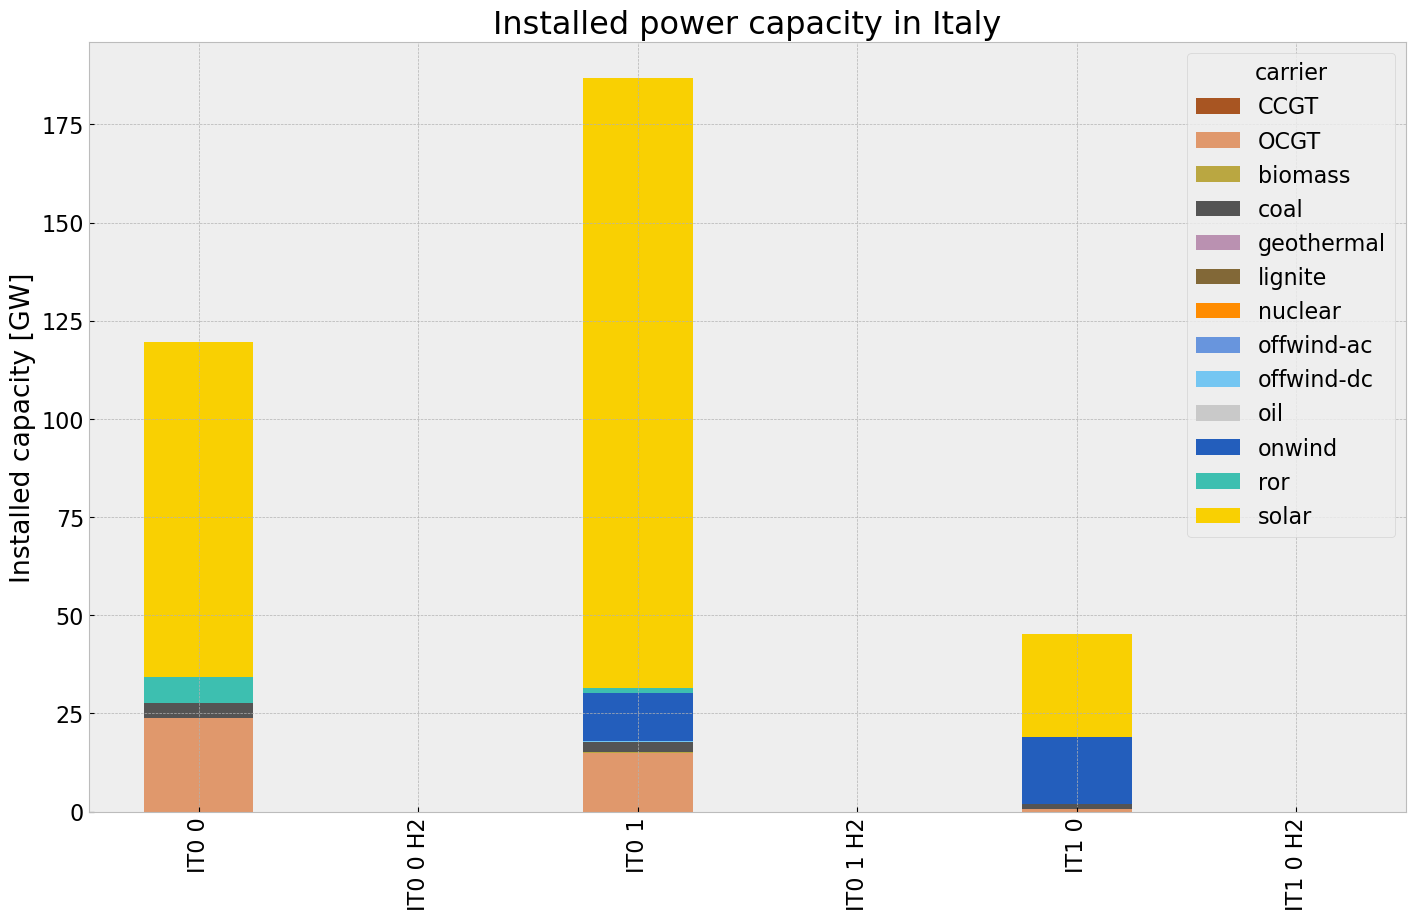

<Figure size 640x480 with 0 Axes>

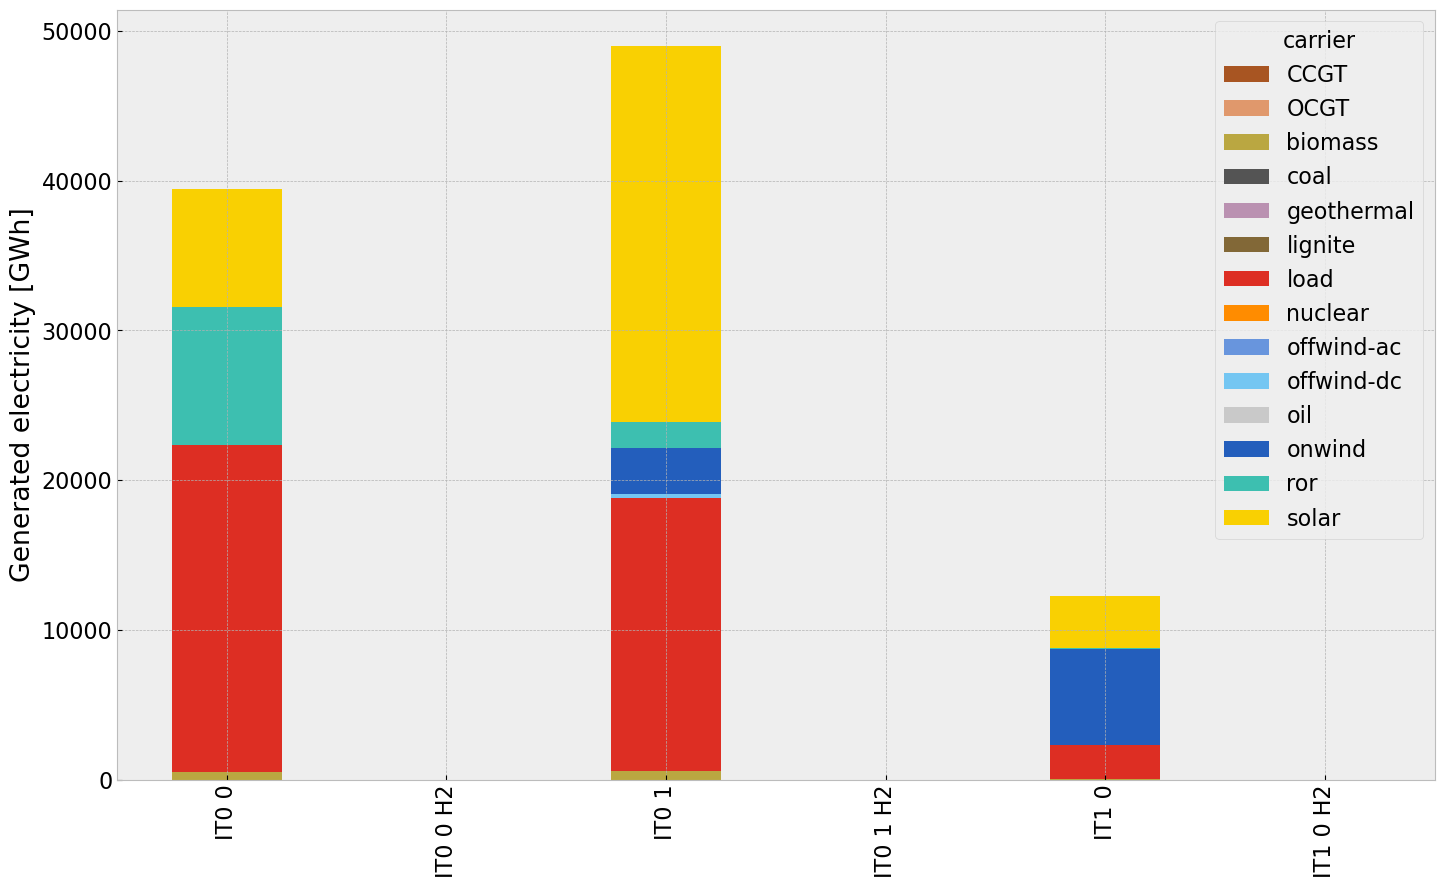

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\1688527312.py:33: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p = n3.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\1688527312.py:34: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sto = n3.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2428868374.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  links = n.links_t.p1.groupby(n.links.carrier, 

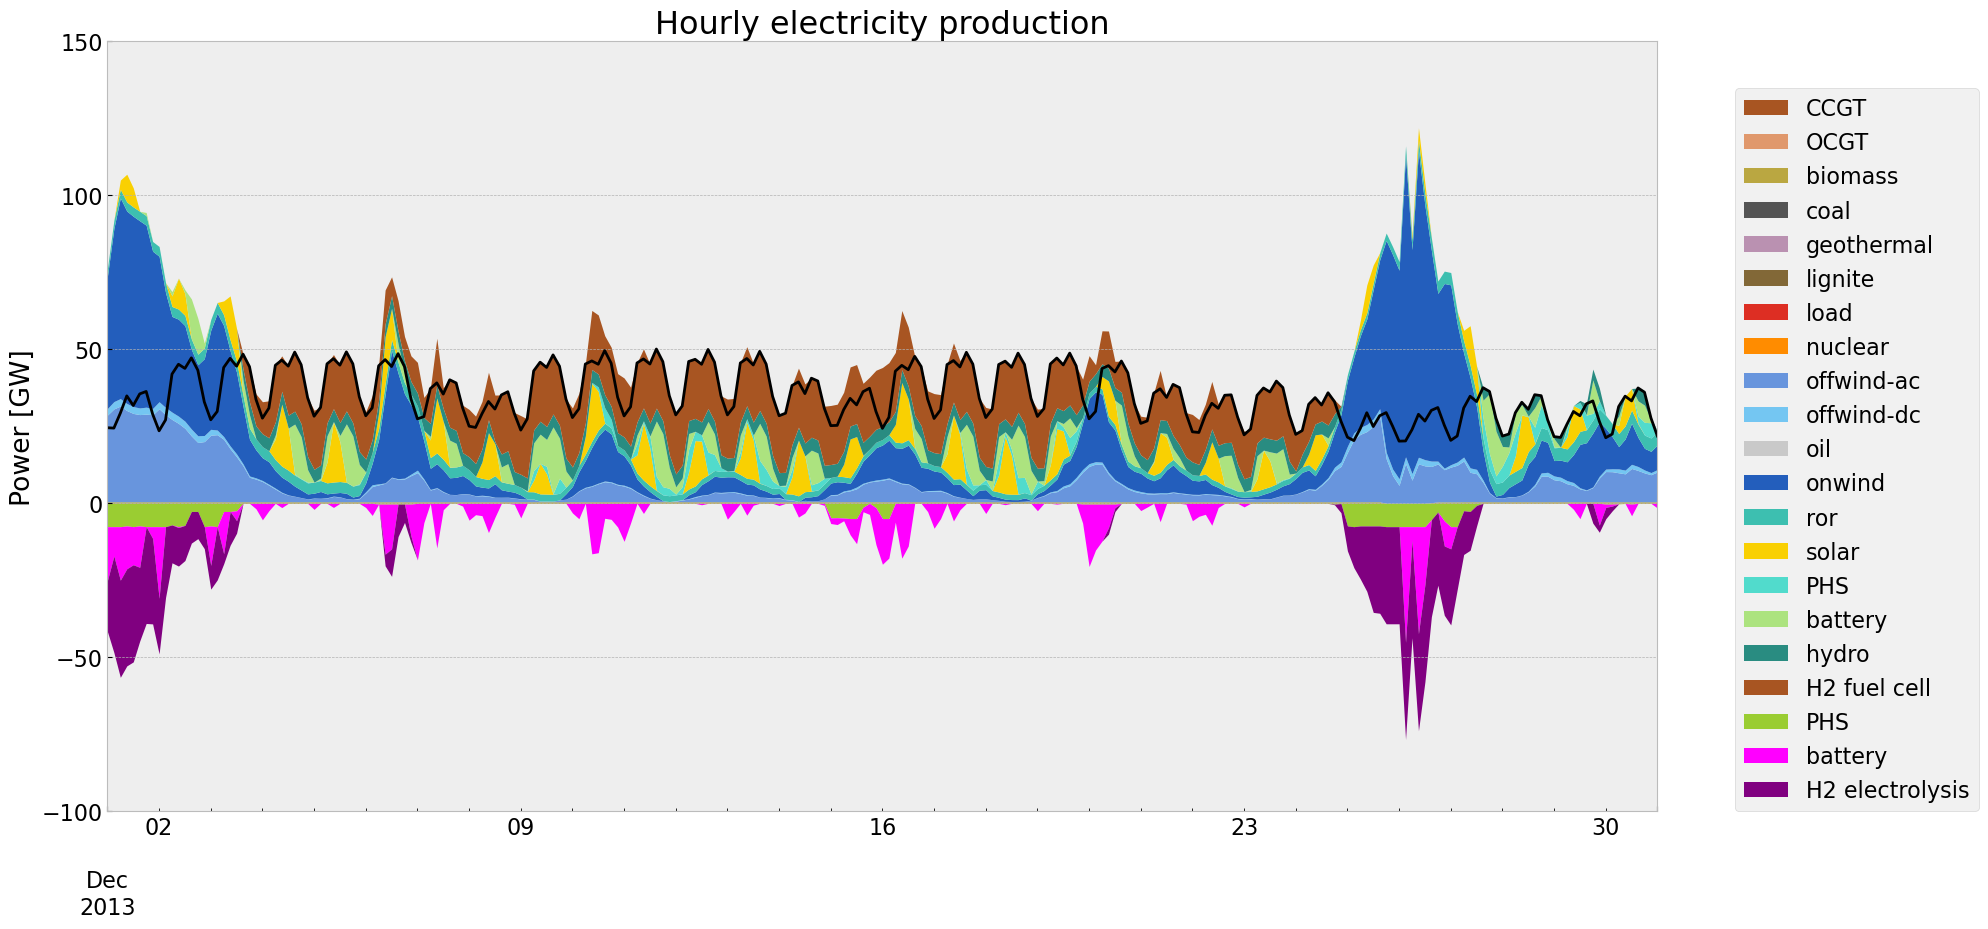

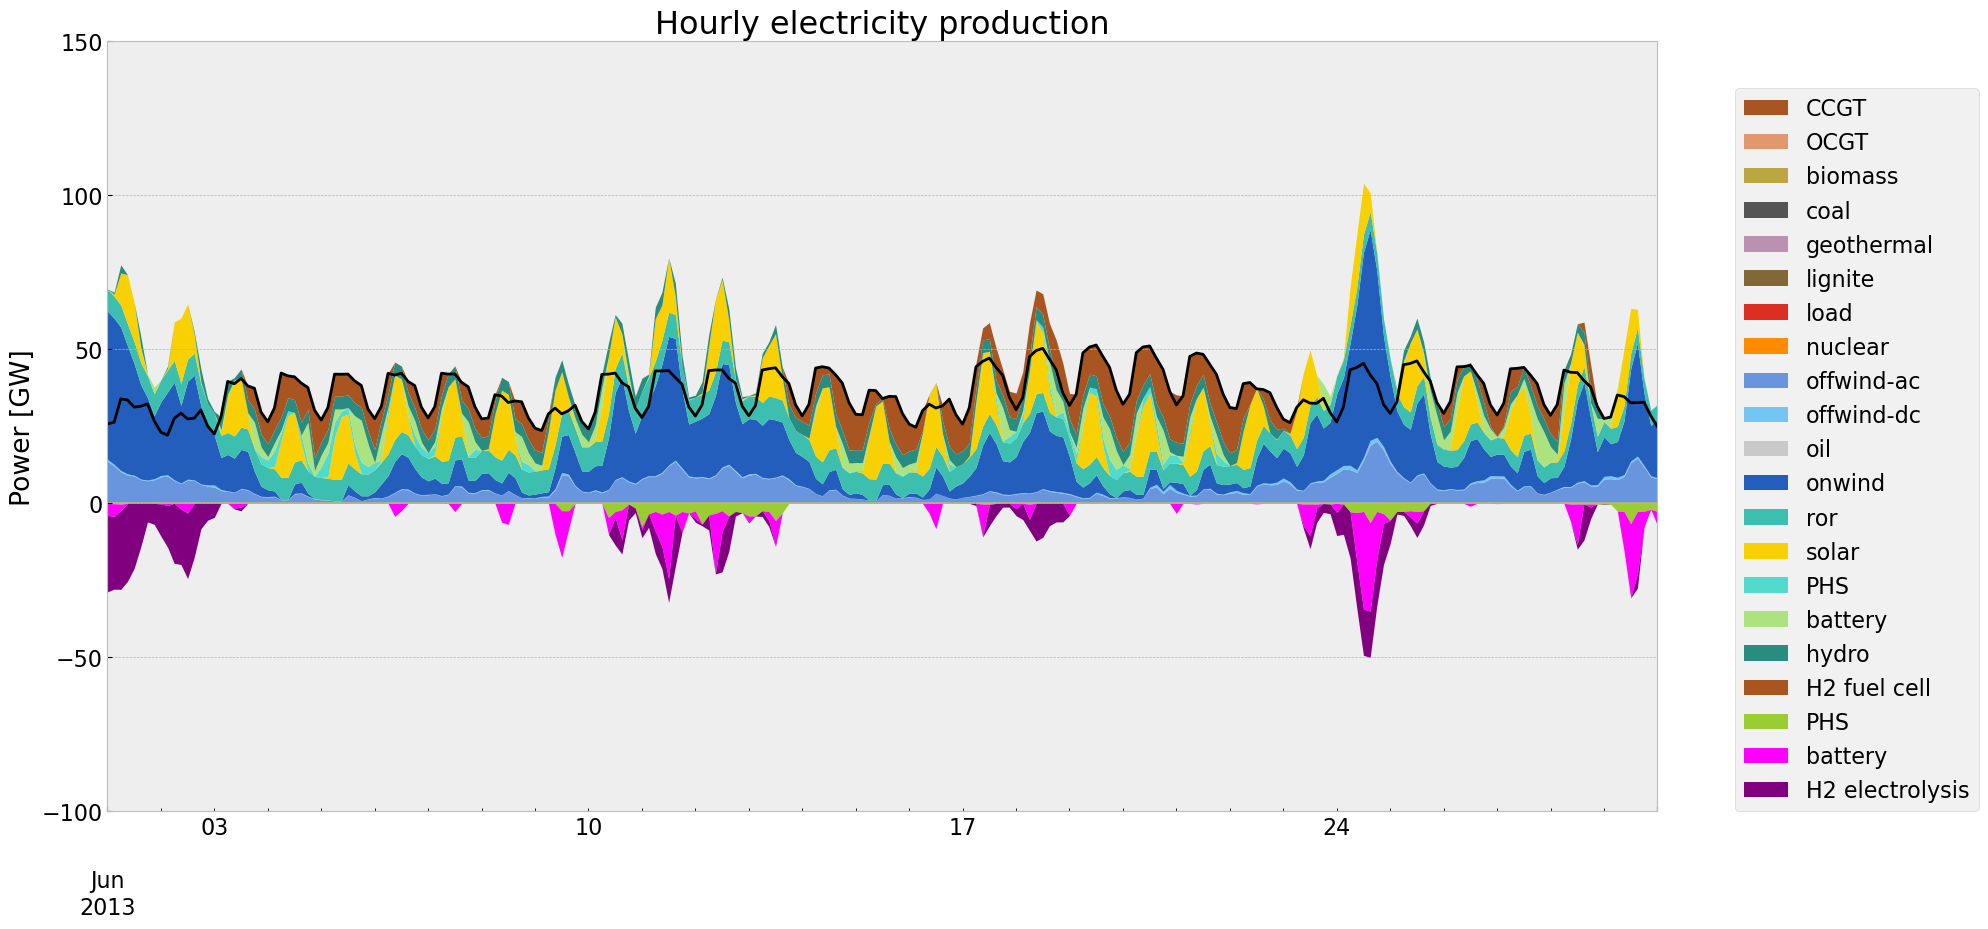

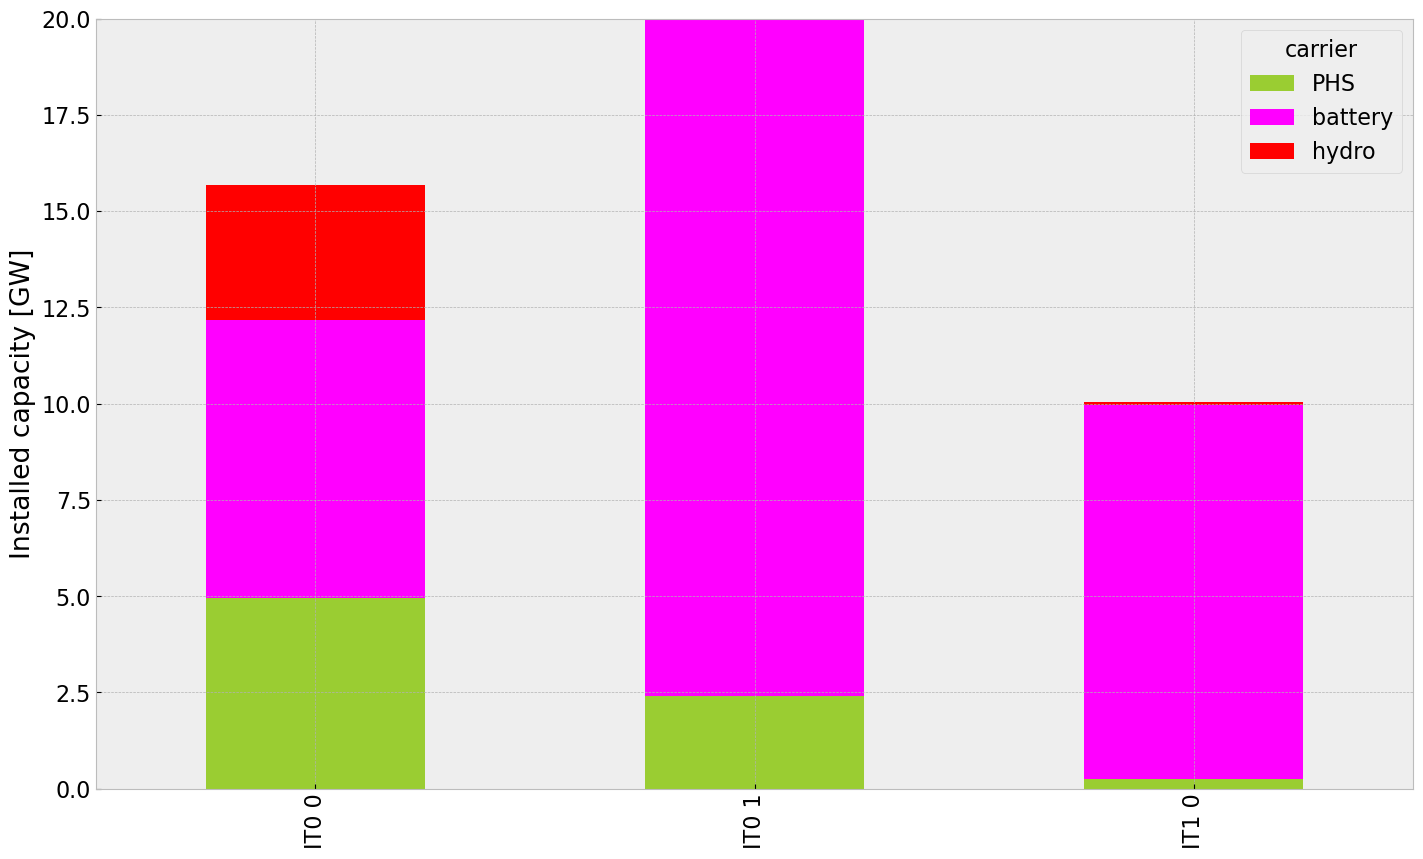

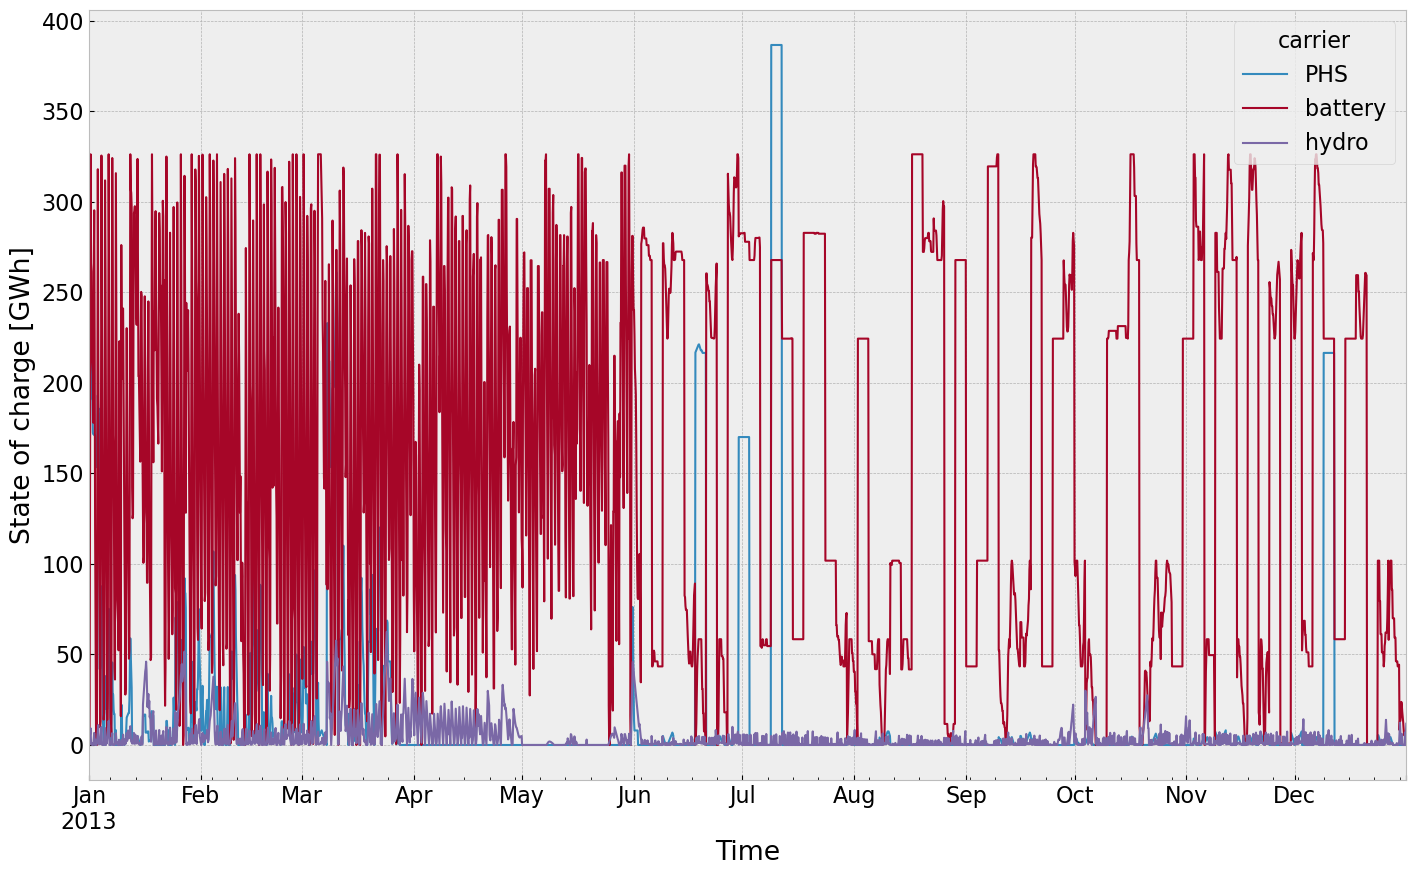

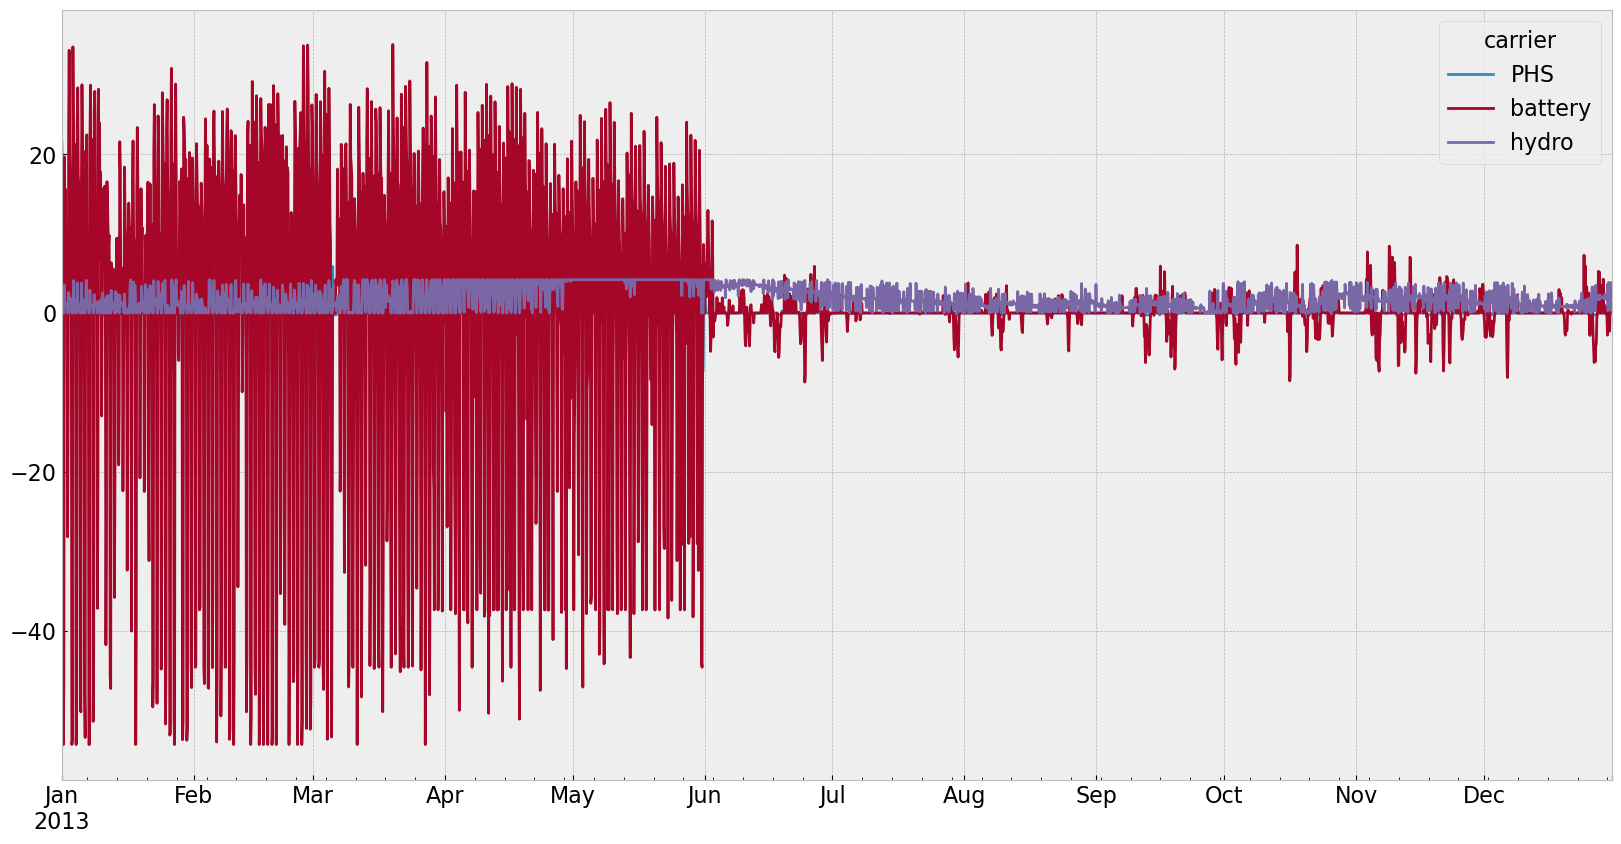

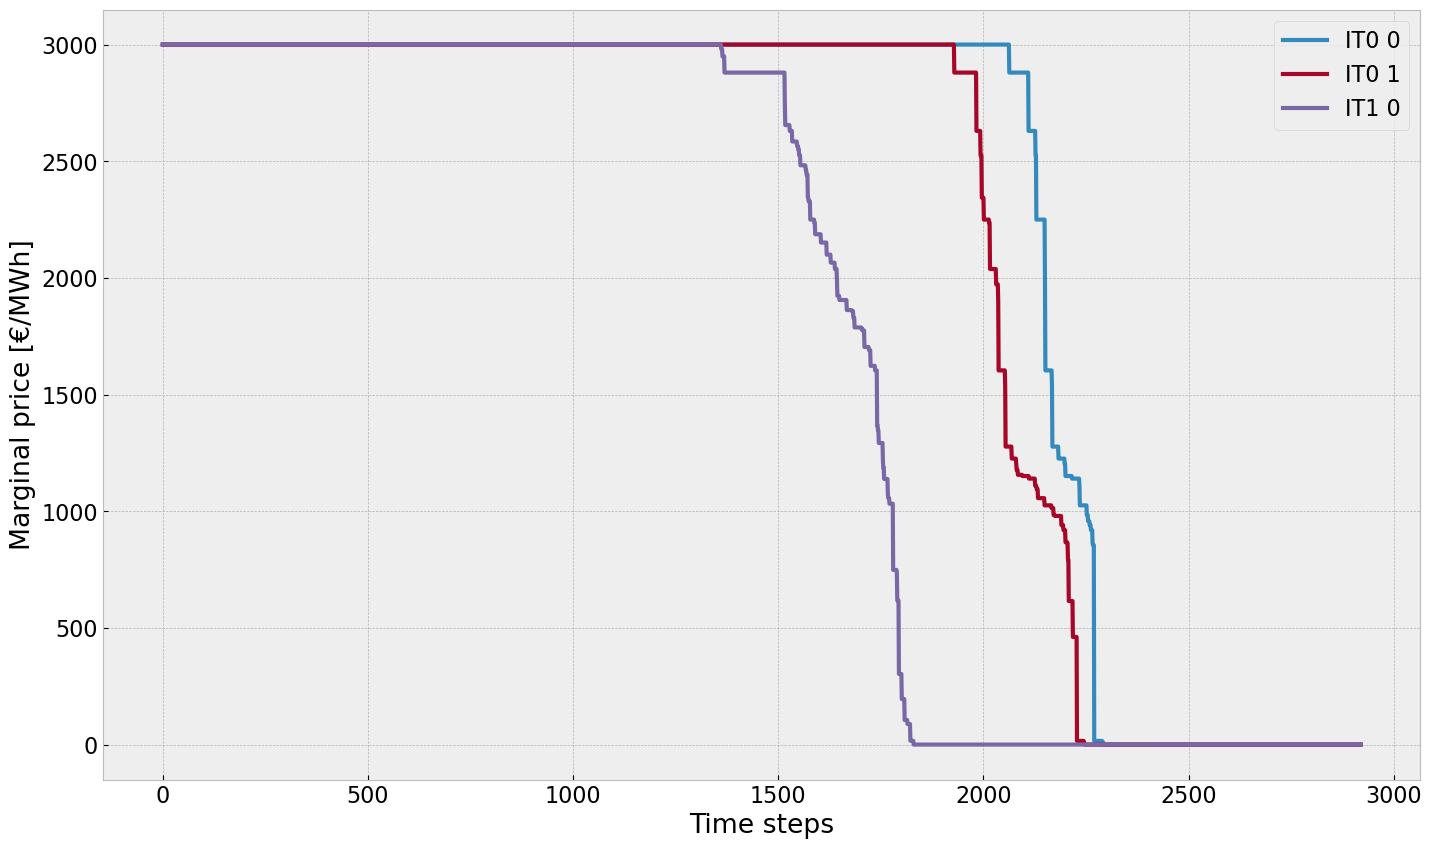

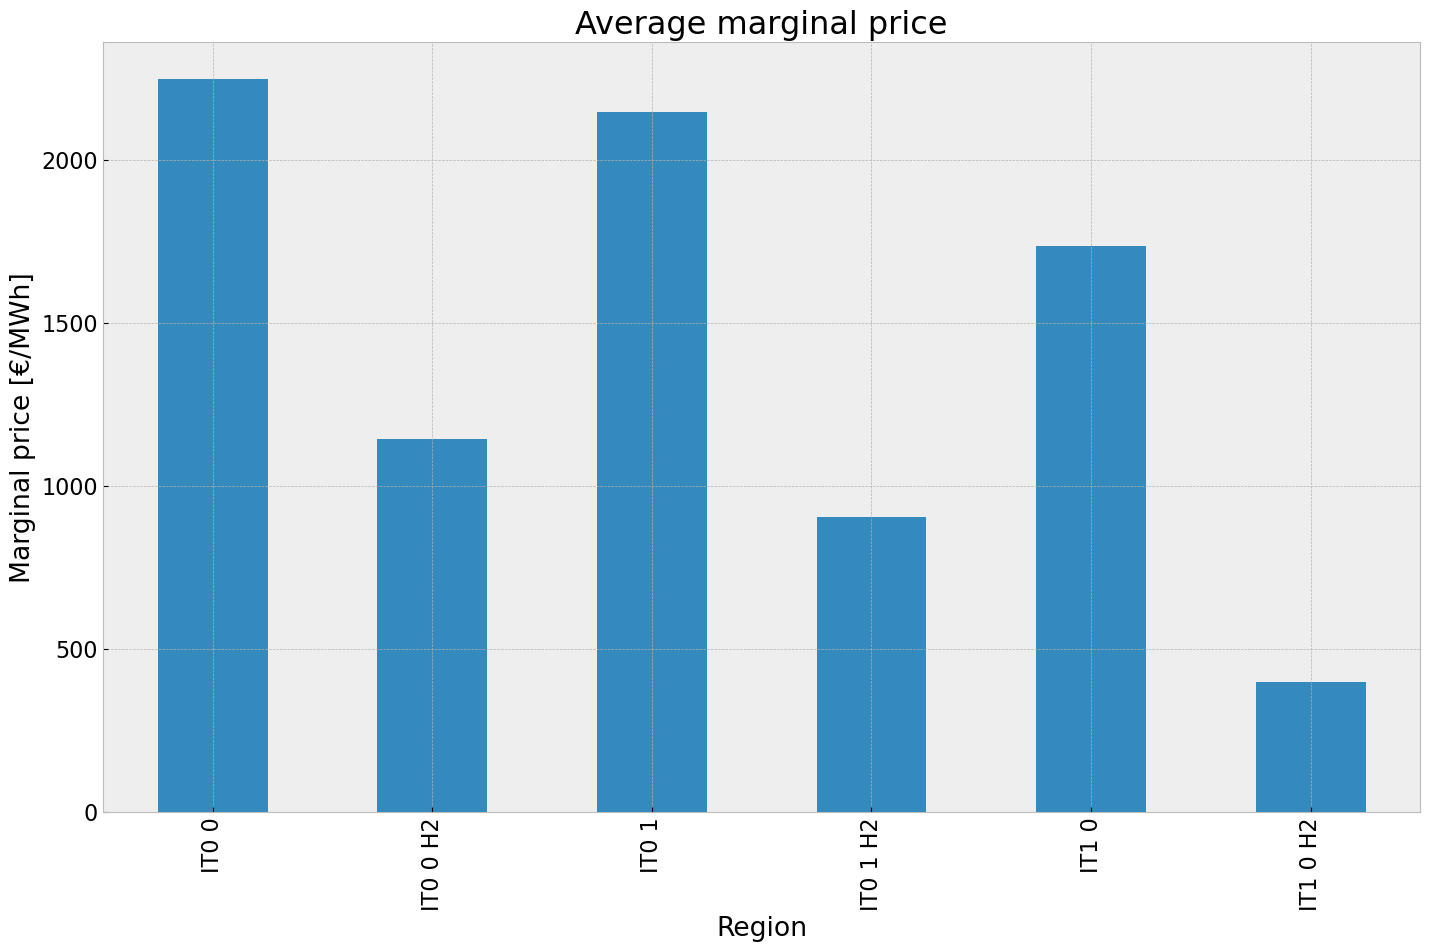

In [189]:
# Plotting
#installed cap
capacities_noinv_roll = n3.generators.groupby(['bus', 'carrier']).p_nom_opt.sum()
capacities_noinv_roll.fillna(0, inplace=True)
gen = (capacities_noinv_roll.unstack()/1000).drop(columns=['load'],inplace=False)


cap_noinv_roll = inst_cap_table(n3, color_cap)

#Generation table
# consolidated generation table
carrier = n3.generators.carrier.unique()
df_tot_generation = n3.generators_t.p.sum()

generations = pd.Series(index = n3.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().index)

for r in region:
    for tech in carrier:
        key = f"{r} {tech}"
        if key in df_tot_generation.index:
            try:
                generations.loc[r, tech] = df_tot_generation[key]
                #print(generations.loc[r, tech])
            except KeyError:
                print('error')
generations.fillna(0, inplace=True)

gen_noinv_roll =(generations.unstack()/1000)#GWh

gen_noinv_roll  = gen_power_table(n3,colors_gen_table)

#Snapshot Summer and Winter
p = n3.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
sto = n3.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)    

gen_curve(n1, '2013-12-01', '2013-12-31', colors_gen)
gen_curve(n1, '2013-06-01', '2013-06-30', colors_gen)

#installed storage unit
inst_store_table(n3)

#State of Charge Storage unit
state_of_charge_plot(n3)
n3.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3).loc[pd.date_range(start="2013-01-01", end="2013-12-31",freq='3H')].plot(figsize=(20,10))


#Electricitty Price duration curve
price_dur_curve_plot(n3)

#avg electricity price
price_regions_table(n3)

# Scenario Analysis

## Installed Capacity

In [171]:
comp_inst_cap = pd.DataFrame(index=capacities_base.unstack().drop(columns=['load'],inplace=False).columns)

comp_inst_cap["Base scenario"] = capacities_base.groupby("carrier").sum().div(1e3).drop(index="load")
comp_inst_cap["Allow add Inv"] = capacities_inv.groupby("carrier").sum().div(1e3).drop(index="load")
comp_inst_cap["No add Inv"] = capacities_noinv.groupby("carrier").sum().div(1e3).drop(index="load")
comp_inst_cap["No add Inv Rolling Horizon"] = capacities_noinv_roll.groupby("carrier").sum().div(1e3).drop(index="load")

comp_inst_cap.rename(index = {"coal": "Coal"}, inplace=True)
comp_inst_cap.rename(index = {"OCGT": "Open-Cycle Gas"}, inplace=True)
comp_inst_cap.rename(index = {"CCGT": "Closed-Cycle Gas"}, inplace=True)
comp_inst_cap.rename(index = {"ror": "Run of River"}, inplace=True)
comp_inst_cap.rename(index = {"offwind-ac": "Offshore Wind AC"}, inplace=True)
comp_inst_cap.rename(index = {"offwind-dc": "Offshore Wind DC"}, inplace=True)
comp_inst_cap.rename(index = {"onwind": "Onshore Wind"}, inplace=True)
comp_inst_cap.rename(index = {"solar": "Solar"}, inplace=True)
comp_inst_cap.rename(index = {"oil": "Oil"}, inplace=True)
comp_inst_cap.rename(index = {"geothermal": "Geothermal"}, inplace=True)
comp_inst_cap.rename(index = {"nuclear": "Nuclear"}, inplace=True)
comp_inst_cap.rename(index = {"biomass": "Biomass"}, inplace=True)
comp_inst_cap.rename(index = {"lignite": "Lignite"}, inplace=True)

comp_inst_cap.fillna(0, inplace=True)

In [172]:
comp_inst_cap

Base scenario  Allow add Inv  No add Inv  \
carrier                                                      
Closed-Cycle Gas       0.000000       0.000000    0.000000   
Open-Cycle Gas        39.420200      39.420200   39.420200   
Biomass                0.508000       0.508000    0.508000   
Coal                   7.275926       7.275926    7.275926   
Geothermal             0.059000       0.059000    0.059000   
Lignite                0.000000       0.000000    0.000000   
Nuclear                0.000000       0.000000    0.000000   
Offshore Wind AC       0.000000      43.021620    0.000000   
Offshore Wind DC       0.384920       2.818122    0.384920   
Oil                    0.150000       0.150000    0.150000   
Onshore Wind          29.176831     138.043194   29.176831   
Run of River           7.871540       7.871540    7.871540   
Solar                266.732577     343.199300  266.732577   

                  No add Inv Rolling Horizon  
carrier                                       
Closed-Cycle Gas                    0.000000  
Open-Cycle Gas                     39.420200  
Biomass                             0.508000  
Coal                                7.275926  
Geothermal                          0.059000  
Lignite                             0.000000  
Nuclear                             0.000000  
Offshore Wind AC                    0.000000  
Offshore Wind DC                    0.384920  
Oil                                 0.150000  
Onshore Wind                       29.176831  
Run of River                        7.871540  
Solar                             266.732577

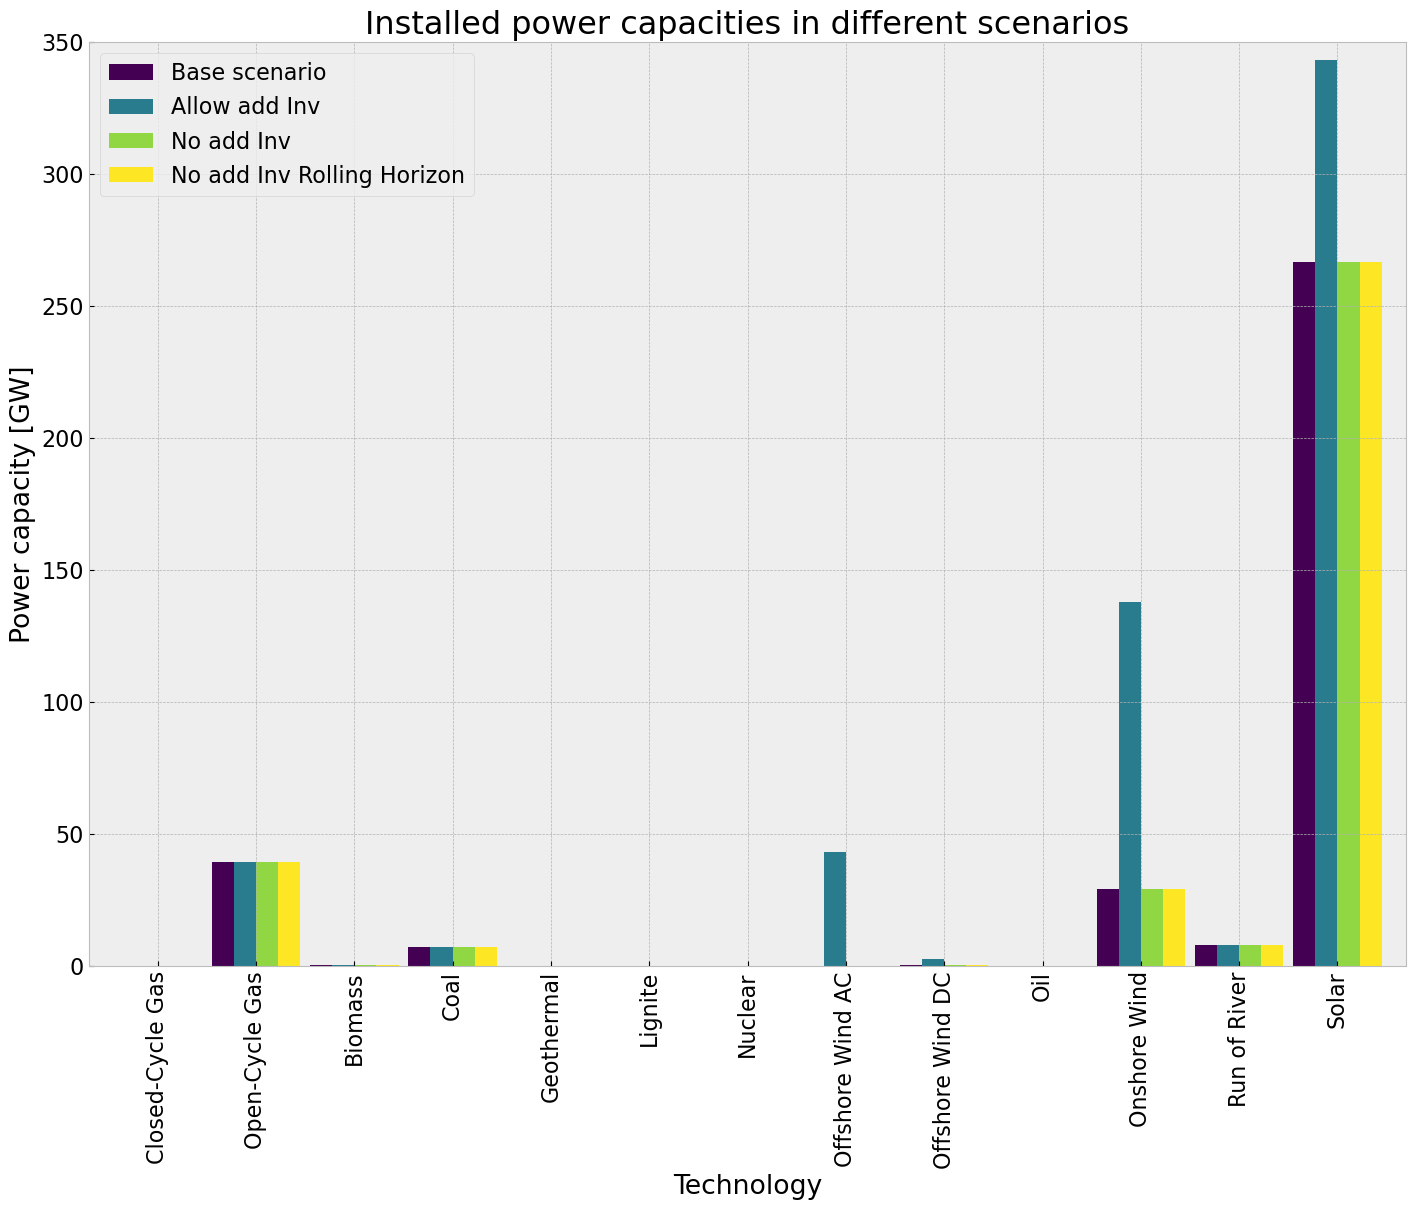

In [191]:
#colors = cm.viridis(np.linspace(0, 5, len(comp_inst_cap)))

comp_inst_cap.plot.bar(figsize=(17,12),
                        color=cm.viridis(np.linspace(0, 5, len(comp_inst_cap))),
                        grid=True,
                        xlabel="Technology",
                        ylabel="Power capacity [GW]",
                        title=f"Installed power capacities in different scenarios",
                        ylim=[0,350],
                        width=0.9
)
plt.show()

## Power Generation

In [174]:
comp_gen_electr = pd.DataFrame(index = ["Base scenario", "Allow add Inv", "No add Inv", "No add Inv Rolling Horizon"],
                                columns = tech_list_gen_table)

comp_gen_electr.loc["Base scenario"] = gen_base.sum().div(1e3) # TWh/a
comp_gen_electr.loc["Allow add Inv"] = gen_inv.sum().div(1e3) # TWh/a
comp_gen_electr.loc["No add Inv"] = gen_noinv.sum().div(1e3) # TWh/a
comp_gen_electr.loc["No add Inv Rolling Horizon"] = gen_noinv_roll.sum().div(1e3) # TWh/a


#comp_gen_electr.rename(columns = {"coal": "Coal"}, inplace=True)
#comp_gen_electr.rename(columns = {"gas": "Gas"}, inplace=True)
#comp_gen_electr.rename(columns = {"hydro": "Hydro"}, inplace=True)
#comp_gen_electr.rename(columns = {"offwind": "Offshore Wind"}, inplace=True)
#comp_gen_electr.rename(columns = {"onwind": "Onshore Wind"}, inplace=True)
#comp_gen_electr.rename(columns = {"solar": "Solar"}, inplace=True)
#comp_gen_electr.rename(columns = {"oil": "Oil"}, inplace=True)
#comp_gen_electr.rename(columns = {"geothermal": "Geothermal"}, inplace=True)
#comp_gen_electr.rename(columns = {"nuclear": "Nuclear"}, inplace=True)

comp_gen_electr.fillna(0, inplace=True)

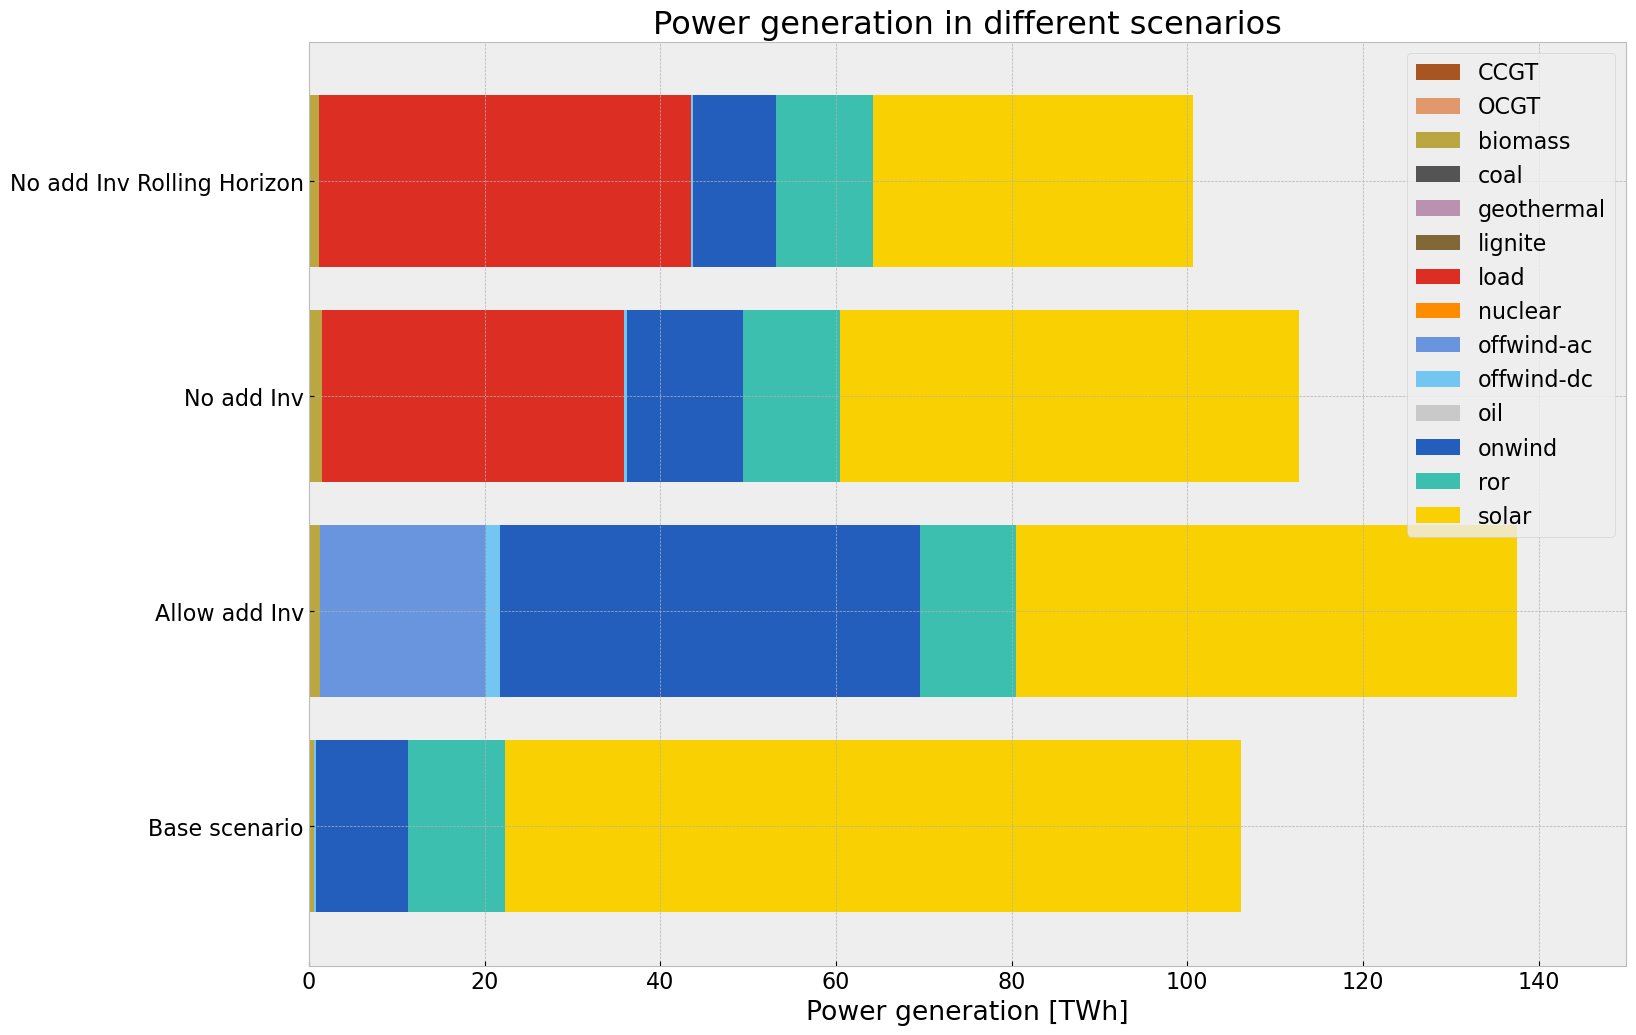

In [192]:
comp_gen_electr.plot.barh(figsize=(17,12),
                        color=colors_gen_table,
                        grid=True,
                        stacked=True, 
                        ylabel="",
                        xlabel="Power generation [TWh]",
                        title=f"Power generation in different scenarios",
                        xlim=[0,150],
                        width=0.8
)
plt.show()

## Average System Cost

In [176]:
tech_comp = system_cost_base.index.tolist()
comp_system_cost = pd.DataFrame(index = ["Base scenario", "Allowed add Inv", "No add Inv", "No add Inv Rolling Horizon"],
                                columns =tech_comp)

demand = n.snapshot_weightings.generators @ n.loads_t.p_set.sum(axis=1) # the same in each scenario

comp_system_cost.loc["Base scenario"] = system_cost_base # Million €/a
comp_system_cost.loc["Allowed add Inv"] = system_cost_inv # Million €/a
#if tot_cost_0_PV > 0: 
#    comp_system_cost.loc["0% PV potential"] = system_cost_0_PV # Million €/a
#else: comp_system_cost.loc["0% PV potential"] = 0.0
#if tot_cost_20_PV > 0: 
#    comp_system_cost.loc["20% PV potential"] = system_cost_20_PV # Million €/a
#else: comp_system_cost.loc["20% PV potential"] = 0.0
comp_system_cost.loc["No add Inv"] = system_cost_noinv # Million €/a
comp_system_cost.loc["No add Inv Rolling Horizon"] = system_cost_noinv_roll # Million €/a

if 'AC' in system_cost_base:
    comp_system_cost.AC = comp_system_cost.AC-system_cost_base.AC # expenditure for already existing transmission lines

comp_system_cost[comp_system_cost<0] = 0 # since we subtact the AC cost (for the 0% or 20%) 
#comp_system_cost.iloc[0,0] = system_cost_base.AC


comp_system_cost = comp_system_cost.mul(1e6).div(demand) #eur0/

#comp_system_cost.rename(columns = {"battery storage": "Battery storage"}, inplace=True)
#comp_system_cost.rename(columns = {"hydrogen storage underground": "Hydrogen storage underground"}, inplace=True)

comp_system_cost.fillna(0, inplace=True)

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\2925963551.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comp_system_cost.fillna(0, inplace=True)


C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\727309253.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if comp_system_cost.columns[i] == n.carriers.nice_name[j]:
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\727309253.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  colors_comp.append(n.carriers.color[j])


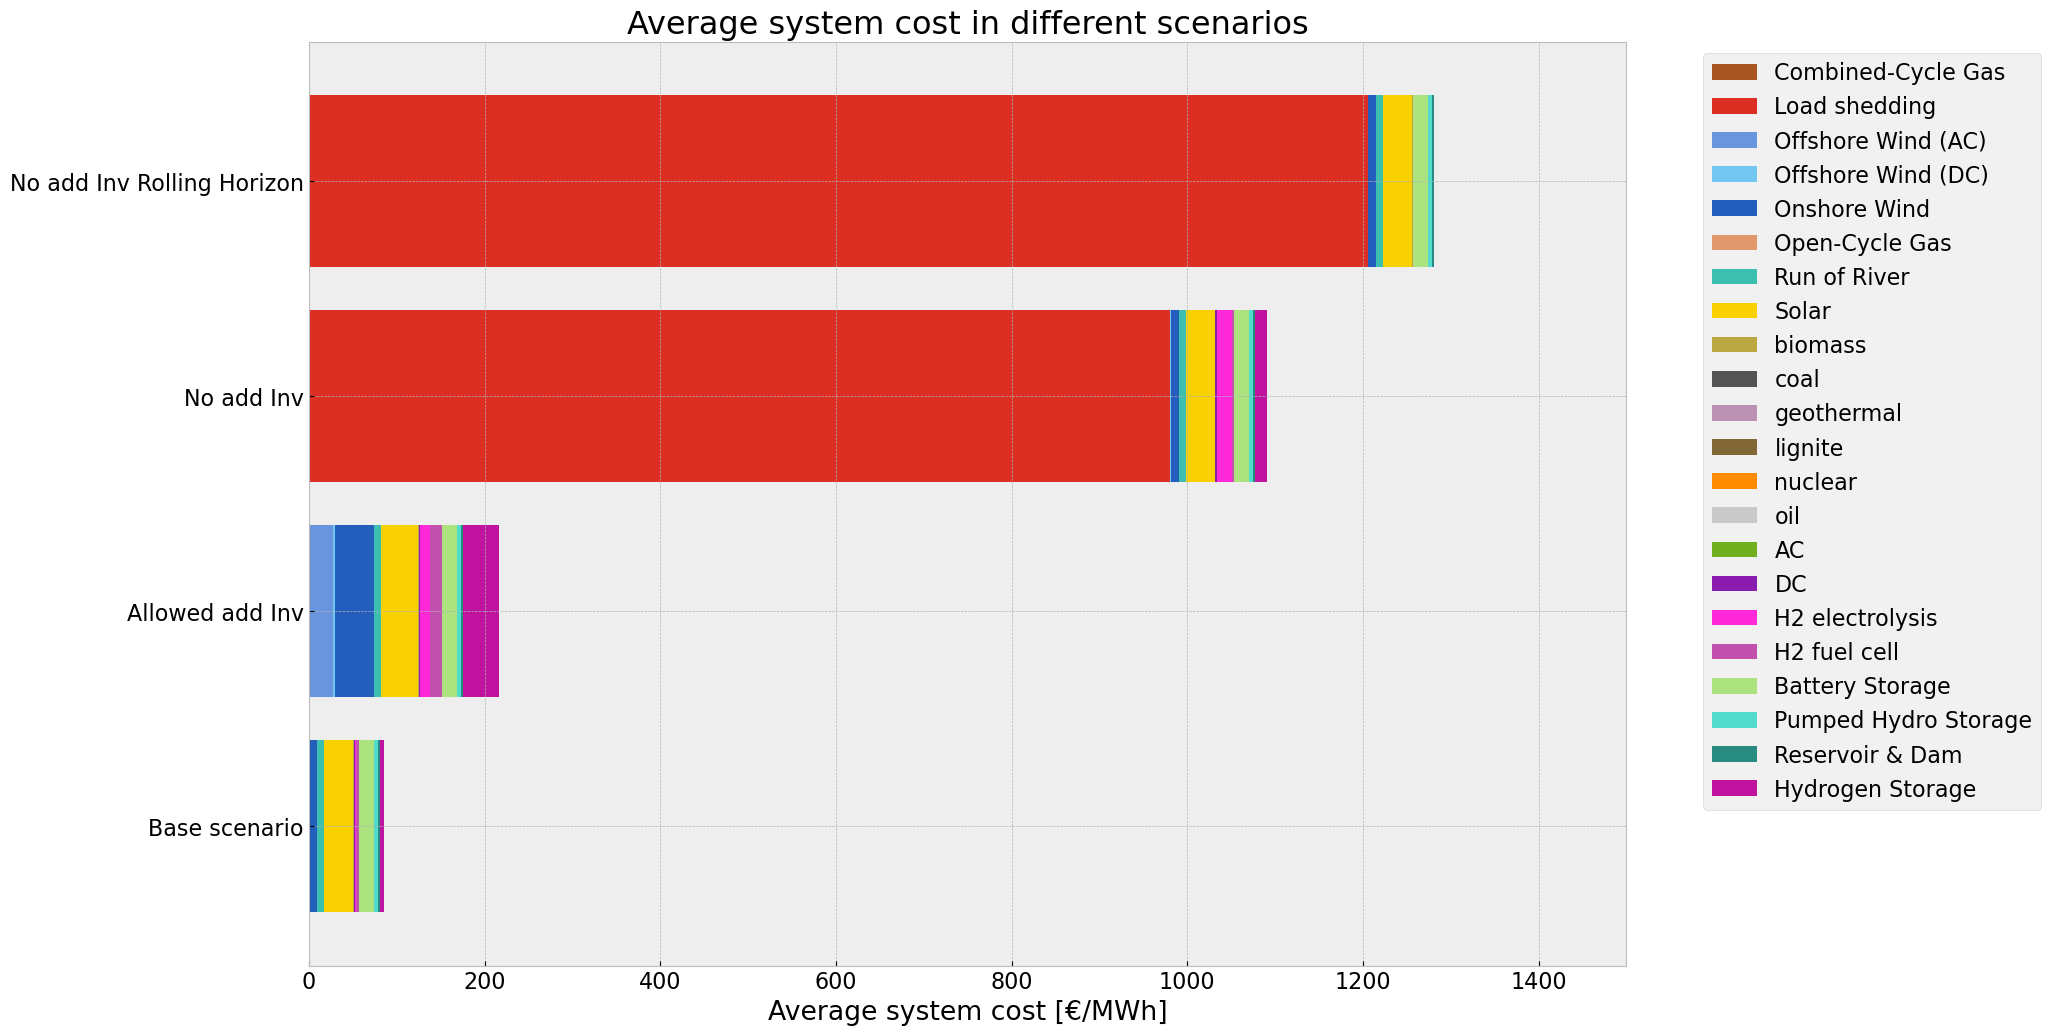

In [195]:
colors_comp = []

for i in range(len(comp_system_cost.columns)):
    for j in range(len(n.carriers.nice_name)):
        if comp_system_cost.columns[i] == n.carriers.nice_name[j]:
            colors_comp.append(n.carriers.color[j])
            #print(n.carriers.nice_name[j],comp_system_cost.columns[i],n.carriers.color[j])
            break  # break the inner loop once a match is found  



comp_system_cost.plot.barh(figsize=(17,12),
                        color=colors_comp,
                        grid=True,
                        stacked=True,
                        ylabel="",
                        xlabel="Average system cost [€/MWh]",
                        title=f"Average system cost in different scenarios",
                        xlim=[0,1500],
                        width=0.8
)
# Move legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [178]:
n3.generators_t.p.sum()#.groupby(n.generators.carrier).sum()


Generator
IT0 0 CCGT          0.000000e+00
IT0 0 H2 load       0.000000e+00
IT0 0 OCGT          0.000000e+00
IT0 0 biomass       4.939360e+05
IT0 0 coal          0.000000e+00
IT0 0 geothermal    0.000000e+00
IT0 0 lignite       0.000000e+00
IT0 0 load          2.183339e+07
IT0 0 nuclear       0.000000e+00
IT0 0 offwind-ac    0.000000e+00
IT0 0 offwind-dc    0.000000e+00
IT0 0 oil           0.000000e+00
IT0 0 onwind        0.000000e+00
IT0 0 ror           9.212249e+06
IT0 0 solar         7.919671e+06
IT0 1 CCGT          0.000000e+00
IT0 1 H2 load       0.000000e+00
IT0 1 OCGT          0.000000e+00
IT0 1 biomass       5.718812e+05
IT0 1 coal          0.000000e+00
IT0 1 geothermal    0.000000e+00
IT0 1 lignite       0.000000e+00
IT0 1 load          1.823756e+07
IT0 1 nuclear       0.000000e+00
IT0 1 offwind-ac    0.000000e+00
IT0 1 offwind-dc    2.752564e+05
IT0 1 oil           0.000000e+00
IT0 1 onwind        3.066976e+06
IT0 1 ror           1.708369e+06
IT0 1 solar         2.510466e+07


In [179]:
n3.statistics.energy_balance(aggregate_time=False, aggregate_bus=False).loc[:, :, "AC",:].droplevel(2).sum(axis=1)

component    carrier             
StorageUnit  Battery Storage        -3.729579e+04
             Battery Storage        -3.822393e+05
             Battery Storage        -7.467051e+04
             Pumped Hydro Storage   -1.257411e+05
             Pumped Hydro Storage   -9.469344e+04
             Pumped Hydro Storage   -2.175056e+04
             Reservoir & Dam         4.488869e+06
             Reservoir & Dam         7.748247e+05
             Reservoir & Dam         9.972992e+04
Load         -                      -6.466586e+07
             -                      -3.575673e+07
             -                      -4.919661e+06
Line         AC                      2.088077e+07
             AC                     -2.088077e+07
Generator    Combined-Cycle Gas      0.000000e+00
             Combined-Cycle Gas      0.000000e+00
             Combined-Cycle Gas      0.000000e+00
             Load shedding           2.183339e+07
             Load shedding           1.823756e+07
             Loa

## Curtailment

In [180]:
comp_curtailment = pd.DataFrame(index = ["Base scenario", "Allow add Inv", "No add Inv", "No add Inv Rolling Horizon"],
                                columns = stat_base.loc["Generator"].index)

comp_curtailment.loc["Base scenario"] = stat_base.loc["Generator"].Curtailment.div(1e6) # TWh
comp_curtailment.loc["Allow add Inv"] = stat_inv.loc["Generator"].Curtailment.div(1e6) # TWh
comp_curtailment.loc["No add Inv"] = stat_noinv.loc["Generator"].Curtailment.div(1e6) # TWh
comp_curtailment.loc["No add Inv Rolling Horizon"] = stat_noinv_roll.loc["Generator"].Curtailment.div(1e6) # TWh

comp_curtailment.fillna(0, inplace=True)

In [181]:
color_curtailment=[]

for i in range(len(comp_curtailment.columns)):
    for j in range(len(n.carriers.nice_name)):
        if comp_curtailment.columns[i] == n.carriers.nice_name[j]:
            color_curtailment.append(n.carriers.color[j])
            #print(n.carriers.nice_name[j],comp_system_cost.columns[i],n.carriers.color[j])
            break  # break the inner loop once a match is found 

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\3109801822.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if comp_curtailment.columns[i] == n.carriers.nice_name[j]:
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_4392\3109801822.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color_curtailment.append(n.carriers.color[j])


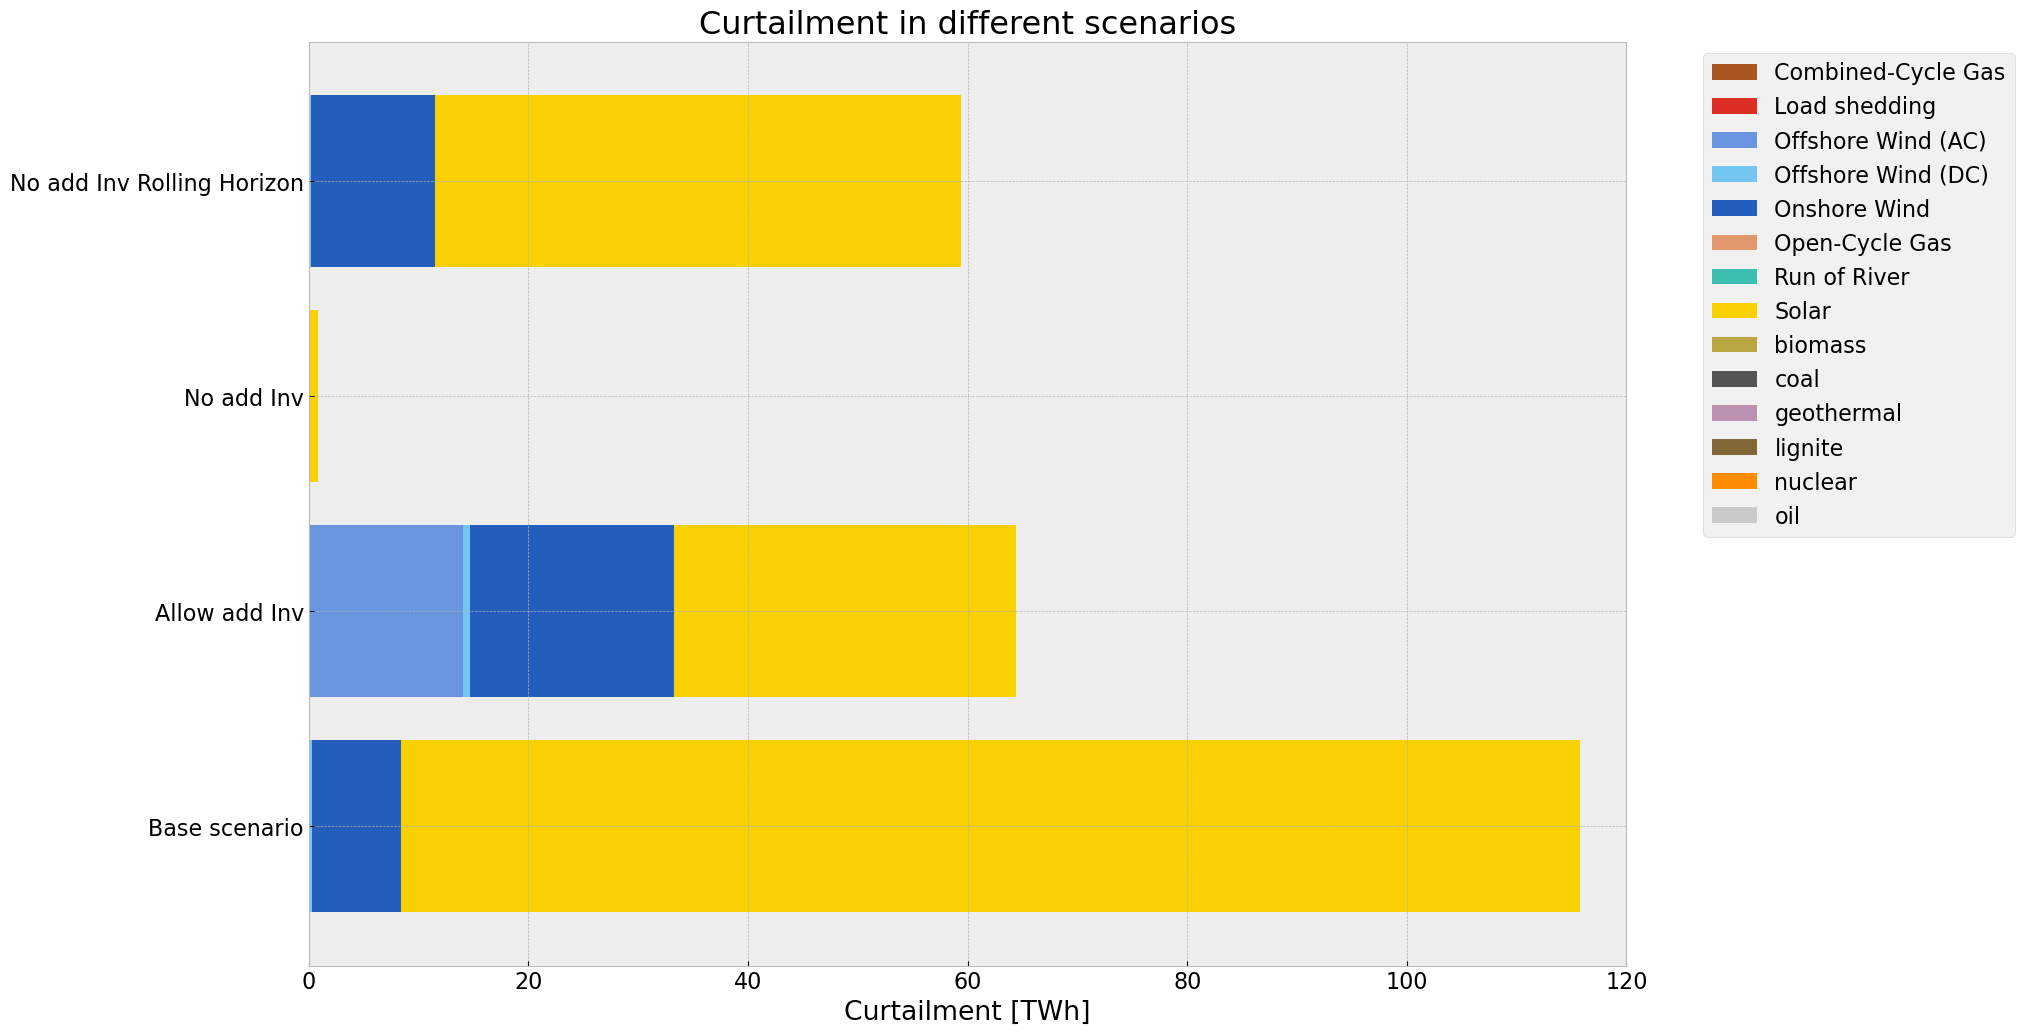

In [202]:
comp_curtailment.plot.barh(figsize=(17,12),
                        color=color_curtailment,
                        grid=True,
                        stacked=True, 
                        ylabel="",
                        xlabel="Curtailment [TWh]",
                        title=f"Curtailment in different scenarios",
                        xlim=[0,120],
                        width=0.8
)
# Move legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()